In [1]:
import pycl
pycl.larger_display(90)

In [2]:
# Standard lib imports
import csv
from collections import OrderedDict, Counter
from os import access, R_OK
import sys
from gzip import open as gopen
import warnings
from time import time
from statistics import median
from glob import glob

# Local lib import
import pycl
import pyBioPlot as pbp
import pyBioUtil as pbu
from pycl import head as h

# Third party import
import pandas as pd
import numpy as np
import pylab as pl
import pysam
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec

# Jupyter specific imports
from IPython.core.display import display, HTML, Markdown, Image
from ipywidgets import widgets

# Pyplot tweaking
%pylab inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Simplify warning reporting to lighten the notebook style 
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Folder setup and download test files

In [13]:
print ("Create directory for the test dataset files")
!mkdir -p "./test_data/"

Create directory for the test dataset files


In [14]:
print ("Download reference human genome from Gencode")
!wget "ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/GRCh38.primary_assembly.genome.fa.gz" -O "./test_data/GRCh38_primary.fa.gz"

Download reference human genome from Gencode
--2016-10-19 17:43:34--  ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/GRCh38.primary_assembly.genome.fa.gz
           => ‘./test_data/GRCh38_primary.fa.gz’
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/gencode/Gencode_human/release_25 ... done.
==> SIZE GRCh38.primary_assembly.genome.fa.gz ... 844691642
==> PASV ... done.    ==> RETR GRCh38.primary_assembly.genome.fa.gz ... done.
Length: 844691642 (806M) (unauthoritative)

GRCh38.primary_asse 100%[===================>] 805.56M  2.46MB/s    in 7m 36s  

2016-10-19 17:51:11 (1.77 MB/s) - ‘./test_data/GRCh38_primary.fa.gz’ saved [844691642]



In [15]:
print ("Download reference gencode v25 human genome annotation")
!wget "ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gff3.gz" -O "./test_data/gencode_v25_primary.gff3.gz"

Download reference gencode v25 human genome annotation
--2016-10-19 17:51:11--  ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gff3.gz
           => ‘./test_data/gencode_v25_primary.gff3.gz’
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/gencode/Gencode_human/release_25 ... done.
==> SIZE gencode.v25.primary_assembly.annotation.gff3.gz ... 46752876
==> PASV ... done.    ==> RETR gencode.v25.primary_assembly.annotation.gff3.gz ... done.
Length: 46752876 (45M) (unauthoritative)

gencode.v25.primary 100%[===================>]  44.59M  2.45MB/s    in 25s     

2016-10-19 17:51:39 (1.81 MB/s) - ‘./test_data/gencode_v25_primary.gff3.gz’ saved [46752876]



In [16]:
print ("Download reference gencode v25 human genome annotation")
!wget "ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gtf.gz" -O "./test_data/gencode_v25_primary.gtf.gz"

Download reference gencode v25 human genome annotation
--2016-10-19 17:51:39--  ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gtf.gz
           => ‘./test_data/gencode_v25_primary.gtf.gz’
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/gencode/Gencode_human/release_25 ... done.
==> SIZE gencode.v25.primary_assembly.annotation.gtf.gz ... 38827267
==> PASV ... done.    ==> RETR gencode.v25.primary_assembly.annotation.gtf.gz ... done.
Length: 38827267 (37M) (unauthoritative)

gencode.v25.primary 100%[===================>]  37.03M  2.40MB/s    in 20s     

2016-10-19 17:51:59 (1.83 MB/s) - ‘./test_data/gencode_v25_primary.gtf.gz’ saved [38827267]



In [17]:
print ("Download reference gencode v25 human genome annotation")
!wget "http://www.noncode.org/datadownload/NONCODE2016_human_hg38_lncRNA.gtf.gz" -O "./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz"

Download reference gencode v25 human genome annotation
--2016-10-19 17:51:59--  http://www.noncode.org/datadownload/NONCODE2016_human_hg38_lncRNA.gtf.gz
Resolving www.noncode.org (www.noncode.org)... 112.124.13.146
Connecting to www.noncode.org (www.noncode.org)|112.124.13.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8248713 (7.9M) [application/x-gzip]
Saving to: ‘./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz’

./test_data/NONCODE 100%[===================>]   7.87M  45.0KB/s    in 3m 8s   

2016-10-19 17:55:17 (42.8 KB/s) - ‘./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz’ saved [8248713/8248713]



In [3]:
print ("Download example bam file")
!wget -v "http://www.ebi.ac.uk/~aleg/data/share/1M_sample.bam" -O "./test_data/1M_sample.bam"

Download example bam file
--2016-11-15 16:31:35--  http://www.ebi.ac.uk/~aleg/data/share/1M_sample.bam
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168022796 (160M) [text/plain]
Saving to: ‘./test_data/1M_sample.bam’

./test_data/1M_samp 100%[===================>] 160.24M  1.87MB/s    in 72s     

2016-11-15 16:32:47 (2.22 MB/s) - ‘./test_data/1M_sample.bam’ saved [168022796/168022796]



In [4]:
print ("Download example bam file")
!wget -v "http://www.ebi.ac.uk/~aleg/data/share/10M_sample.bam" -O "./test_data/10M_sample.bam"

Download example bam file
--2016-11-15 16:32:47--  http://www.ebi.ac.uk/~aleg/data/share/10M_sample.bam
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598885831 (1.5G) [text/plain]
Saving to: ‘./test_data/10M_sample.bam’

./test_data/10M_sam 100%[===================>]   1.49G  2.38MB/s    in 10m 11s 

2016-11-15 16:42:58 (2.50 MB/s) - ‘./test_data/10M_sample.bam’ saved [1598885831/1598885831]



In [6]:
print ("Download example bed file")
!wget "http://noncode.org/datadownload/NONCODE2016_hg38.lncAndGene.bed.gz" -O "../dl_test_data/NONCODE2016_hg38.lncAndGene.bed.gz"

--2017-02-17 15:52:28--  http://noncode.org/datadownload/NONCODE2016_hg38.lncAndGene.bed.gz
Resolving noncode.org (noncode.org)... 112.124.13.146
Connecting to noncode.org (noncode.org)|112.124.13.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5907810 (5.6M) [application/x-gzip]
Saving to: ‘../dl_test_data/NONCODE2016_hg38.lncAndGene.bed.gz’

../dl_test_data/NON 100%[===================>]   5.63M   610KB/s    in 11s     

2017-02-17 15:52:39 (515 KB/s) - ‘../dl_test_data/NONCODE2016_hg38.lncAndGene.bed.gz’ saved [5907810/5907810]



## First prototype of the class

In [3]:
#~~~~~~~GENERIC HELPER FUNCTIONS~~~~~~~#

def get_extensions (fp):
    """ 
    Return The extension of a file in lower-case. If archived file "gz"
    the method will output the base extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return ""
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return ".{}.{}".format(split_name[-2], split_name[-1]).lower()
    # Normal situation = return the last element of the list
    else:
        return ".{}".format(split_name[-1]).lower()
    
def get_basename (fp):
    """ 
    Return The extension of a file in lower-case. If archived file "gz"
    the method will output the base extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return split_name[0]
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return ".".join(split_name[0:-2])
    # Normal situation = return the last element of the list
    else:
        return ".{}".format(split_name[0]).lower()

def is_readable_file (fp):
    """
    Verify the readability of a file or list of file
    """
    return access(fp, R_OK)
        
def color_palette(n, colormap="brg"):
    """
    Return a list of l length with gradient colors from a given matplot lib colormap palette
    * n         Number of color scalar in the list
    * colormap  colormap color palette from matplotlib package see http://matplotlib.org/examples/color/colormaps_reference.html
                example : inferno magma hot blues cool spring winter brg ocean hsv jet ... [DEFAULT: brg]
    """
    # Init variables
    cmap = get_cmap(colormap)
    index = 1 # skip the first value 
    n_col_cmap = cmap.N-2 # remove border colors
    step = int(n_col_cmap/(n-1)) if n > 1 else n_col_cmap/2
    
    # Create the list of colors
    cl = []
    for i in range (n):
        cl.append(cmap(index))
        index+=step
    return cl
        
#~~~~~~~HELPER CLASSES~~~~~~~#

class gff3_line(object):
    def __init__ (self, pysam_gff_line):
        self.contig = pysam_gff_line.contig
        self.source = pysam_gff_line.source
        self.start = pysam_gff_line.start
        self.end = pysam_gff_line.end
        self.strand = pysam_gff_line.strand
        self.score = pysam_gff_line.score
        self.frame = pysam_gff_line.frame
        self.feature = pysam_gff_line.feature
        self.true_start = self.start if self.strand == "+" else self.end
        self.true_end = self.end if self.strand == "+" else self.start 
        
        for attribute in pysam_gff_line.attributes.split(";"):
            k,v = attribute.split("=")
            self.__dict__[k] = v
            
    def __str__(self):
        """readeable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)

#~~~~~~~MAIN CLASS~~~~~~~#
    
class JGV(object):
    
    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fasta=None, index=None, verbose=False):
        """
        Create an JGV reference containing a list of seqid retrieved from a fasta file or a fasta index file (fai).
        One of the 2 files has to be given to initialise the object.
        * fasta     A fasta file containing the reference sequences. The file will be parsed to get the name and length
                    of the sequences, but the sequence per se do not need to be saved. A tab separated file containing the name of
                    the sequences and the length will be written in the same dir as the fasta file. this file can be used latter as
                    an index file. Can be gziped or not 
        * index     A file containing at least 2 columns with the seqid and the length in base. It could be a fai file generated
                    by samtools faidx or any other tab separated format. This option is much faster than the fasta option.
                    Can be gziped or not
        * verbose   If True, will print more information during execution
        """
        self.verbose = verbose
        
        if not fasta and not index:
            raise ValueError ("A fasta file or a fasta index has to be given")
        
        if self.verbose: print("Initialize JGV with a reference genome")
        
        if fasta:
            if self.verbose: print("\tReading fasta file and extracting sequence information")
            # Verify that the file is readable and in fasta format 
            if not is_readable_file (fasta):
                raise IOError ("{} is not readable".format(fasta))
            # Verify that the file is in fasta format
            if get_extensions(fasta) not in [".fa", ".fasta", ".fa.gz", ".fasta.gz"]:
                raise ValueError ("The file is not in fasta format(.fa or .fasta +- .gz). Please provide a correctly formated file")
            # Parse and save a dict with the seqid and the length of each sequence
            self.seqid_dict = self._fasta_parser(fasta)
            # Write an index file for latter
            filename = fasta[:-len(get_extensions(fasta))]+"_index.tsv"
            if self.verbose: print("\tWriting an index file")
            with open(filename,'w') as csvfile:
                w = csv.writer(csvfile, delimiter='\t')
                w.writerows(self.seqid_dict.items())
                
        if index:
            if self.verbose: print("\tReading index file and extracting sequence information")
            # Verify that the file is readable
            if not is_readable_file (index):
                raise IOError ("{} is not readable".format(index))
            # Parse and save a dict with the seqid and the length of each sequence
            self.seqid_dict = self._index_parser(index)
        
        if self.verbose: print("\tTotal number of sequences found: {}".format(len(self.seqid_dict)))
        
        # Init empty
        self.annotation_dict = OrderedDict()
        self.alignment_dict = OrderedDict()        
            
    def __str__(self):
        """readeable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__)
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+= "\t{}\t{}\n".format(k, v)
        return (msg)
                                  
    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _fasta_parser (self, fp):
        """ Parse a fasta file and return a dict """
        f = None
        try:
            f = gopen(fp, "rt") if fp.endswith(".gz") else open(fp, "r")
            c = Counter()
            for l in f:
                if l.startswith(">"):
                    seqid = l[1:].split()[0].strip()
                else:
                    c[seqid]+=len(l.strip())
        finally:
            if f:
                f.close()
        return OrderedDict(c)
    
    def _index_parser (self, fp):
        """ Parse a fasta file and return a dict """
        f = None
        try:
            f = gopen(fp, "rt") if fp.endswith(".gz") else open(fp, "r")
            d = OrderedDict()
            for l in f:
                ls = l.split("\t")
                assert len(ls) >= 2, "The index file is incorectly formated"
                seqid = ls[0].strip()
                length = int(ls[1].strip())
                d[seqid] = length
        finally:
            if f:
                f.close()       
        return d              
    #~~~~~~~PUBLIC METHODS~~~~~~~#
    
    def add_annotation (self, fp, name=None):
        """
        * fp A standard gff3 file (http://www.ensembl.org/info/website/upload/gff3.html) containing all feature annotation.
                                Could be uncompressed or achived in the following format ("gz"). Ideally already indexed
                                with tabix bgzip. If not the programm will sort the features and index the file (can takes time)
        """
        # Verify that the file is readable
        if not is_readable_file (fp):
            raise IOError ("{} is not readable".format(fp))
        # Extract basename and extension for further 
        extension = get_extensions(fp)
        if not name:
            name = get_basename(fp)
        # Verify that the file is in gff3 format
        if extension not in [".gff3.gz", ".gff3"]:
            raise ValueError ("The file is not in gff3 format (.gff3.gz, .gff3). Please provide a correctly formated file")

        # If not indexed, sort and compress and index the original file with tabix 
        if not is_readable_file (fp+".tbi"):
           
            # Import in a panda dataframe, remove empty row, and convert coordinates in integer
            if self.verbose:  print("Indexing file with tabix\n\tImport annotation file and clean data")
            df = pd.read_csv(fp, names=["seqname","source","feature","start","stop","score","strand","frame","attribute"], sep="\t")
            df.dropna(inplace=True)
            df[['start', 'stop']] = df[['start', 'stop']].astype(int)
            
            # Sort the dataframe
            if self.verbose: print("\tSort lines by coordinates")
            df.sort_values(by=["seqname","start","stop"], inplace=True)
            # Remove the extension, name the output file and write in file
            temp_file = fp[:-len(extension)]+"_sorted.gff3"
            df.to_csv(temp_file, sep="\t", header=False, index=False)
            
            # Compress and index the sorted file with tabix
            if self.verbose: print("\tCompress and index with tabix")
            fp = pysam.tabix_index(temp_file, preset="gff", force=True)
        
        # Common steps if existing or generated index
        with pysam.TabixFile(fp, parser=pysam.asGTF()) as gff:
            if self.verbose: print("Gff file indexed")
            # Verify the sequence id 
            for seqid in [i.decode() for i in gff.contigs]:
                if seqid not in self.seqid_dict:
                    warnings.warn("{} seqid from annotation file not found in the initial fasta file".format(seqid))
            self.annotation_dict[name] = gff.filename.decode()
    
    def add_alignment (self, fp, name=None):
        """
        * fp        A standard BAM formated file containing aligned short reads SORTED. Ideally the file would also be indexed
        """
        # Verify that the file is readable
        is_readable_file (fp)
        # Extract basename and extension for further 
        extension = get_extensions(fp)
        if not name:
            name = get_basename(fp)
        # Verify that the file is in bam format
        if extension not in [".bam"]:
            raise ValueError ("The file is not in BAM format (.bam). Please provide a correctly formated file")
        
        with pysam.AlignmentFile(fp) as bam:
            # If not bam index available
            if not bam.has_index():
                # If no index but file sorted
                if bam.header["HD"]['SO'] == "coordinate":
                    if self.verbose: print("Indexing bam file")
                    pysam.index(fp, catch_stdout=False)
                else:
                    raise UserWarning ("The file bam needs to be sorted by coordinates to be processed")
            
            assert bam.has_index(), "Bam file is not indexed ?"
            if self.verbose: print("Bam file indexed")
            for seqid in bam.references:
                if seqid not in self.seqid_dict:
                    warnings.warn("{} seqid from annotation file not found in the initial fasta file".format(seqid))
            self.alignment_dict[name] =  bam.filename.decode()    
    
    def plot_interval(self,
        seqid, start=None, end=None,
        alignment_tracks=[],
        alignment_n_step=500,
        alignment_yscale="linear",
        alignment_mode="auto",
        annotation_tracks=[],
        annotation_feature_types=[],
        annotation_label=False,
        annotation_overlap_offset=None,
        annotation_max_level=None,
        plot_style="ggplot",
        track_width=30,
        alignment_track_height=10,
        annotation_track_height=2):
        """
        """
        
        # Verify that the requested seqid is in the file and check the start and end coordinates
        # Get coordinates if not given and verify the given coordinates
        if self.verbose: print ("Check coordinates")
        if not seqid in self.seqid_dict:
            raise UserWarning ("Seqid {} not found in the reference file".format(seqid))
        if not start or start < 0:
            start = 0         
        if not end or end > self.seqid_dict[seqid]:
            end = self.seqid_dict[seqid]    
        if start >= end:
            raise UserWarning ("Invalid start end coordinates".format(seqid))
        
        # Parse alignment
        if self.verbose: print ("Parse alignment files")
        if not alignment_tracks:
            alignment_tracks = self.alignment_dict.keys()
        alignment_track_dict = OrderedDict()
        alignment_track_count = 0
        for track_name in alignment_tracks:
            d = self.parse_alignment(
                track_name=track_name,
                seqid=seqid,
                start=start,
                end=end,
                n_step=alignment_n_step,
                mode=alignment_mode)
            alignment_track_count += len(d)
            alignment_track_dict[track_name] = d
        
        # Parse annotations
        if self.verbose: print ("Parse annotation files")
        if not annotation_tracks:
            annotation_tracks = self.annotation_dict.keys()
        annotation_track_dict = OrderedDict()
        annotation_track_count = 0
        for track_name in annotation_tracks:
            d = self.parse_annotation (
                track_name=track_name,
                seqid=seqid,
                start=start,
                end=end,
                feature_types=annotation_feature_types,
                overlap_offset=annotation_overlap_offset,
                max_level=annotation_max_level)
            annotation_track_count += len(d)
            annotation_track_dict[track_name] = d
            
        # Prepare the multipannel figure for plotting
        total_height = alignment_track_count*(alignment_track_height+1)
        total_height+= annotation_track_count*annotation_track_height + len(annotation_track_dict)

        pl.style.use(plot_style)
        fig = pl.figure(figsize=(track_width, total_height), frameon=False)
        grid = GridSpec(total_height, 1, hspace=0.01)
        
        # Initial level for the first subplot
        h=0
        if self.verbose: print ("Plot alignment tracks")
        for track_name, coord_dict in alignment_track_dict.items():
            if self.verbose: print ("\tTrack name: {}".format(track_name))
            h+=1
            # Define the ploting area for the current track
            subplot = pl.subplot(grid[h:h+alignment_track_height])
            h+=alignment_track_height
                    
            # Tweak the subplot
            subplot.set_xlim((start, end))
            subplot.yaxis.set_tick_params(left=False, right=False, labelleft=True, labelright=False)
            subplot.xaxis.set_tick_params(bottom=False, top=False, labelbottom=True, labeltop=False)
            subplot.ticklabel_format(useOffset=False, style='plain')
            subplot.set_title(track_name)
            
            if alignment_yscale == "log":
                if any(coord_dict["y"]) <= 0:
                    warnings.warn("Data has no positive values, and therefore can not be log-scaled.")
                else:
                    subplot.set_yscale("log")
            
            # Plot the area
            subplot.fill_between(coord_dict["x"], 0, coord_dict["y"])
        
        if self.verbose: print ("Plot annotation tracks")
        for track_name, feature_dict in annotation_track_dict.items():
            color_list = color_palette(len(feature_dict) ,"Set2")
            if self.verbose: print ("\tTrack name: {}".format(track_name))
            h+=1
            for i, (feature_type, level_dict) in enumerate(feature_dict.items()):
                if self.verbose: rint ("\t\tPloting feature: {}".format(feature_type))
                
                # Define the ploting area for the current track
                subplot = pl.subplot(grid[h:h+annotation_track_height])
                h+=annotation_track_height
                
                # Tweak the subplot
                subplot.set_xlim((start, end))
                subplot.set_ylim((0, len(level_dict)+1))
                subplot.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
                subplot.ticklabel_format(useOffset=False, style='plain')
                subplot.set_ylabel(feature_type)
                subplot.grid(axis="y", b=False)
                # Title only for first line
                if i == 0:
                    subplot.set_title(track_name)
                # xlabel only for last line
                if i == len(feature_dict)-1:
                    subplot.xaxis.set_tick_params(bottom=False, top=False, labelbottom=True, labeltop=False)
                else:
                    subplot.xaxis.set_tick_params(bottom=False, top=False, labelbottom=False, labeltop=False)
                
                for level, list_line in level_dict.items():                   
                    for line in list_line:
                        # Scale the arrow depending of the number of lines
                        arrowstyle = "{style},head_width={width},head_length={lenght}".format(
                            style="-|>",  width=6/len(level_dict)+1, lenght=12/len(level_dict)+1)

                        # Plot the arrow
                        subplot.add_patch(arrow (
                            posA=[line.true_start,level+1],
                            posB=[line.true_end,level+1],
                            arrowstyle=arrowstyle,
                            linewidth=12/len(level_dict)+1,
                            edgecolor=color_list[i],
                            facecolor=color_list[i]))
                        
                        # Add text
                        if annotation_label:
                            mid = line.true_start+(line.true_end-line.true_start)/2
                            if start <= mid <= end:
                                subplot.text (x=mid, y=level+1, s=line.ID, horizontalalignment="center")
        

    def parse_alignment (self, track_name, seqid, start=0, end=100000, n_step=500, mode="auto"):
        """
        * force_mode "auto" or "read_count" or "base_coverage"
        """
        fp = self.alignment_dict[track_name]
        
        # Autocorect the step if needed to be always <= to the requested interval
        d = OrderedDict()
        d["x"] = []
        d["y"] = []
        len_range = end-start
        if n_step > len_range:
            n_step = len_range
            warnings.warn("Short interval = autocorect n_step to {}".format(n_step))
        step_size = (end-start) / float(n_step)

        # Count method is less accurate but much quicker for very long intervals.
        # Do not take into account spliced sites, ie read will be represented from their first mapped
        # to their last base
        
        if mode == "read_count" or (mode == "auto" and len_range > 5000000):
            if self.verbose:
                print("Select read_count mode") 
            start_pos = start
            with pysam.AlignmentFile(fp) as bam:
                for i in range(n_step):

                    d["x"].append(round(start_pos))
                    d["y"].append(bam.count(seqid, start_pos, start_pos+step_size))

                    start_pos+=step_size

        # Coverage method is more precise and quicker for smaller intervals but become really slow when > 5000000
        elif mode == "base_coverage" or (mode == "auto" and len_range <= 5000000):
            if self.verbose:
                print("Select base_coverage mode")
            with pysam.AlignmentFile(fp) as bam:
                mat = bam.count_coverage(seqid, start, end)
                start_pos = 0
                while start_pos <= len_range-step_size:            
                    s = round(start_pos)
                    e = round(start_pos+step_size)

                    d["x"].append(round(start+start_pos))
                    d["y"].append(median(mat[0][s:e])+sum(mat[1][s:e])+sum(mat[2][s:e])+sum(mat[3][s:e]))

                    start_pos+=step_size
        return d

    def parse_annotation (self, track_name, seqid, start=0, end=100000, feature_types=[], overlap_offset=None, max_level=None):
        """
        """
        fp = self.annotation_dict[track_name]
        with pysam.TabixFile(fp, parser=pysam.asGTF()) as f:

            # Verify that the required seqid is in the file.
            if not seqid in [i.decode() for i in f.contigs]:
                warnings.warn ("No Annotation available for the requested seqid")
                return None

            # Define the list of features types in the requested interval
            if self.verbose:
                print ("Find features in the given coordinates") 
            feature_counter = Counter()
            for line in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                feature_counter[line.feature]+=1
                
            # Save all feature types if not defined or verify if the requested feature types were found
            d = OrderedDict()
            for ft in sorted(feature_counter.keys()):
                if not feature_types or ft in feature_types:
                    d[ft] = OrderedDict()
                    
            # No feature found
            if not feature_counter:
                warnings.warn ("No feature found in the requested interval")
                return
            elif self.verbose:
                print ("Valid feature types found in the requested interval: {}".format(", ".join(feature_types)))

            # Calculate overlap_offset if not given
            if not overlap_offset:
                overlap_offset = int((end-start)/400)
                if self.verbose:
                    print ("Estimated overlap offset: {}".format(overlap_offset))
            
            # Parse and collect the lines corresponding to each feature type
            for ft in d.keys():
                
                if self.verbose:
                    print("Feature type: {}".format(ft)) 
                    print("\tCollect gff lines")

                # Collect in a multi level dictionnary corresponding to non overlapping features
                # Fit as much lines as possible without overlaping + offset  for compact graphical representation
                n_total = n_saved = 0
                for line in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                    if line.feature == ft:
                        n_total+=1

                        # Add each feature line to the lowest level without overlaping. Starting from level 0, check if the new
                        # feature line can fit without overlapping an existing feature. If not go to the upper level and check again...
                        # If all existing level are already full create the next level and add the feature line. 
                        # If the level is higher than "max_level", the feature is discarded
                        level = 0
                        while True:
                            # If last level = break
                            if max_level and level >= max_level:
                                break
                            # If existing level try to fit the feature line
                            elif level in d[ft]:
                                if d[ft][level][-1].end+overlap_offset < line.start:
                                    d[ft][level].append(gff3_line(line))
                                    n_saved+=1
                                    break
                                # if does not fit increment the level
                                level+=1
                            # Create a new level if needed  
                            else:
                                d[ft][level]=[gff3_line(line)]
                                n_saved+=1
                                break
                if self.verbose:
                    print ("\t\tTotal line: {}\t".format(n_total))
                    print ("\t\tFiltered line: {}\t".format(n_saved))
                    print ("\t\tTotal number of levels: {}\t".format(len(d[ft])))
                    print("\tPlot gff lines")
            
        return d
    

In [245]:
f = "./test_data/ERCC.fa"
print(JGV(fasta=f, verbose=True))

Initialize JGV with a reference genome
	Reading fasta file and extracting sequence information
	Writing an index file
	Total number of sequences found: 96
JGV instance
	Parameters list
	alignment_dict	OrderedDict()
	annotation_dict	OrderedDict()
	seqid_dict	OrderedDict([('ERCC-00116', 1991), ('ERCC-00137', 537), ('ERCC-00028', 1130), ('ERCC-00033', 2022), ('ERCC-00142', 493), ('ERCC-00117', 1136), ('ERCC-00079', 644), ('ERCC-00078', 993), ('ERCC-00059', 525), ('ERCC-00168', 1024), ('ERCC-00160', 743), ('ERCC-00130', 1059), ('ERCC-00108', 1022), ('ERCC-00162', 523), ('ERCC-00043', 1023), ('ERCC-00154', 537), ('ERCC-00096', 1107), ('ERCC-00009', 984), ('ERCC-00143', 784), ('ERCC-00120', 536), ('ERCC-00013', 808), ('ERCC-00040', 744), ('ERCC-00126', 1118), ('ERCC-00058', 1136), ('ERCC-00007', 1135), ('ERCC-00104', 2022), ('ERCC-00073', 603), ('ERCC-00084', 994), ('ERCC-00095', 521), ('ERCC-00044', 1156), ('ERCC-00039', 740), ('ERCC-00002', 1061), ('ERCC-00170', 1023), ('ERCC-00046', 522),

In [246]:
f = "./test_data/ERCC_index.tsv"
print(JGV(index=f, verbose=True))

Initialize JGV with a reference genome
	Reading index file and extracting sequence information
	Total number of sequences found: 96
JGV instance
	Parameters list
	alignment_dict	OrderedDict()
	annotation_dict	OrderedDict()
	seqid_dict	OrderedDict([('ERCC-00116', 1991), ('ERCC-00137', 537), ('ERCC-00028', 1130), ('ERCC-00033', 2022), ('ERCC-00142', 493), ('ERCC-00117', 1136), ('ERCC-00079', 644), ('ERCC-00078', 993), ('ERCC-00059', 525), ('ERCC-00168', 1024), ('ERCC-00160', 743), ('ERCC-00130', 1059), ('ERCC-00108', 1022), ('ERCC-00162', 523), ('ERCC-00043', 1023), ('ERCC-00154', 537), ('ERCC-00096', 1107), ('ERCC-00009', 984), ('ERCC-00143', 784), ('ERCC-00120', 536), ('ERCC-00013', 808), ('ERCC-00040', 744), ('ERCC-00126', 1118), ('ERCC-00058', 1136), ('ERCC-00007', 1135), ('ERCC-00104', 2022), ('ERCC-00073', 603), ('ERCC-00084', 994), ('ERCC-00095', 521), ('ERCC-00044', 1156), ('ERCC-00039', 740), ('ERCC-00002', 1061), ('ERCC-00170', 1023), ('ERCC-00046', 522), ('ERCC-00156', 494), (

In [254]:
f = "./test_data/GRCh38_p7_genome.fa.gz"
a = JGV(fasta=f, verbose=True)

g = "./test_data/gencode_v25_annotation.gff3.gz"
a.add_annotation(g)
g2 = "./test_data/gencode_v25_long_noncoding_RNAs.gff3.gz"
a.add_annotation(g2)

print(a)

Initialize JGV with a reference genome
	Reading fasta file and extracting sequence information
	Writing an index file
	Total number of sequences found: 524
Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Compress and index with tabix
Gff file indexed
Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Compress and index with tabix
Gff file indexed
JGV instance
	Parameters list
	alignment_dict	OrderedDict()
	annotation_dict	OrderedDict([('gencode_v25_annotation', './test_data/gencode_v25_annotation_sorted.gff3.gz'), ('gencode_v25_long_noncoding_RNAs', './test_data/gencode_v25_long_noncoding_RNAs_sorted.gff3.gz')])
	seqid_dict	OrderedDict([('KI270372.1', 1650), ('KI270911.1', 157710), ('KI270768.1', 110099), ('KQ031385.1', 373699), ('KI270817.1', 158983), ('KI270919.1', 170701), ('KI270389.1', 1298), ('KI270895.1', 162896), ('JH159136.1', 200998), ('KI270419.1', 1029), ('KI270310.1', 1201), ('KI270317.1',

In [5]:
a = JGV(index="./test_data/GRCh38_p7_genome_index.tsv")
a.add_annotation("./test_data/gencode_v25_annotation_sorted.gff3.gz", "gencode_v25")
a.add_annotation("./test_data/gencode_v25_long_noncoding_RNAs_sorted.gff3.gz", "gencode_lncRNA_v25")
a.add_alignment("./test_data/out.bam", "Sample1_bam")

GL456210.1 seqid from annotation file not found in the initial fasta file
GL456211.1 seqid from annotation file not found in the initial fasta file
GL456212.1 seqid from annotation file not found in the initial fasta file
GL456213.1 seqid from annotation file not found in the initial fasta file
GL456216.1 seqid from annotation file not found in the initial fasta file
GL456219.1 seqid from annotation file not found in the initial fasta file
GL456221.1 seqid from annotation file not found in the initial fasta file
GL456233.1 seqid from annotation file not found in the initial fasta file
GL456239.1 seqid from annotation file not found in the initial fasta file
GL456350.1 seqid from annotation file not found in the initial fasta file
GL456354.1 seqid from annotation file not found in the initial fasta file
GL456359.1 seqid from annotation file not found in the initial fasta file
GL456360.1 seqid from annotation file not found in the initial fasta file
GL456366.1 seqid from annotation file 

In [6]:
d= a.parse_annotation(track_name="gencode_v25", start=3603000, end=3608000, seqid="chr1")
for k1,v1 in d.items():
    print(k1)
    for k2,v2 in v1.items():
        print(k2)
        for v3 in v2:
            print(v3)

gene
0
gff3_line instance
	Parameters list
	ID	ENSG00000162591.15
	contig	chr1
	end	3611495
	feature	gene
	frame	.
	gene_id	ENSG00000162591.15
	gene_name	MEGF6
	gene_status	KNOWN
	gene_type	protein_coding
	havana_gene	OTTHUMG00000000611.7
	level	2
	score	None
	source	HAVANA
	start	3489919
	strand	-
	tag	ncRNA_host
	true_end	3489919
	true_start	3611495

transcript
0
gff3_line instance
	Parameters list
	ID	ENST00000356575.8
	Parent	ENSG00000162591.15
	ccdsid	CCDS41237.1
	contig	chr1
	end	3611495
	feature	transcript
	frame	.
	gene_id	ENSG00000162591.15
	gene_name	MEGF6
	gene_status	KNOWN
	gene_type	protein_coding
	havana_gene	OTTHUMG00000000611.7
	havana_transcript	OTTHUMT00000354866.1
	level	2
	protein_id	ENSP00000348982.4
	score	None
	source	HAVANA
	start	3489925
	strand	-
	tag	basic,appris_principal_1,CCDS
	transcript_id	ENST00000356575.8
	transcript_name	MEGF6-007
	transcript_status	KNOWN
	transcript_support_level	1
	transcript_type	protein_coding
	true_end	3489925
	true_start	3611495

In [22]:
d = a.parse_alignment(track_name="test_bam", start=300, end=500, seqid="chrM")
for x, y in zip(d["x"], d ["y"]):
    print (x,y)


Short interval = autocorect n_step to 200


Select base_coverage mode
300 44043
301 44293
302 43128
303 43559
304 43549
305 43495
306 42452
307 42588
308 41889
309 42694
310 40674
311 41702
312 40666
313 40709
314 37159
315 40432
316 40055
317 41660
318 41782
319 42150
320 42625
321 39801
322 43865
323 43223
324 43159
325 43528
326 44190
327 45537
328 45480
329 44996
330 45472
331 45558
332 42327
333 43759
334 42842
335 43565
336 43699
337 41514
338 40489
339 41414
340 40702
341 41372
342 41175
343 41145
344 41354
345 42484
346 43322
347 43902
348 48404
349 53930
350 54709
351 54508
352 55093
353 54981
354 54331
355 50922
356 47753
357 46324
358 45521
359 45342
360 46095
361 46049
362 45730
363 47187
364 49774
365 53307
366 53710
367 54485
368 56516
369 56526
370 56416
371 56613
372 56747
373 57909
374 59066
375 60220
376 60663
377 61274
378 61403
379 61458
380 62169
381 62147
382 61711
383 61577
384 61669
385 60742
386 60719
387 59569
388 60085
389 59267
390 59569
391 59692
392 60264
393 65868
394 67608
395 66141
396 64128
397 

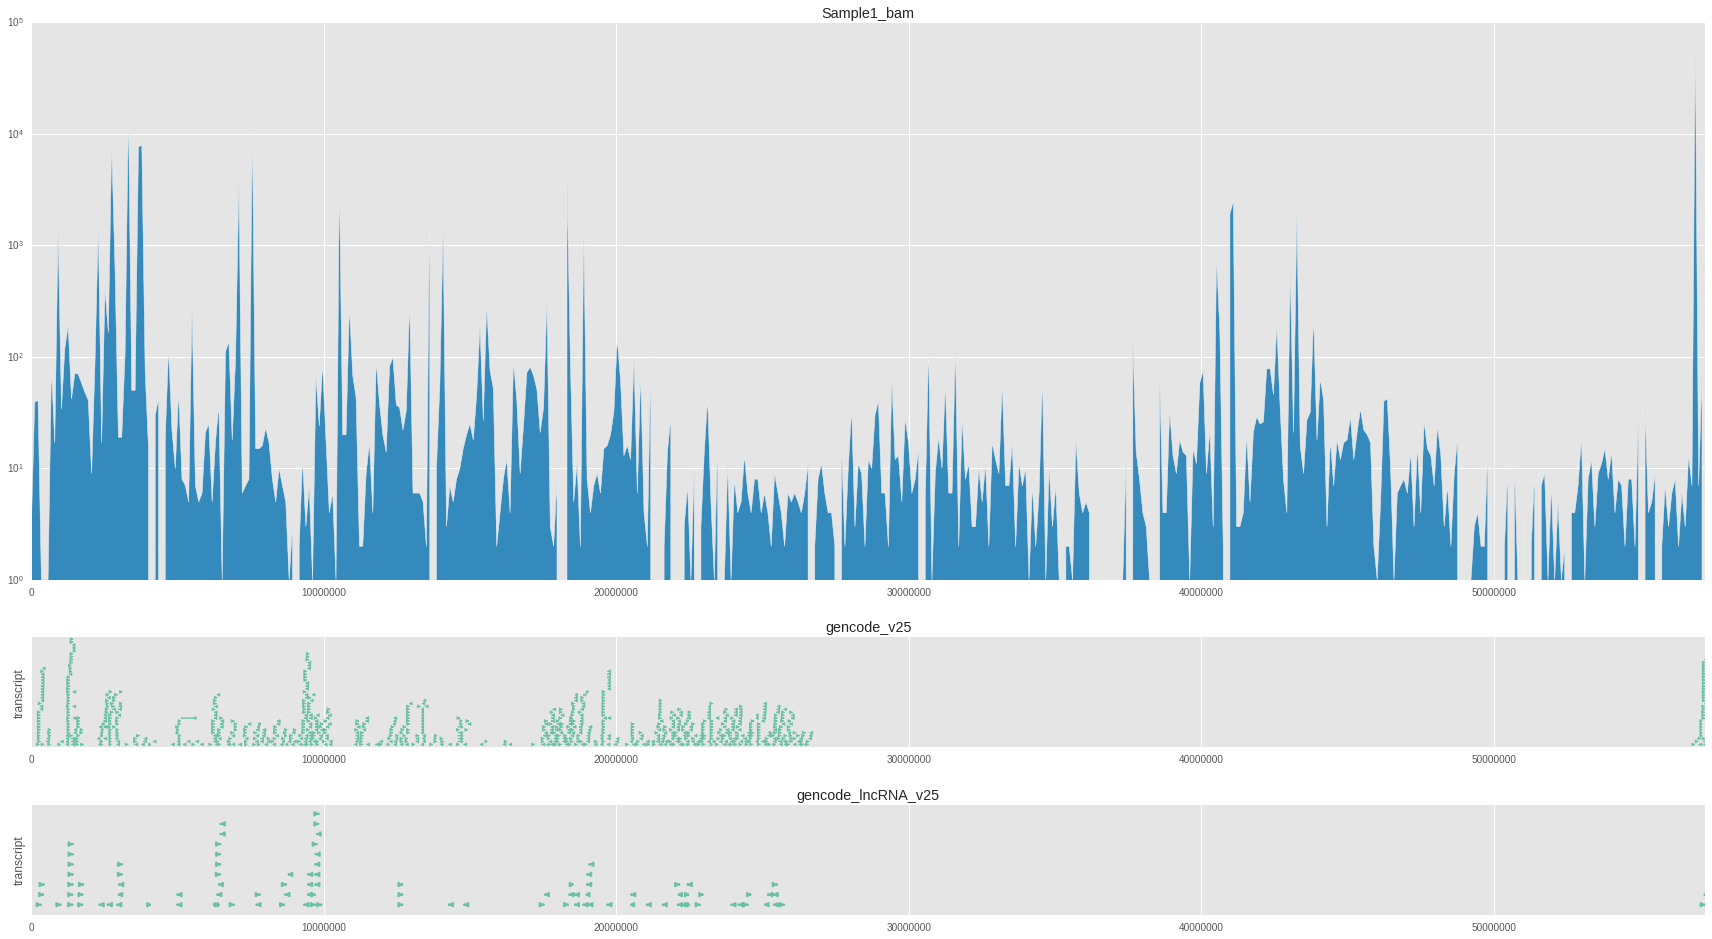

In [7]:
a.plot_interval("chrY", annotation_feature_types=["transcript"], alignment_yscale="log")

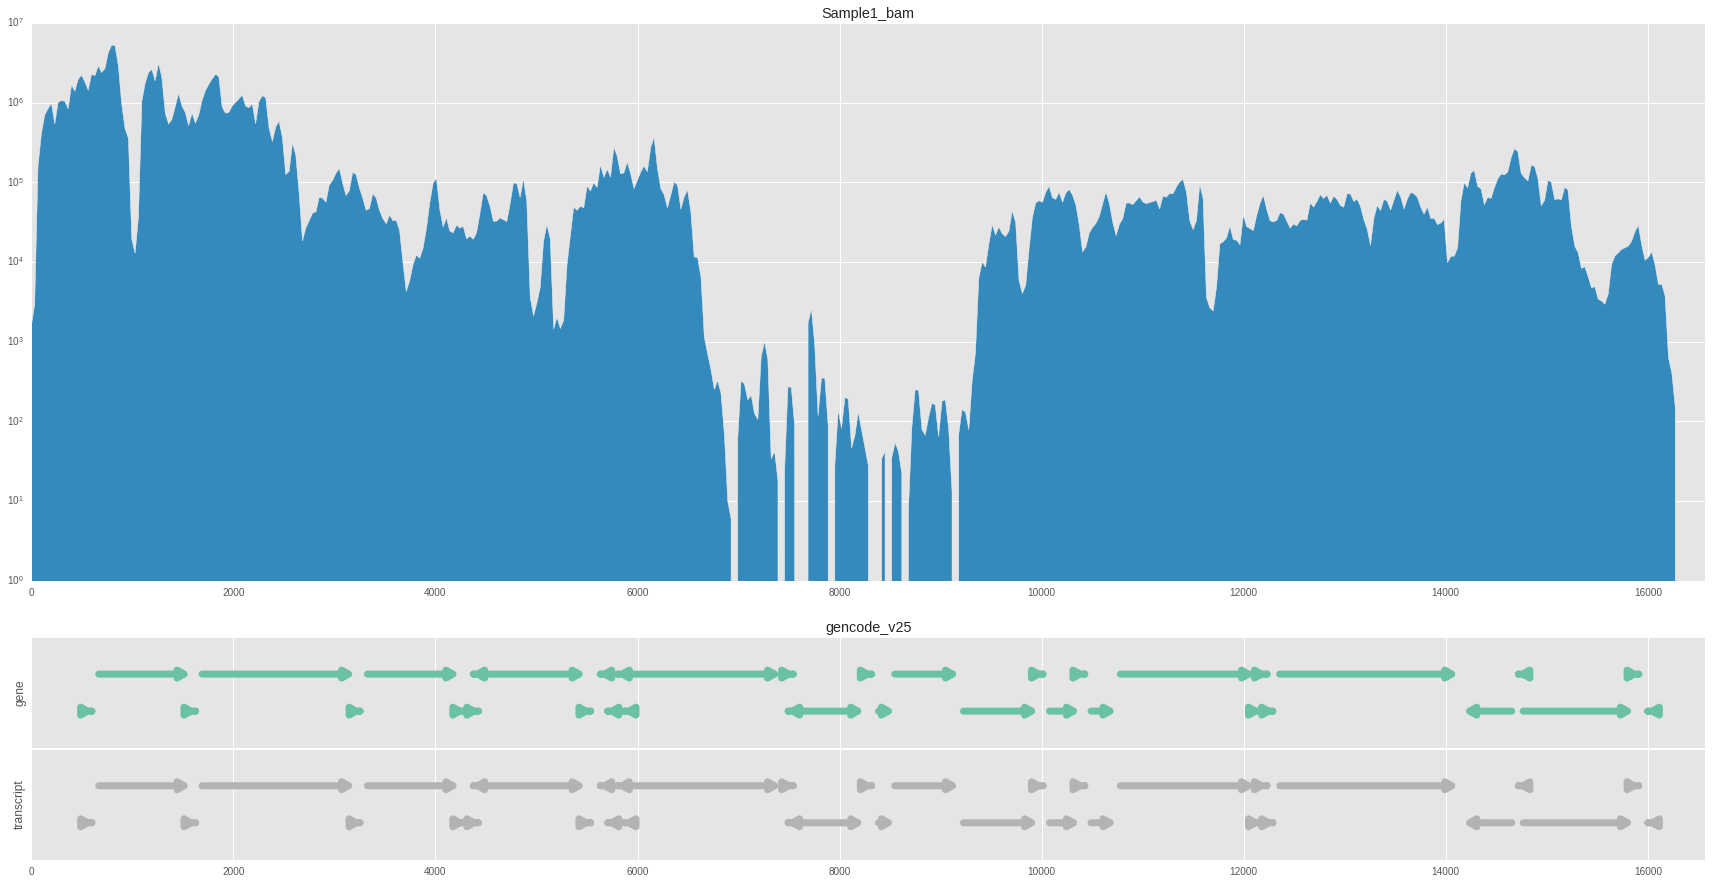

In [8]:
a.plot_interval("chrM", annotation_feature_types=["transcript", "gene"], alignment_yscale="log", annotation_tracks=["gencode_v25"])

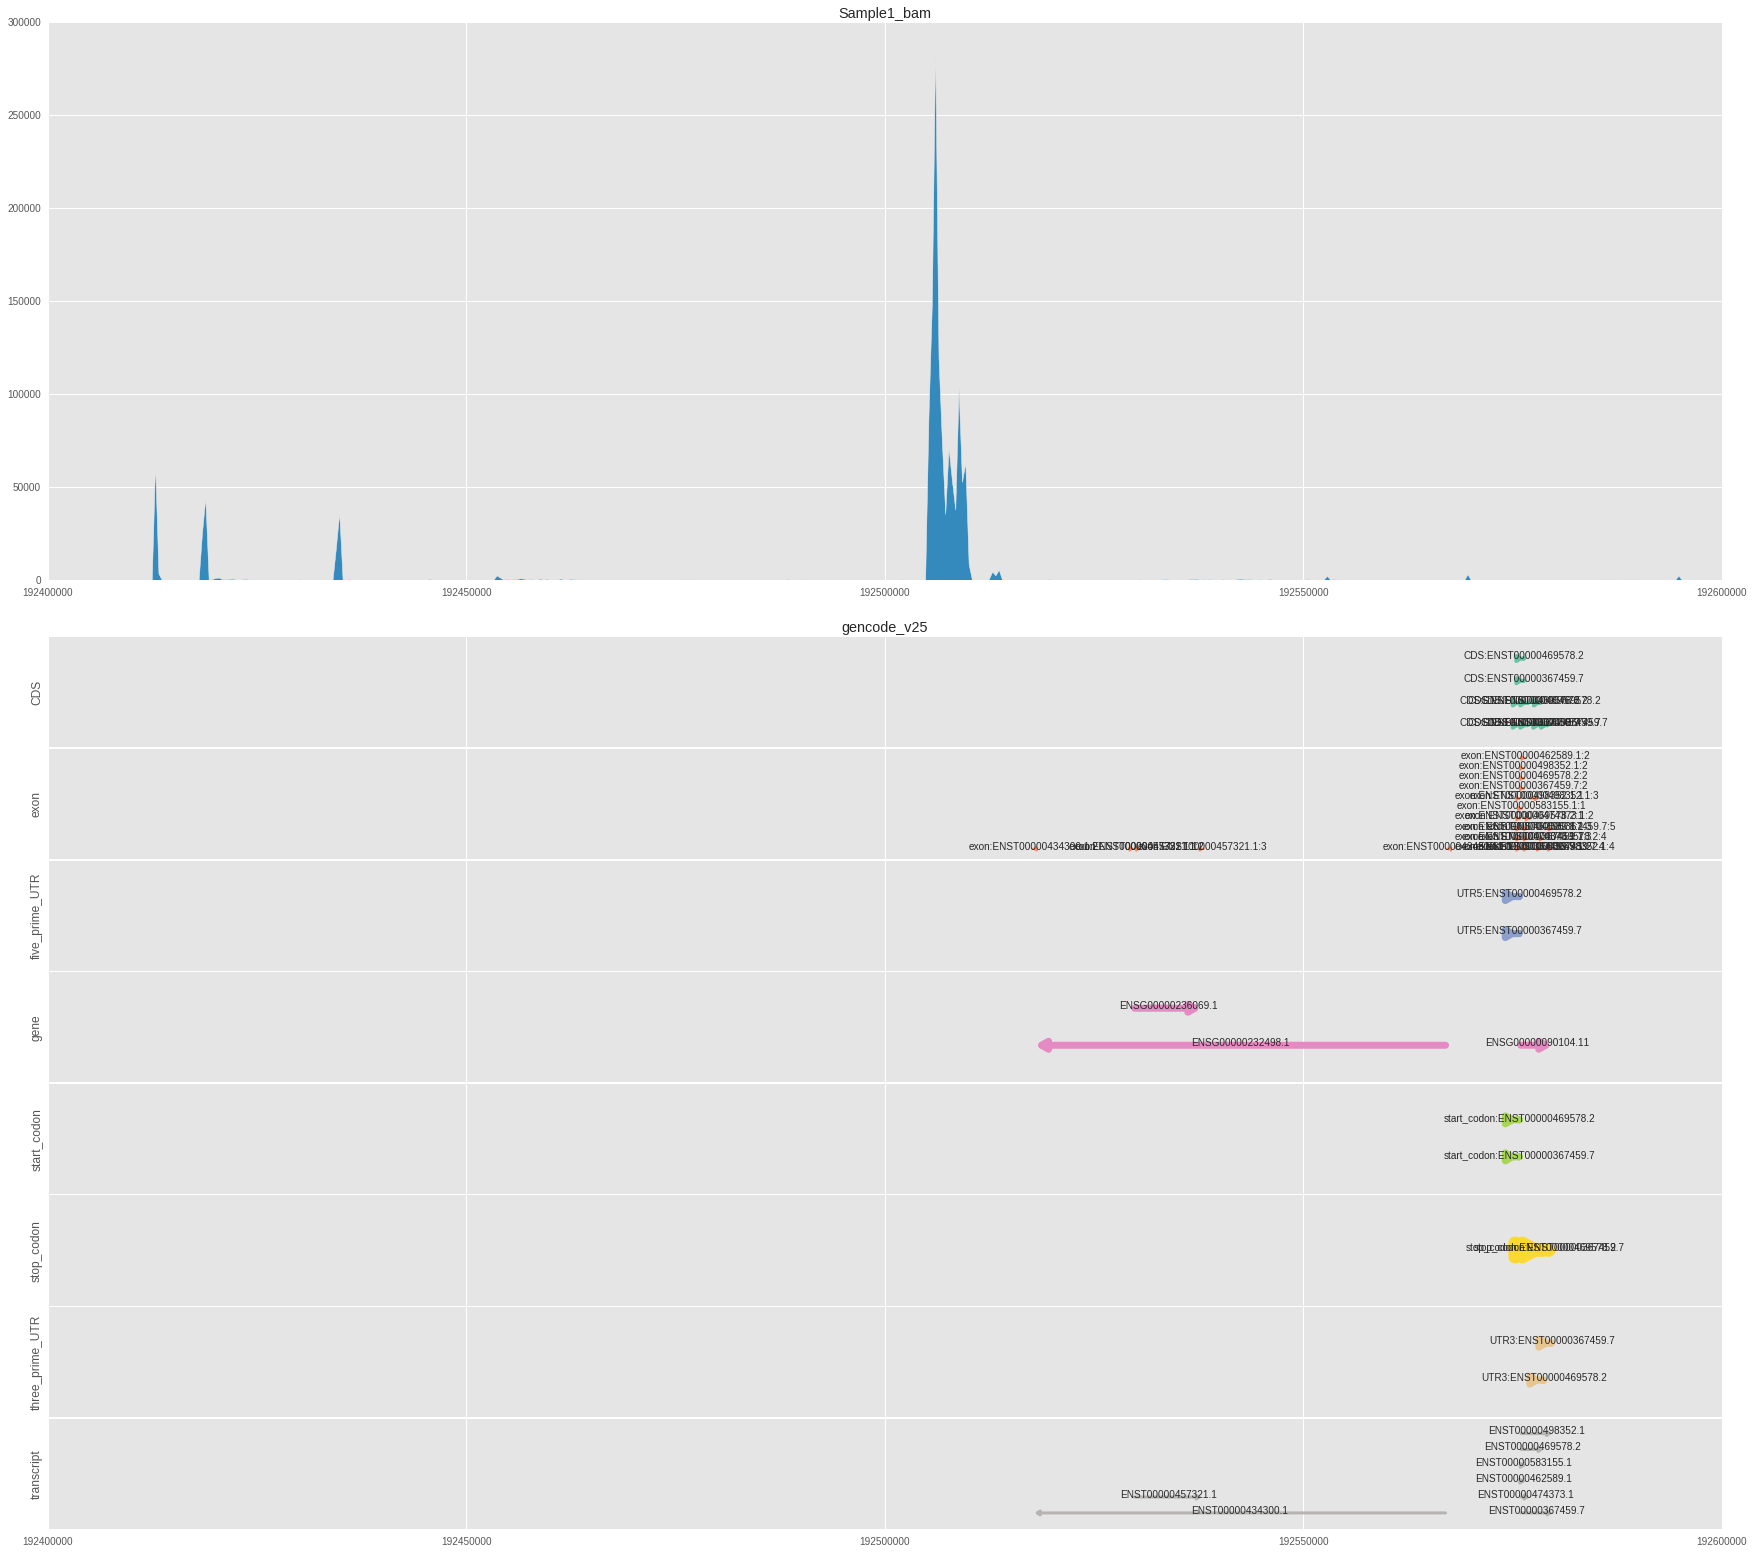

In [20]:
a.plot_interval("chr1", start=192400000, end=192600000, alignment_yscale="linear", annotation_tracks=["gencode_v25"], annotation_label=True)

In [221]:
def sliding_window_list (start=0, end=1000, n_sliding_windows=200, plot=False, plot_style="ggplot"):
    """
    slide window overlap of 50%
    """
    
    # Compute the size of overlapping windows 
    bin_size = (end-start)/(n_sliding_windows+1)*2
    
    # Ploting only option
    if plot:
        pl.style.use(plot_style)
        figure, subplot = pl.subplots(figsize=(30, 5), frameon=False)
        subplot.set_xlim((start, end))
        subplot.set_ylim((0, n_sliding_windows+1))
        for i in range(n_sliding_windows):
            subplot.add_patch(arrow (posA=[start,i+1], posB=[start+bin_size,i+1],
                              linewidth=12/n_sliding_windows+1, edgecolor="black", facecolor="black"))
            start+=bin_size/2
    
    # listing only option
    else:
        windows_list=[]
        for i in range(n_sliding_windows):
            windows_list.append([start, start+bin_size])
            start+=bin_size/2
        return (windows_list)

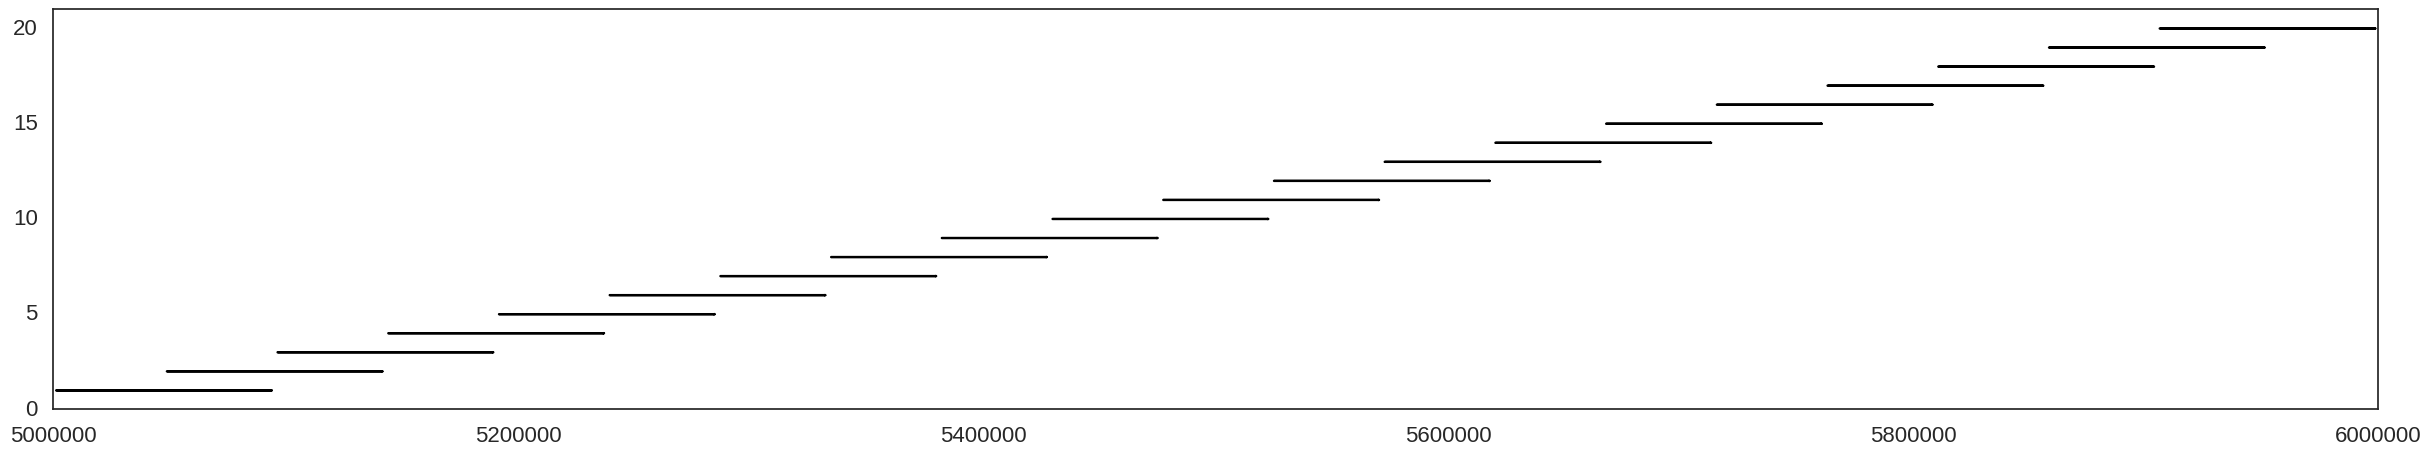

In [244]:
sliding_window_list(5000000, 6000000, 20, True, "seaborn-white")

In [144]:
sliding_window_list(10000, 20000, 20, False)

[[10000, 10952.380952380952],
 [10476.190476190477, 11428.57142857143],
 [10952.380952380954, 11904.761904761906],
 [11428.571428571431, 12380.952380952383],
 [11904.761904761908, 12857.14285714286],
 [12380.952380952385, 13333.333333333338],
 [12857.142857142862, 13809.523809523815],
 [13333.33333333334, 14285.714285714292],
 [13809.523809523816, 14761.904761904769],
 [14285.714285714294, 15238.095238095246],
 [14761.90476190477, 15714.285714285723],
 [15238.095238095248, 16190.4761904762],
 [15714.285714285725, 16666.66666666668],
 [16190.476190476202, 17142.857142857156],
 [16666.66666666668, 17619.047619047633],
 [17142.857142857156, 18095.23809523811],
 [17619.047619047633, 18571.428571428587],
 [18095.23809523811, 19047.619047619064],
 [18571.428571428587, 19523.80952380954],
 [19047.619047619064, 20000.00000000002]]

In [58]:
def plot_alignment (fp, seqid, start=0, end=100000, n_step=500, yscale="linear", plot_style="ggplot", force_mode=None, track_height=10, track_width=30):
    """
    * force_mode None or "read_count" or "base_coverage"
    """
    x = []
    y = []
    len_range = end-start
    step_size = (end-start) / float(n_step)
    
    # Count method is less accurate but much quicker for very long intervals.
    # Do not take into account spliced sites, ie read will be represented from their first mapped
    # to their last base
    if force_mode == "read_count" or (not force_mode and len_range > 5000000):
        start_pos = start
        with pysam.AlignmentFile(fp) as bam:
            for i in range(n_step):
                
                x.append(start_pos+step_size/2)
                y.append(bam.count(seqid, start_pos, start_pos+step_size))
                
                start_pos+=step_size
    
    # Coverage method is more precise and quicker for smaller intervals but become really slow when > 5000000
    elif force_mode == "base_coverage" or (not force_mode and len_range <= 5000000):
        with pysam.AlignmentFile(fp) as bam:
            mat = bam.count_coverage(seqid, start, end)
            start_pos = 0
            while start_pos <= len_range-step_size:            
                s = round(start_pos)
                e = round(start_pos+step_size)
                
                x.append(start+start_pos)
                y.append(sum(mat[0][s:e])+sum(mat[1][s:e])+sum(mat[2][s:e])+sum(mat[3][s:e]))
                
                start_pos+=step_size
                
    pl.style.use(plot_style)
    figure, subplot = pl.subplots(figsize=(track_width, track_height))
    subplot.set_xlim((start, end))
    
    if yscale == "log":
        if any(y) <= 0:
            warnings.warn("Data has no positive values, and therefore can not be log-scaled.")
        else:
            subplot.set_yscale("log")
    
    subplot.fill_between(x, 0, y)

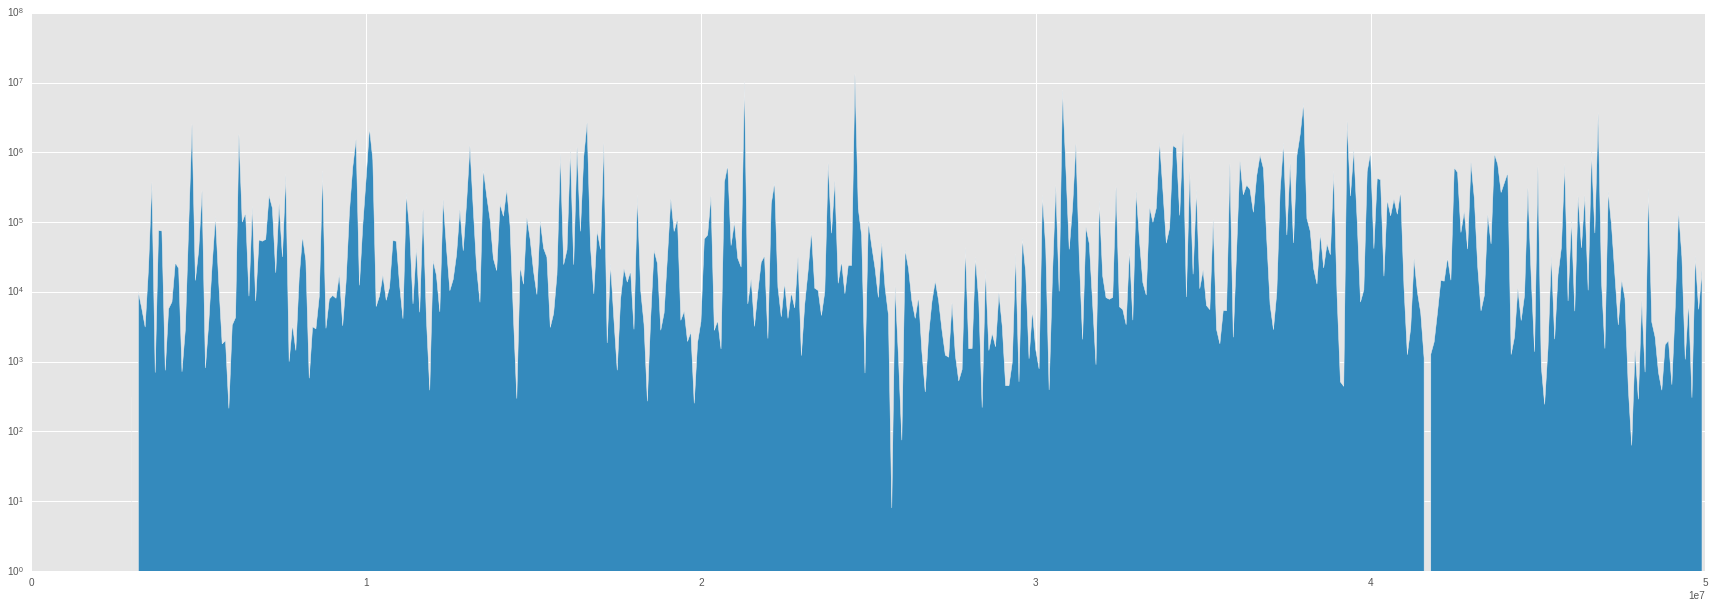

In [61]:
b = "./test_data/out.bam"
plot_alignment(fp=b, seqid="chr1", start=0, end=50000000, n_step=500, yscale="log", force_mode="base_coverage")

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Container object of 9 artists>

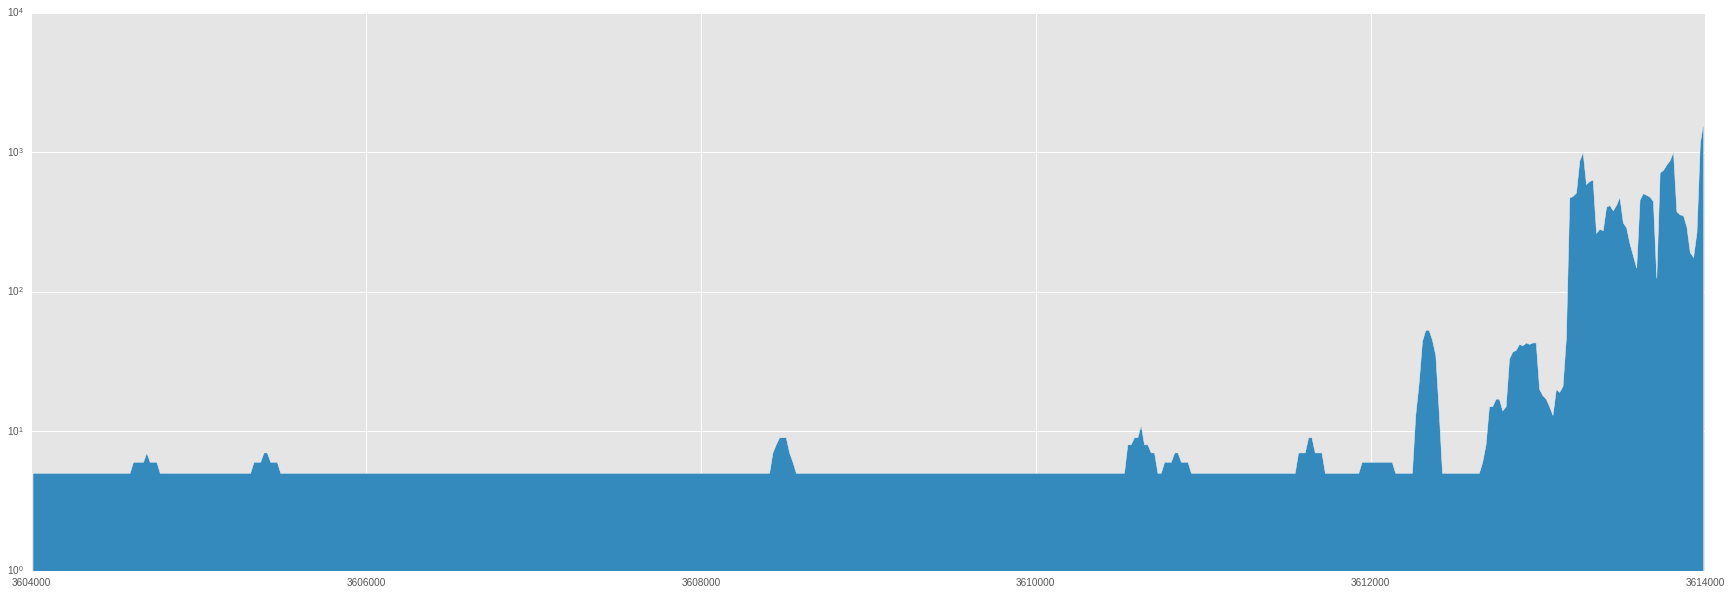

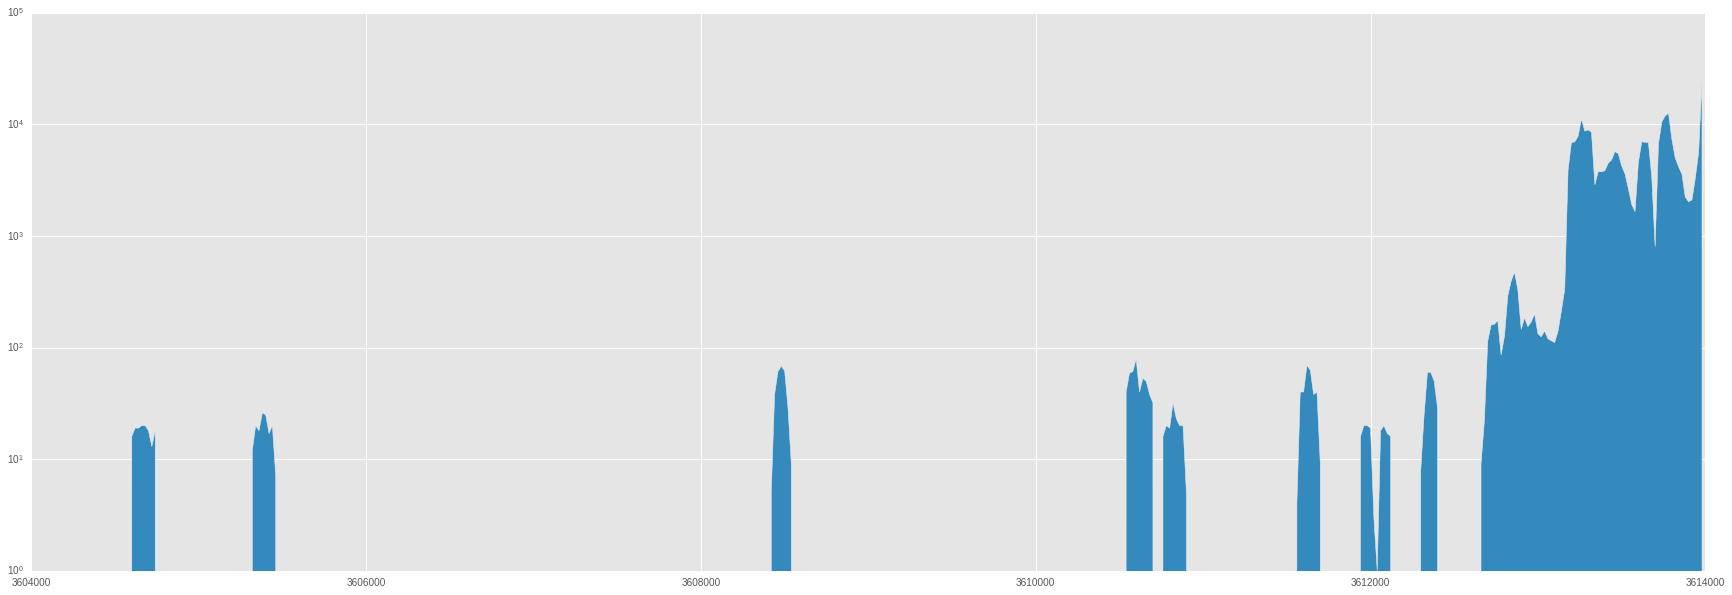

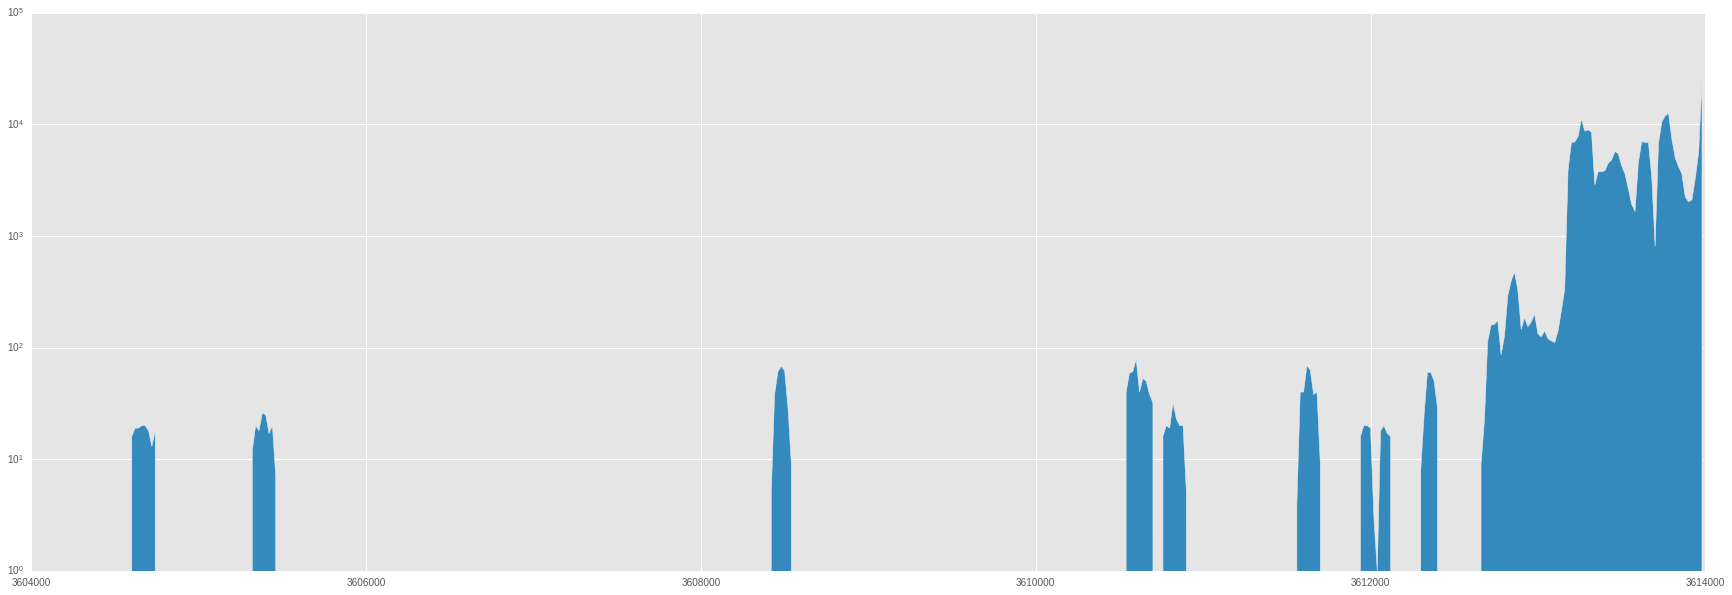

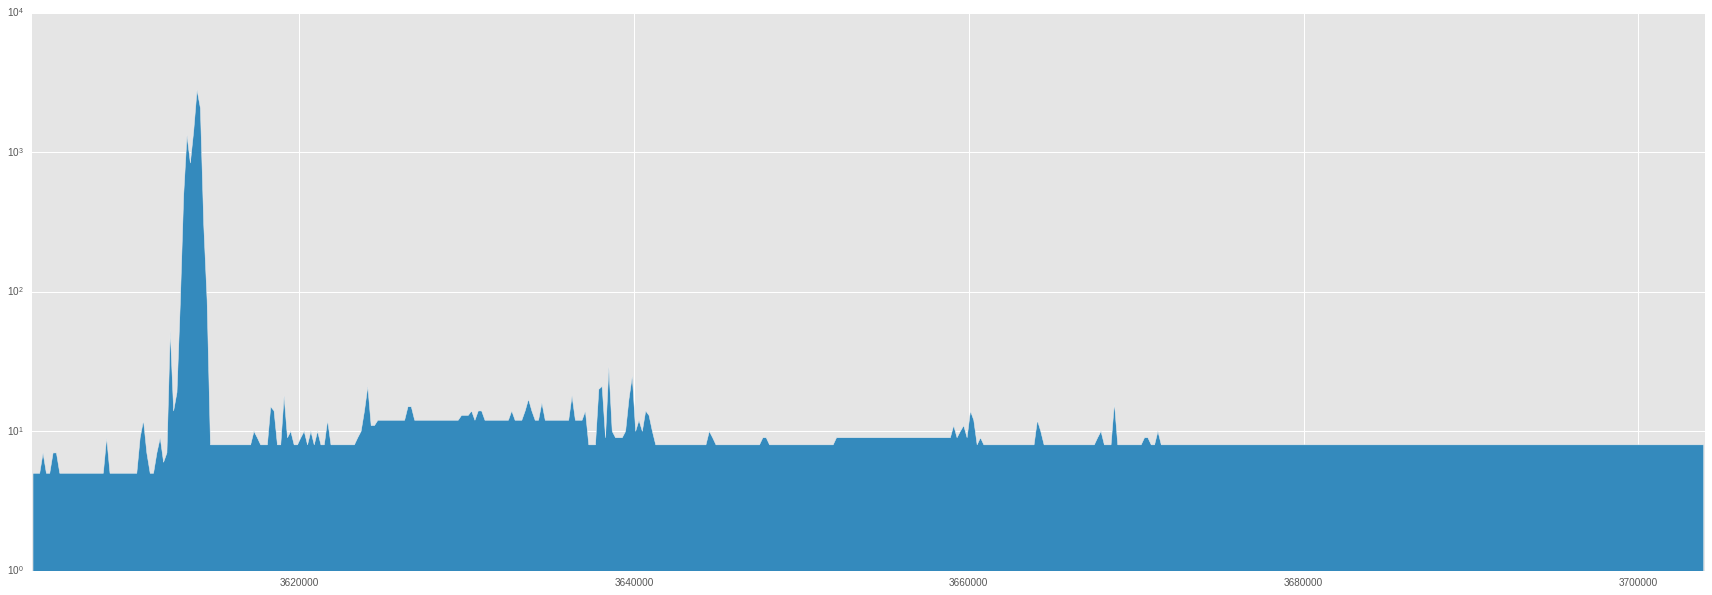

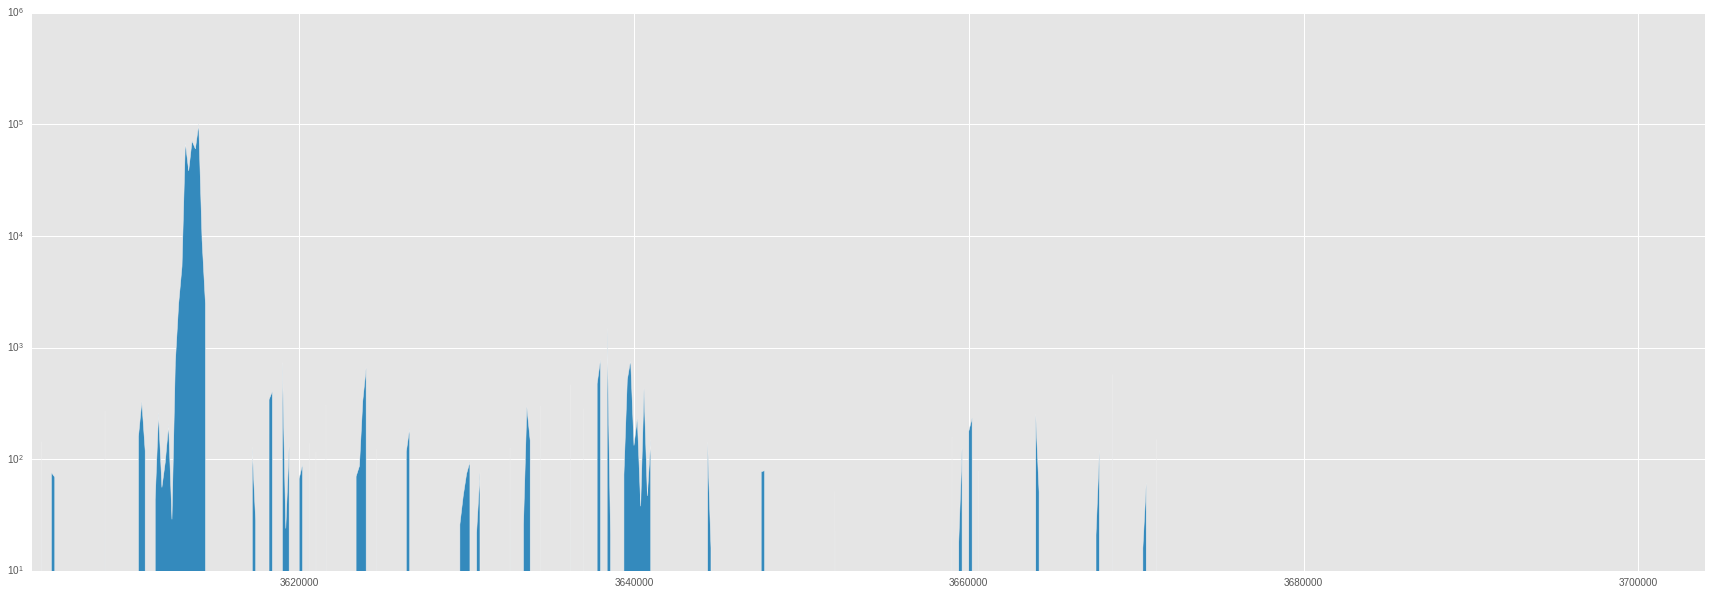

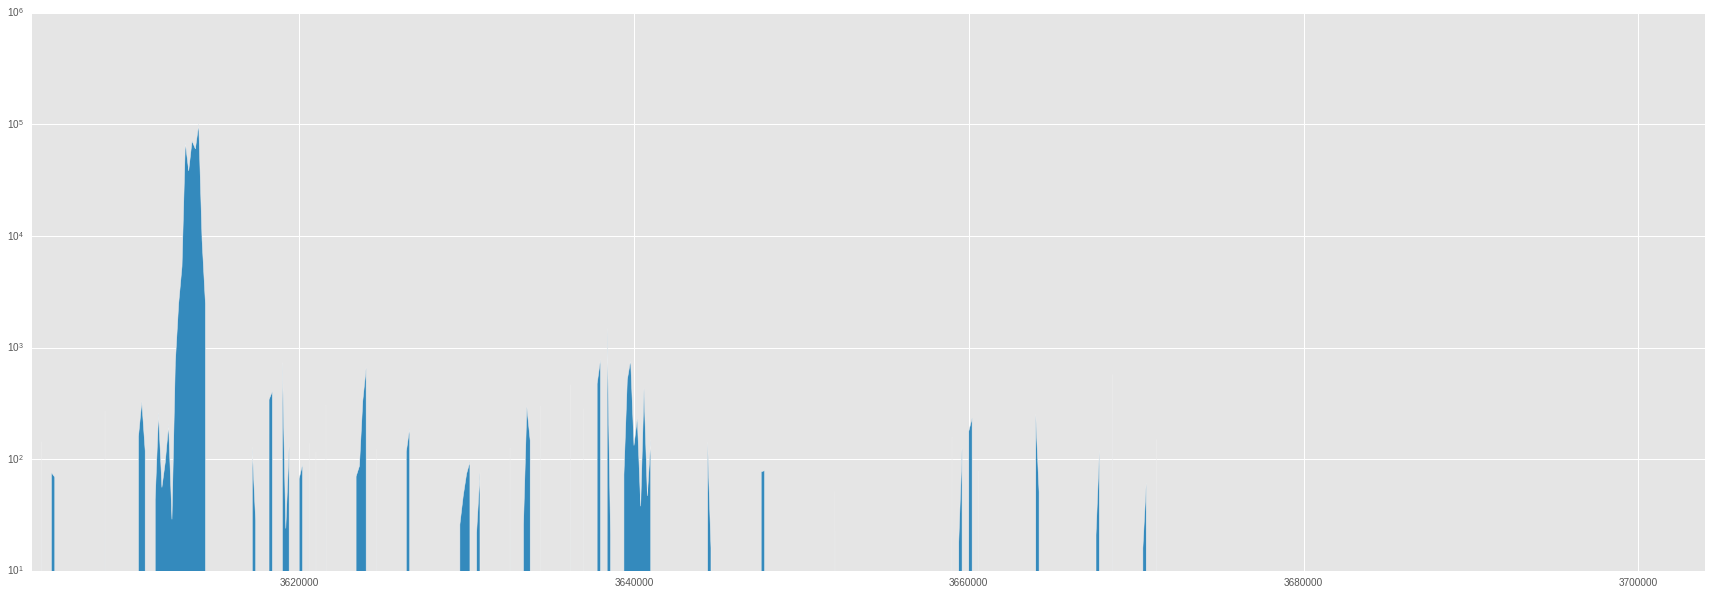

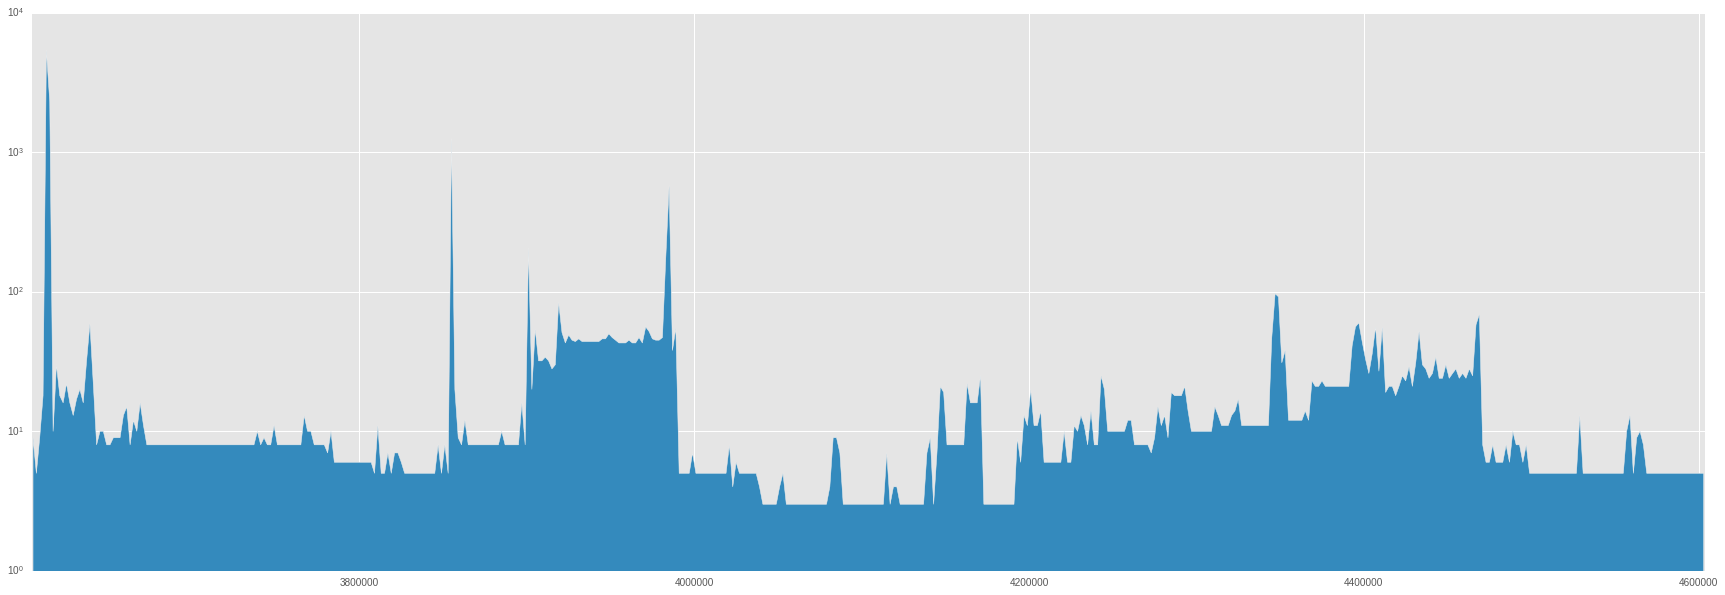

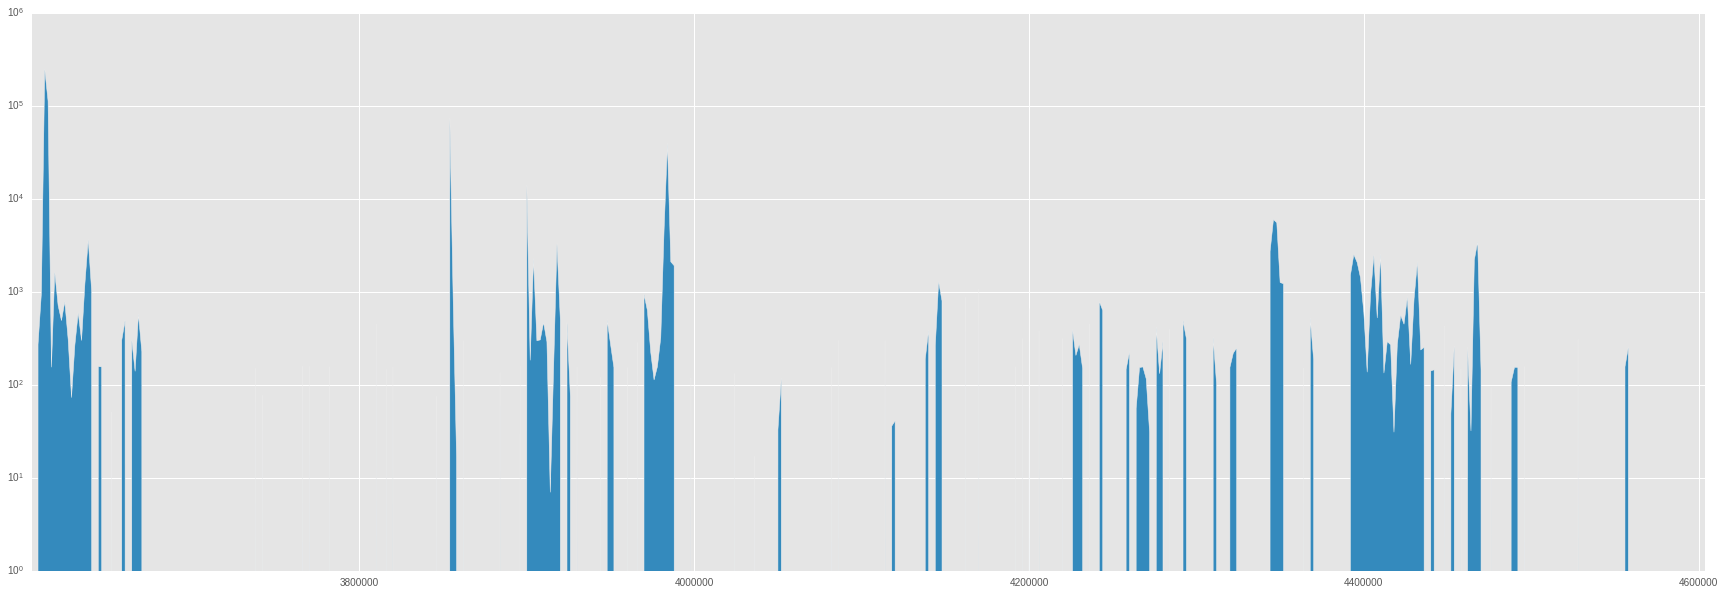

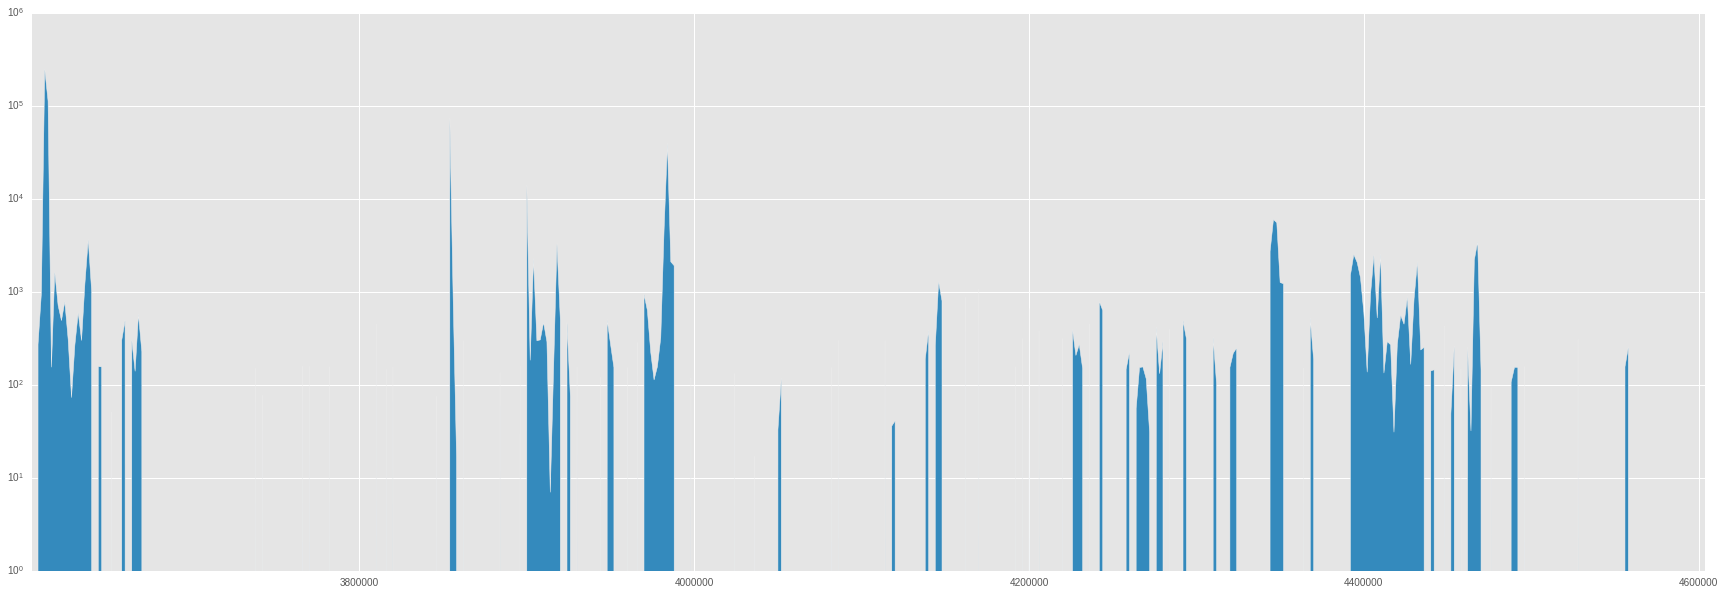

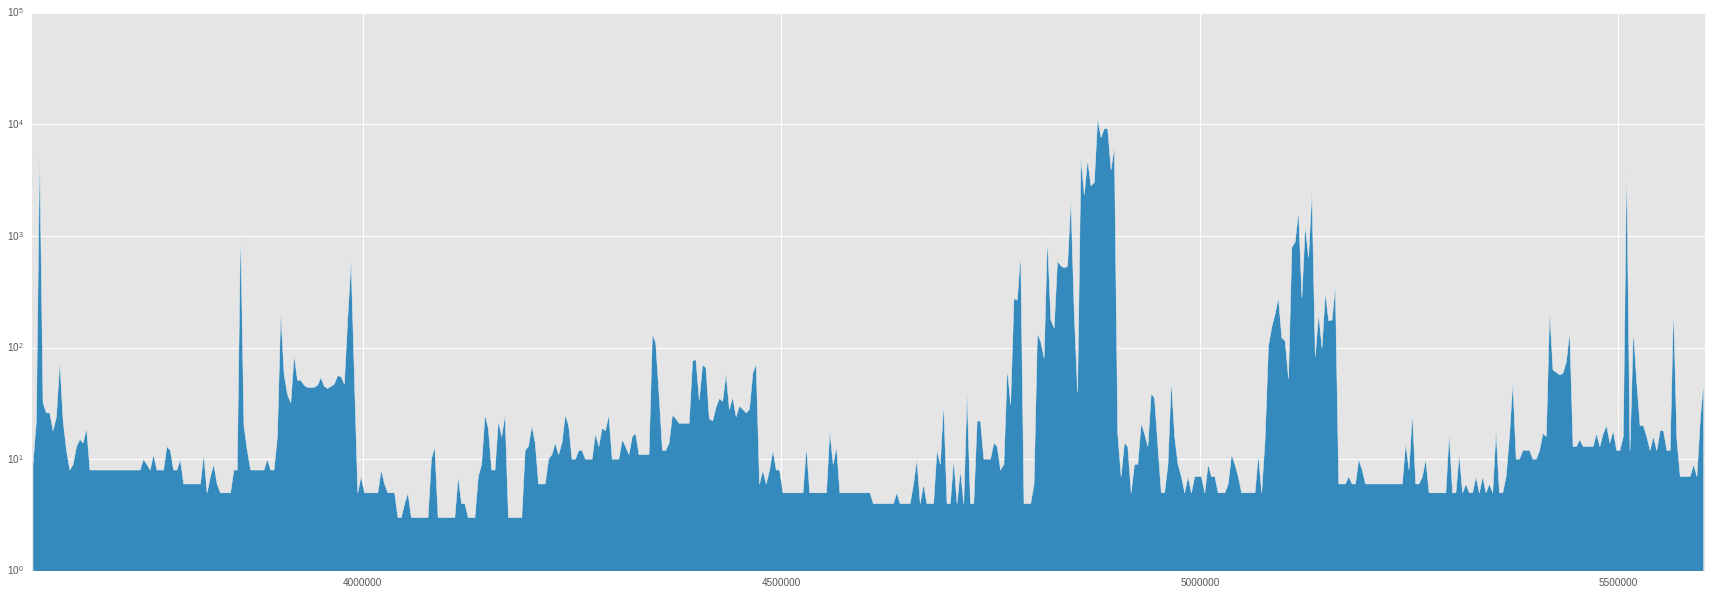

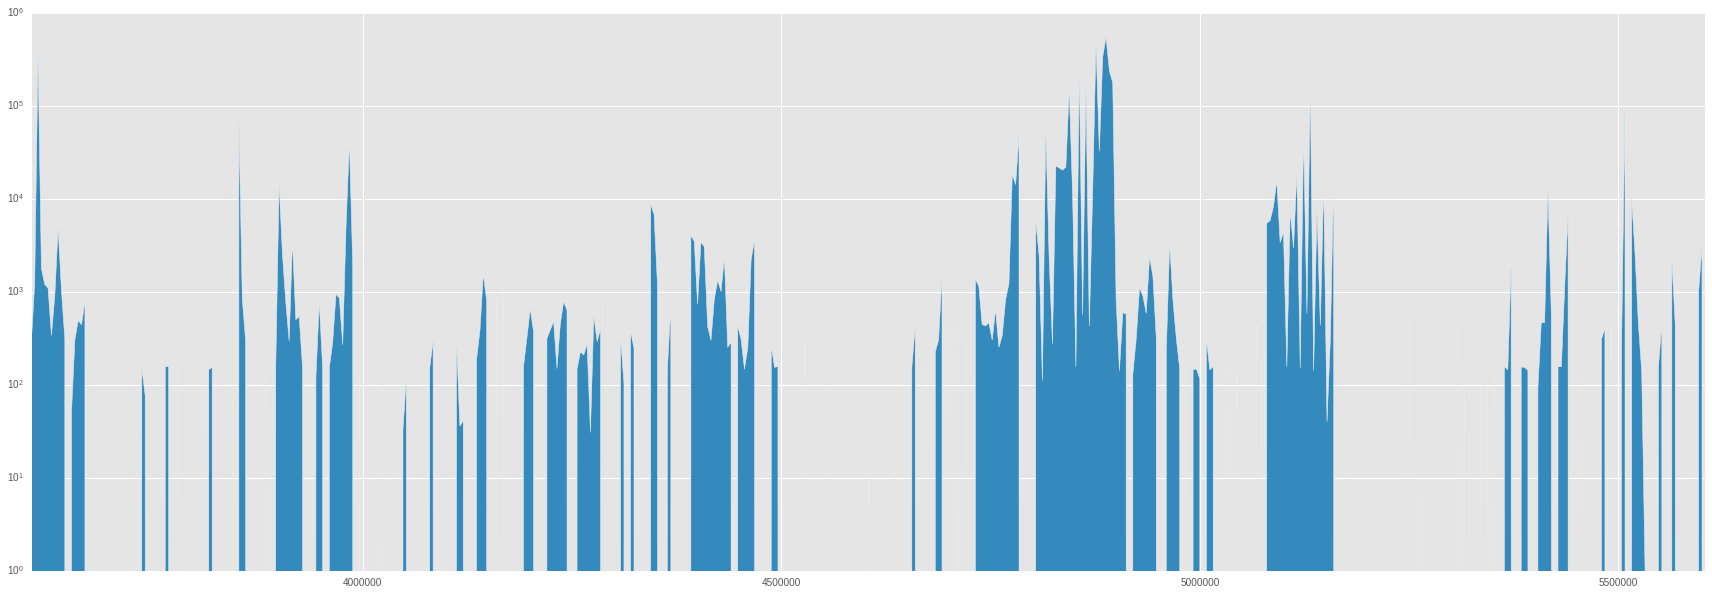

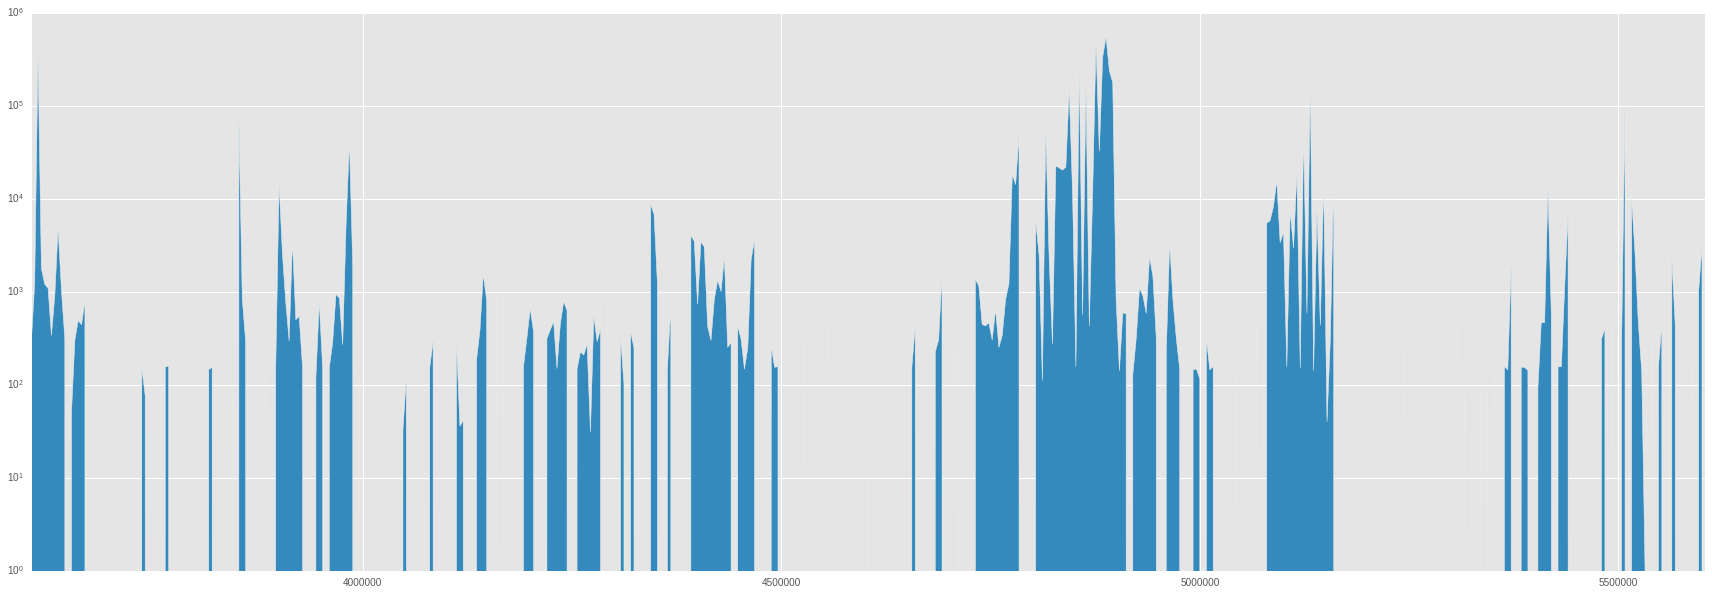

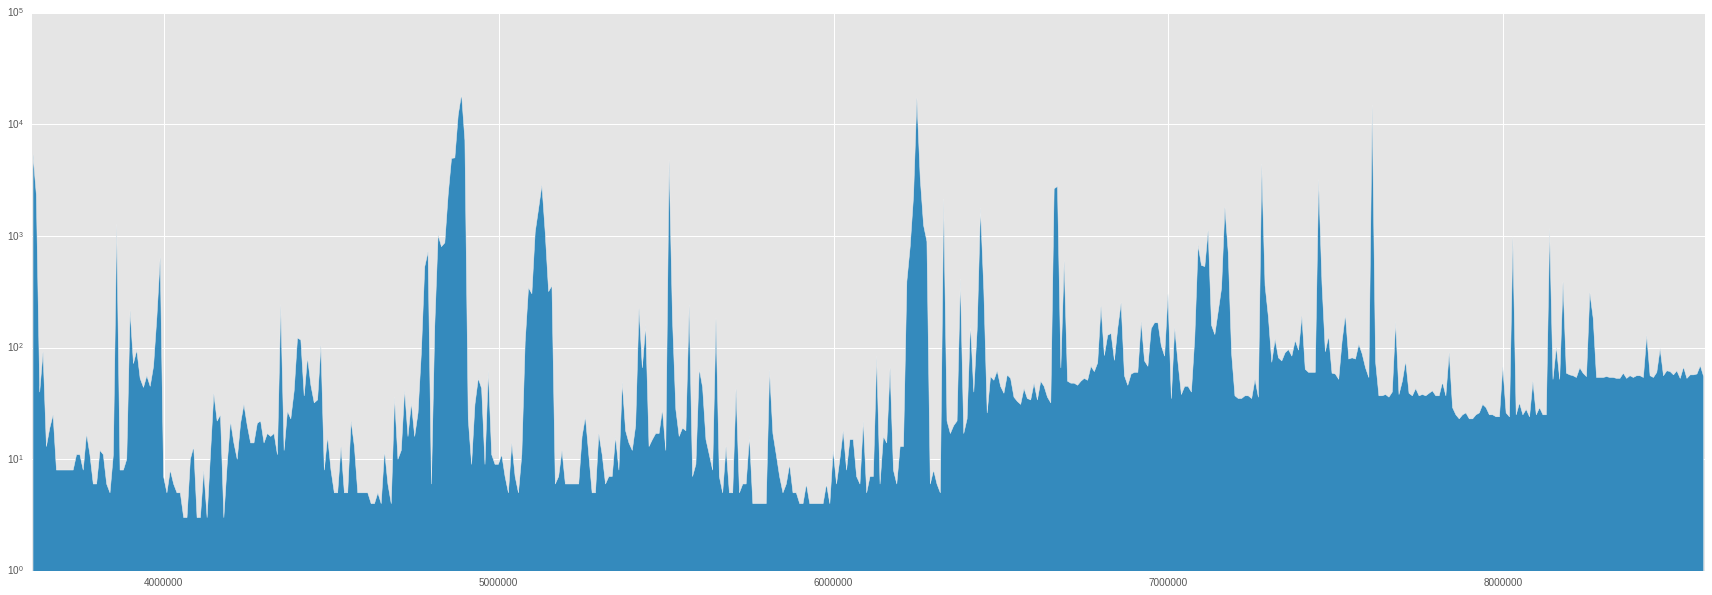

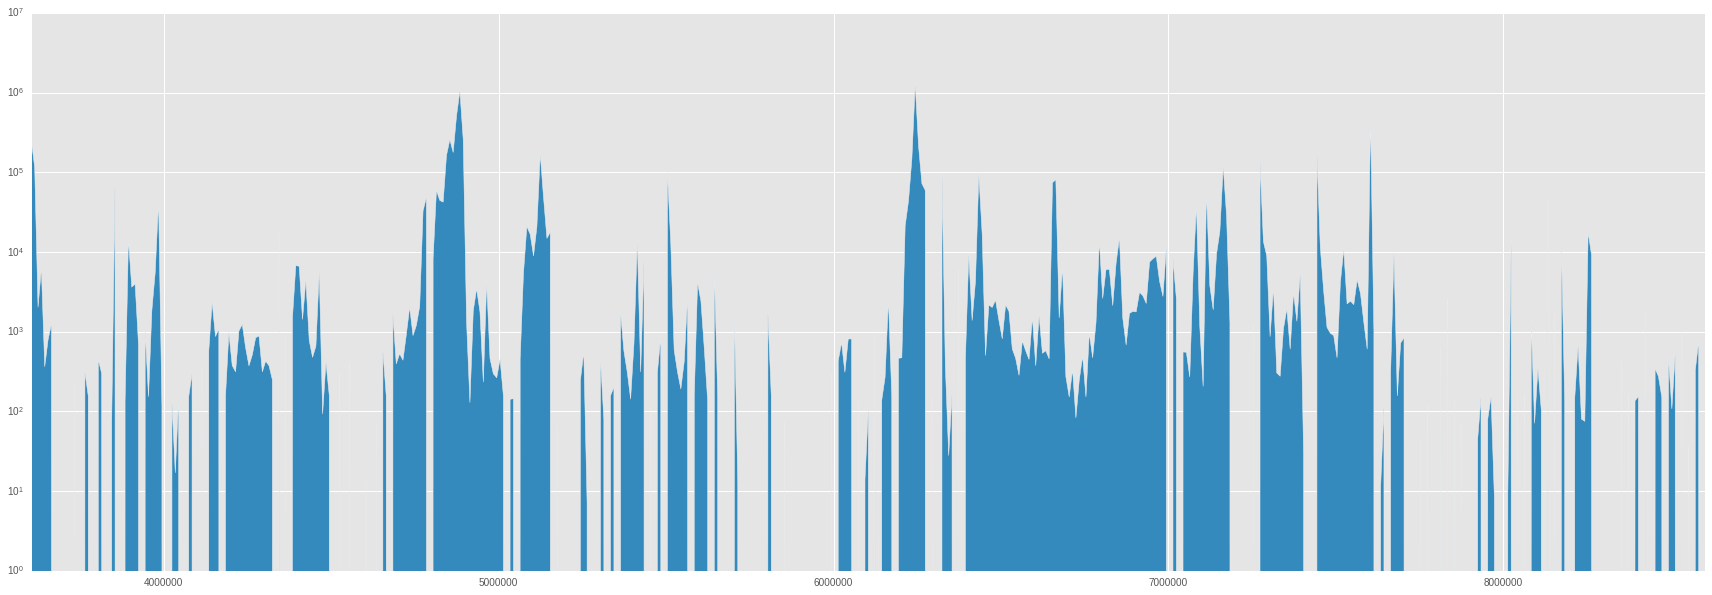

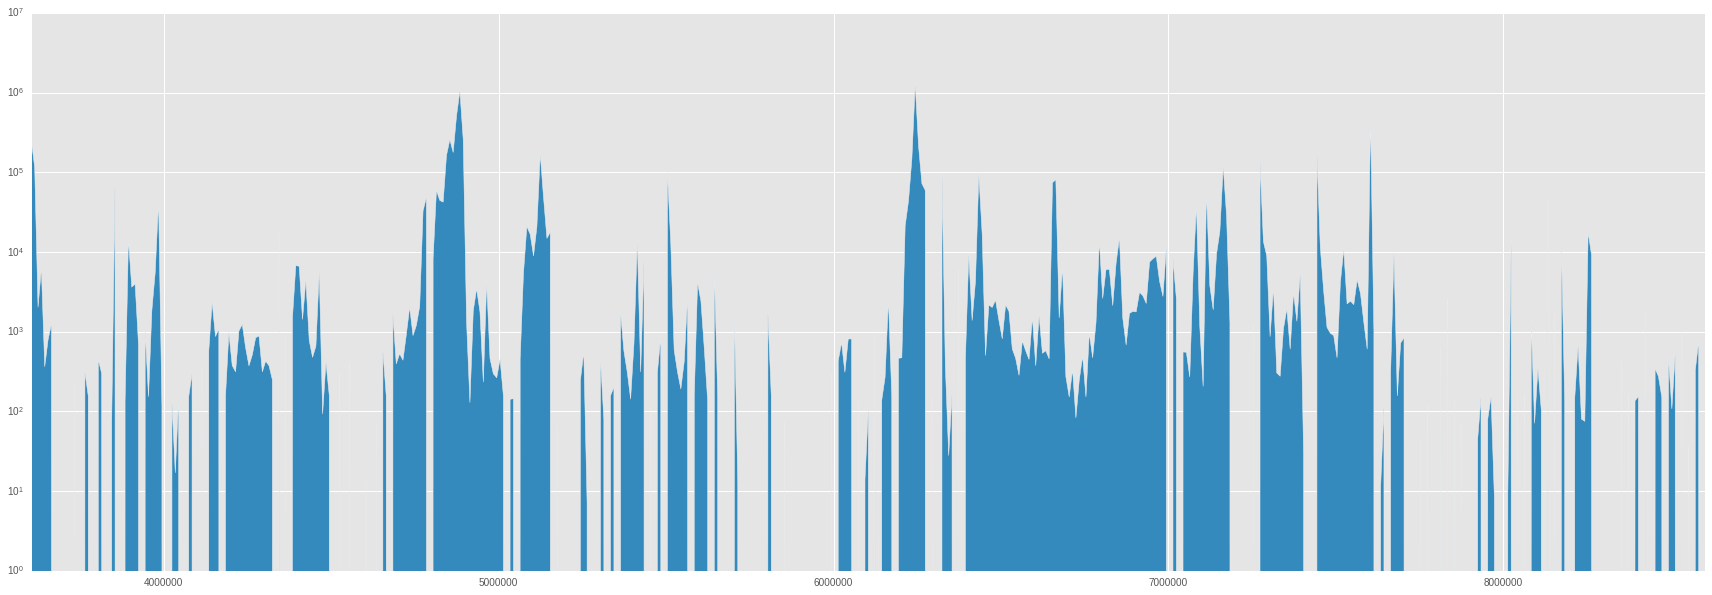

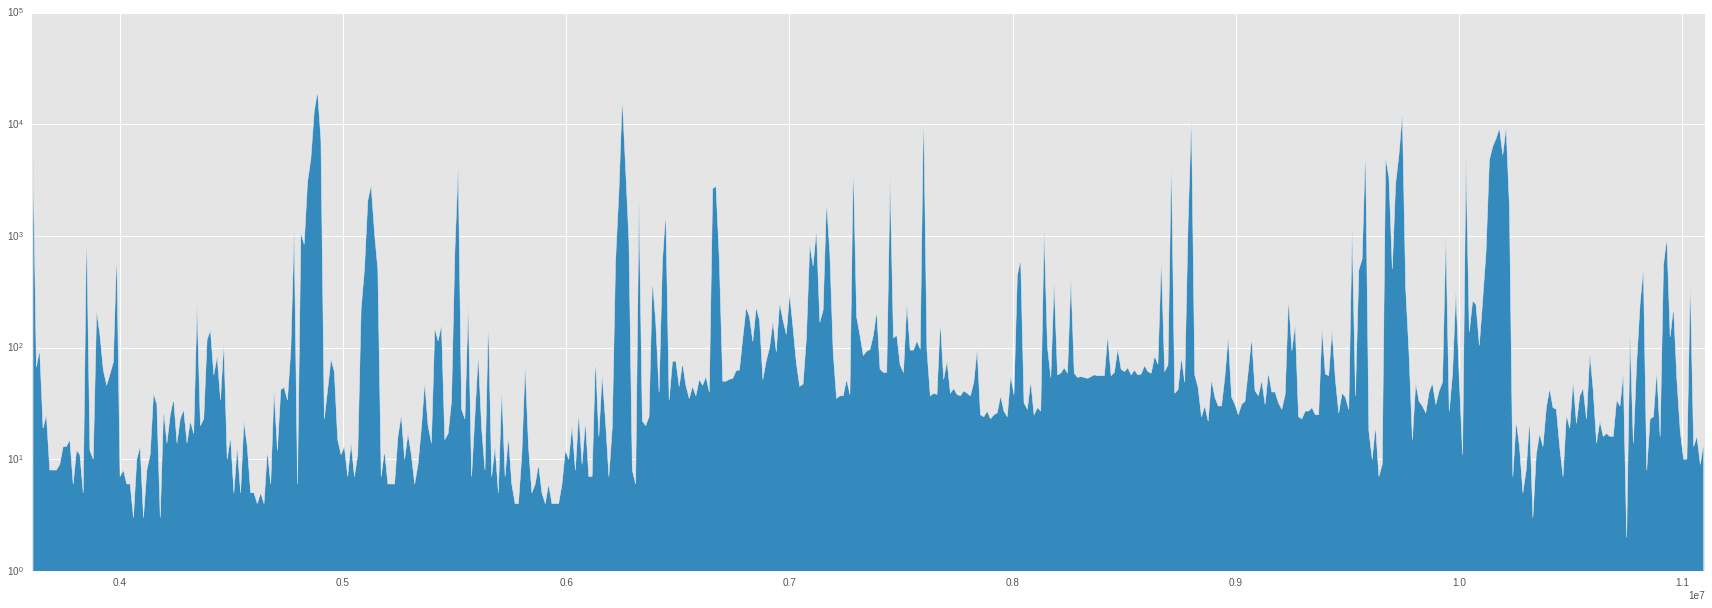

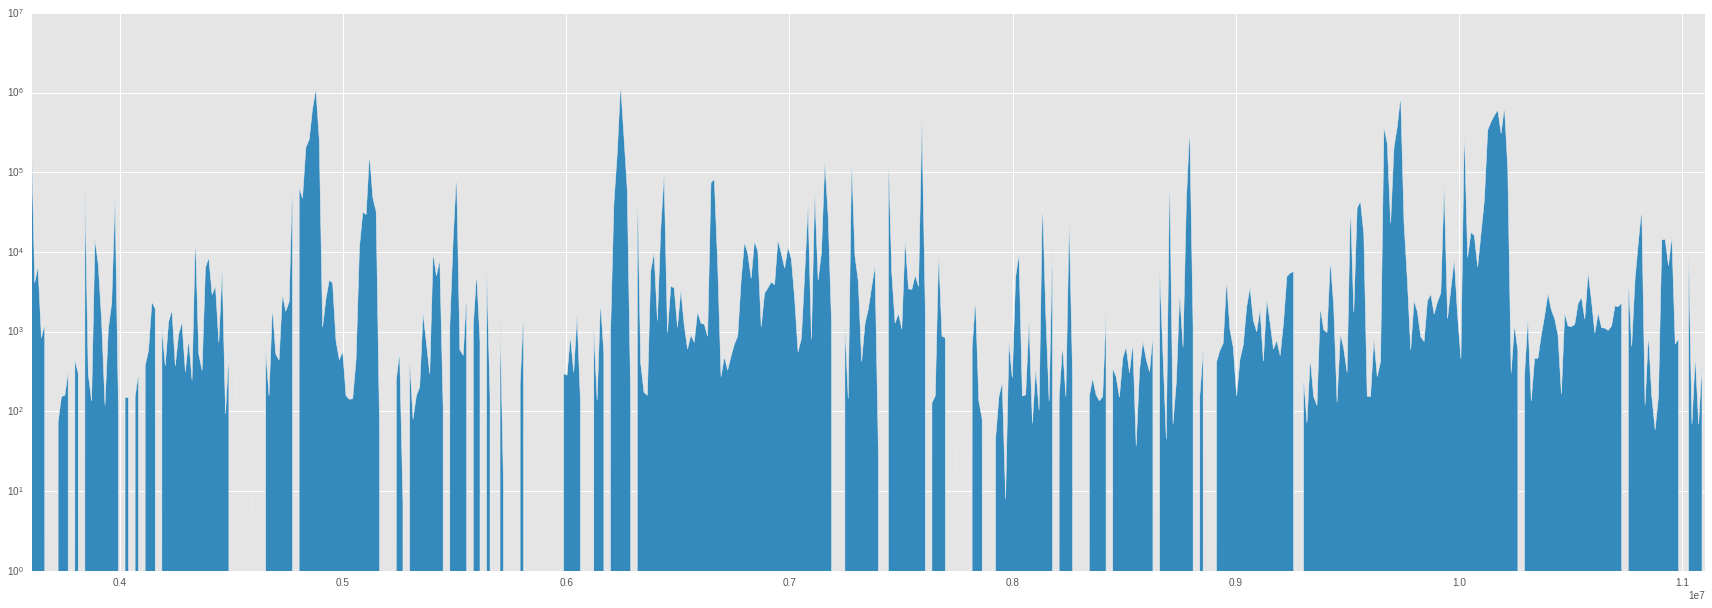

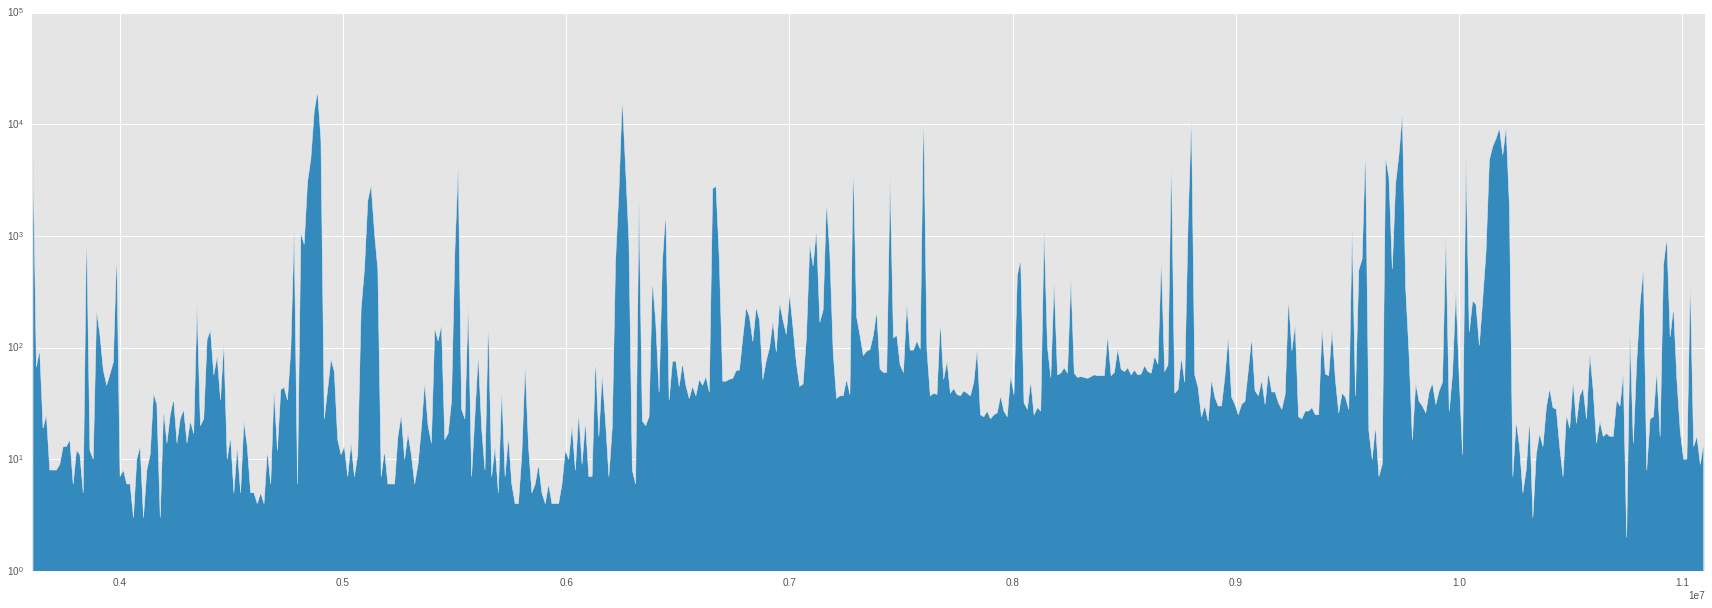

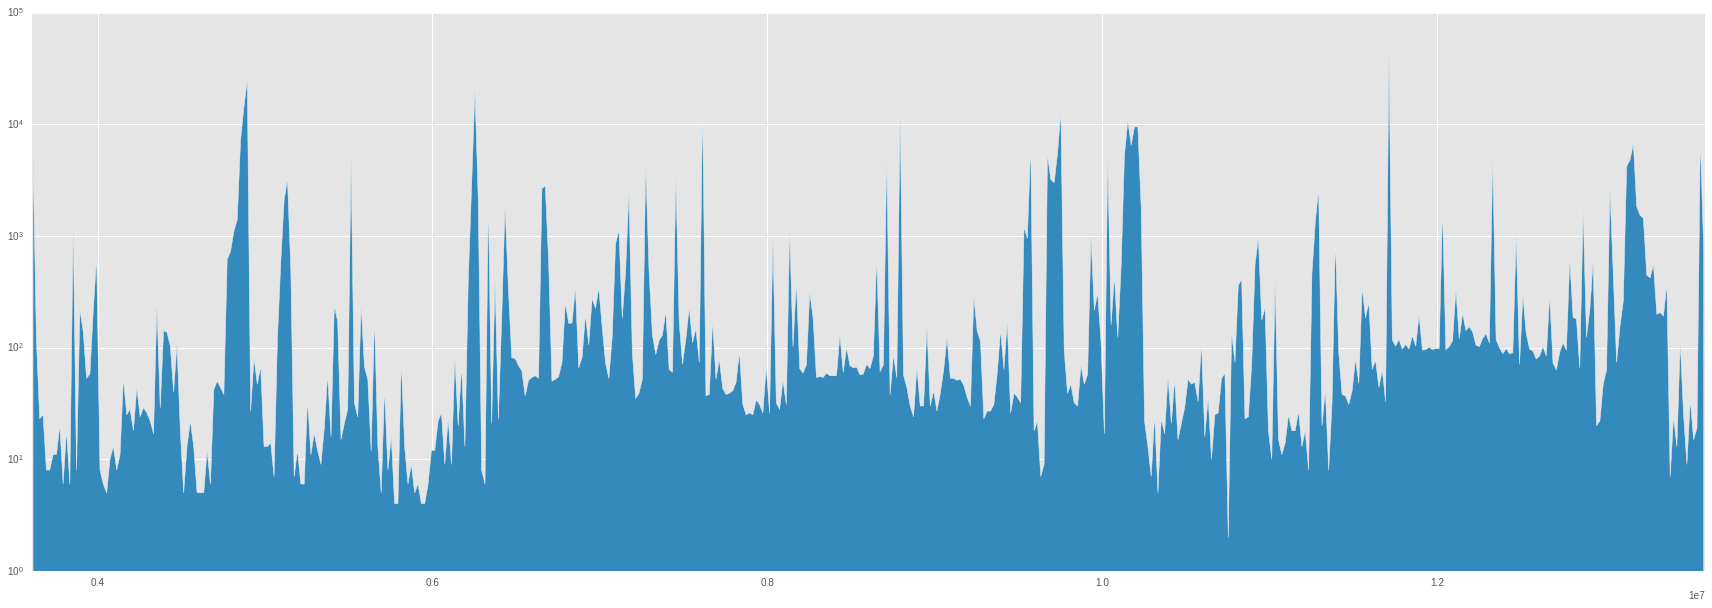

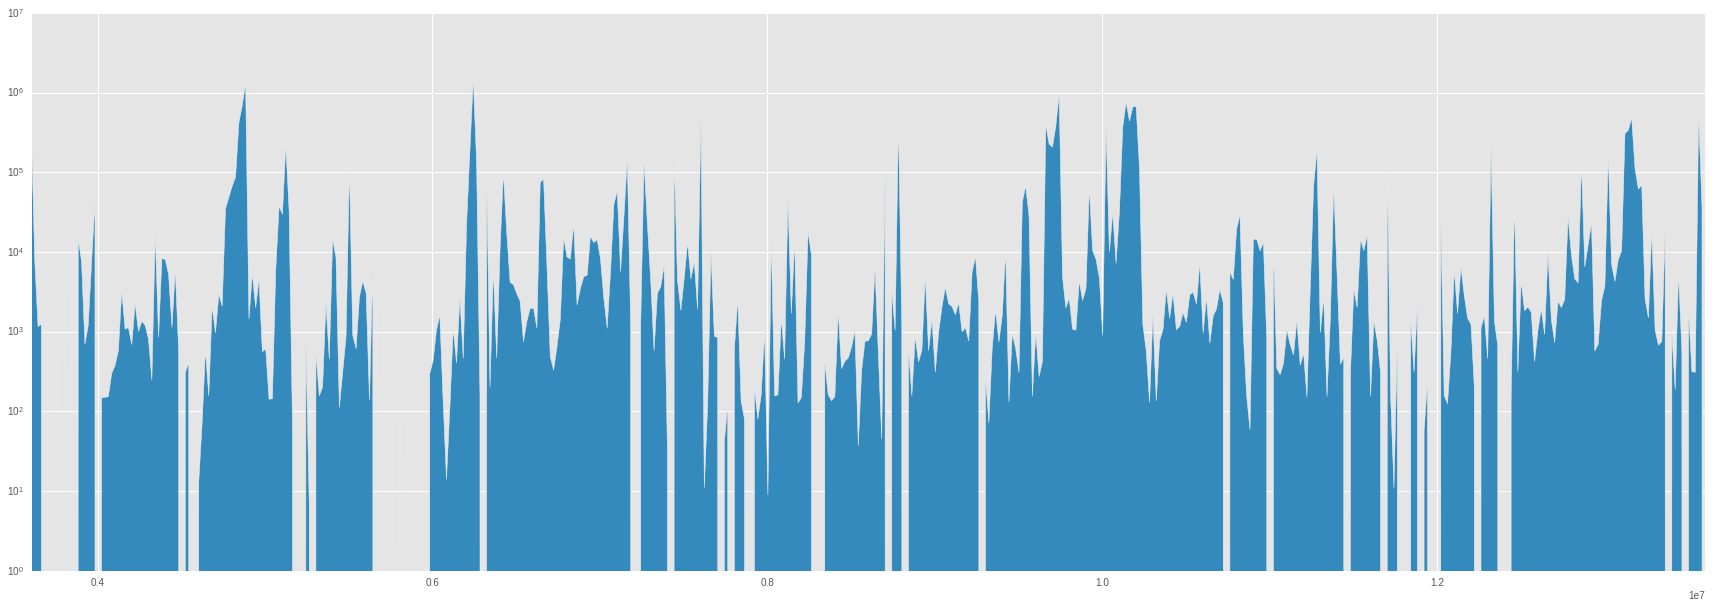

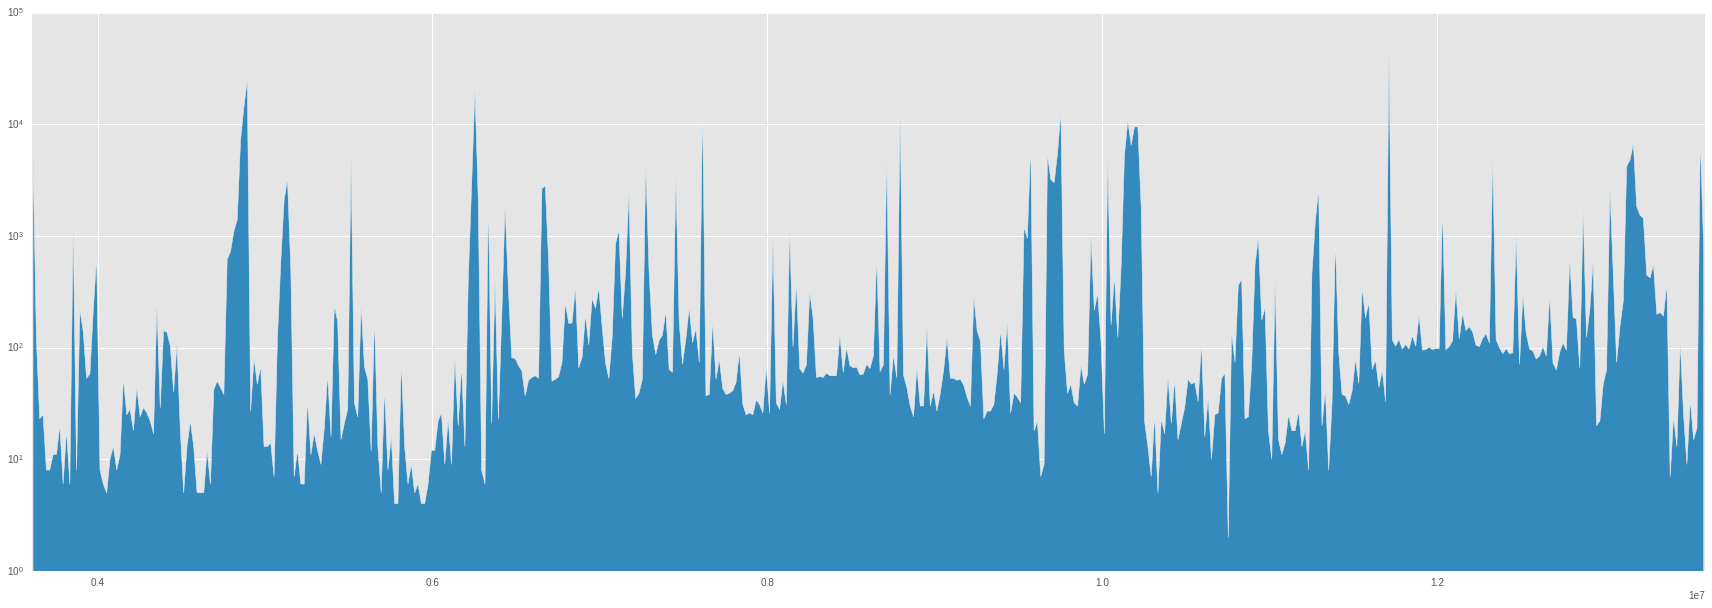

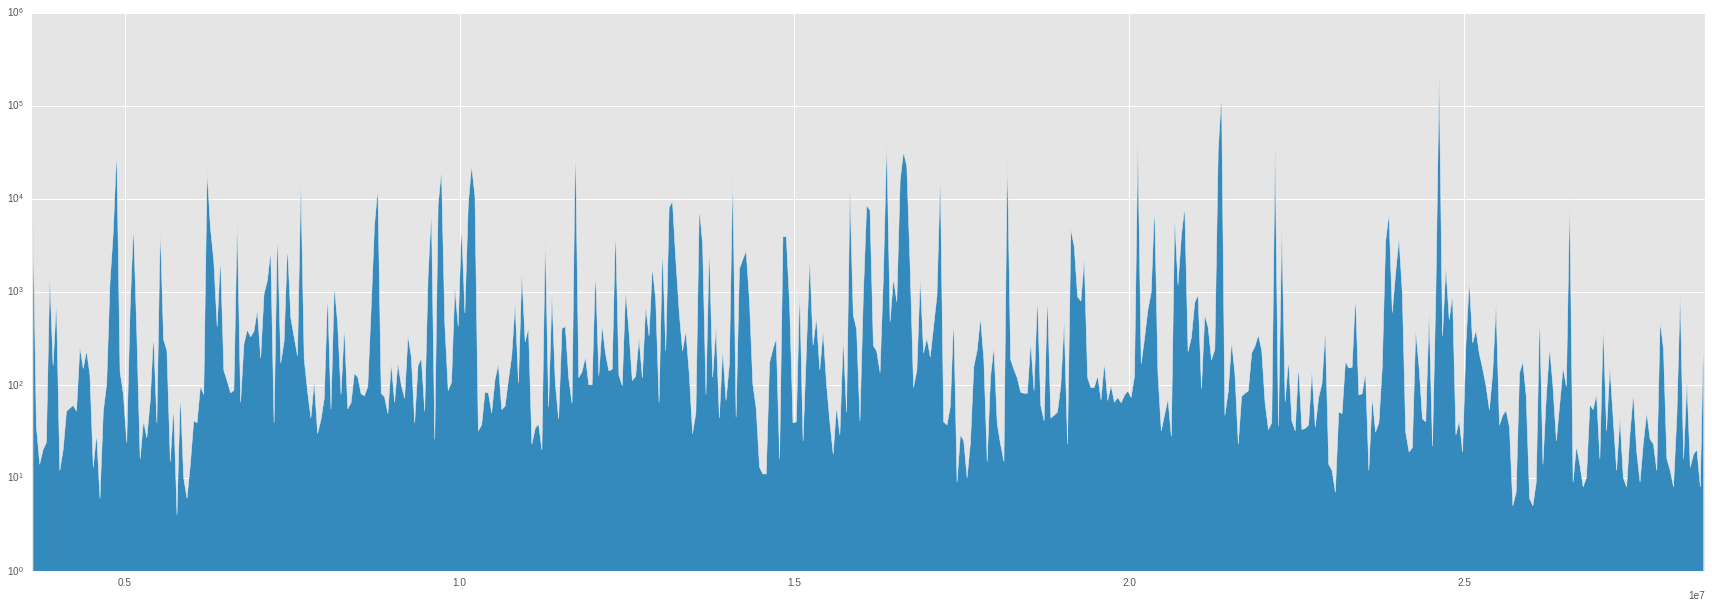

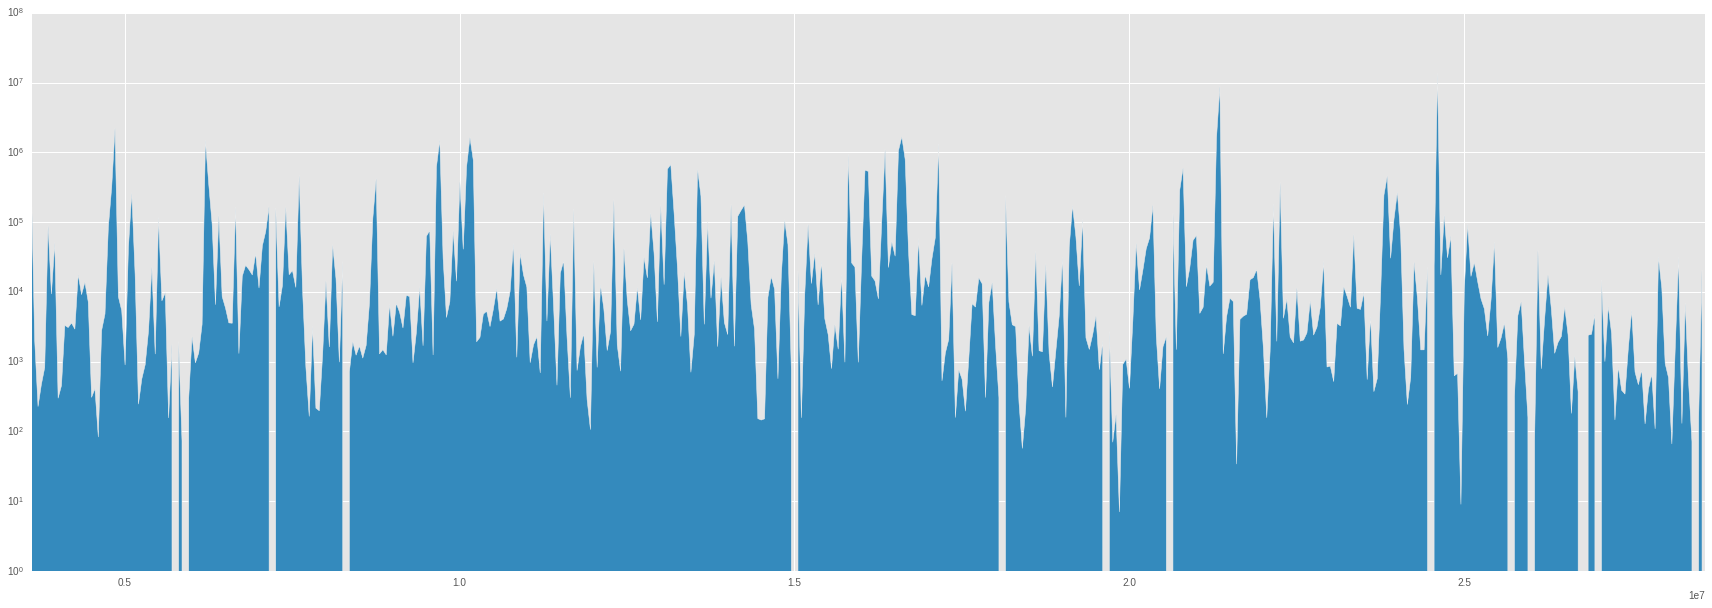

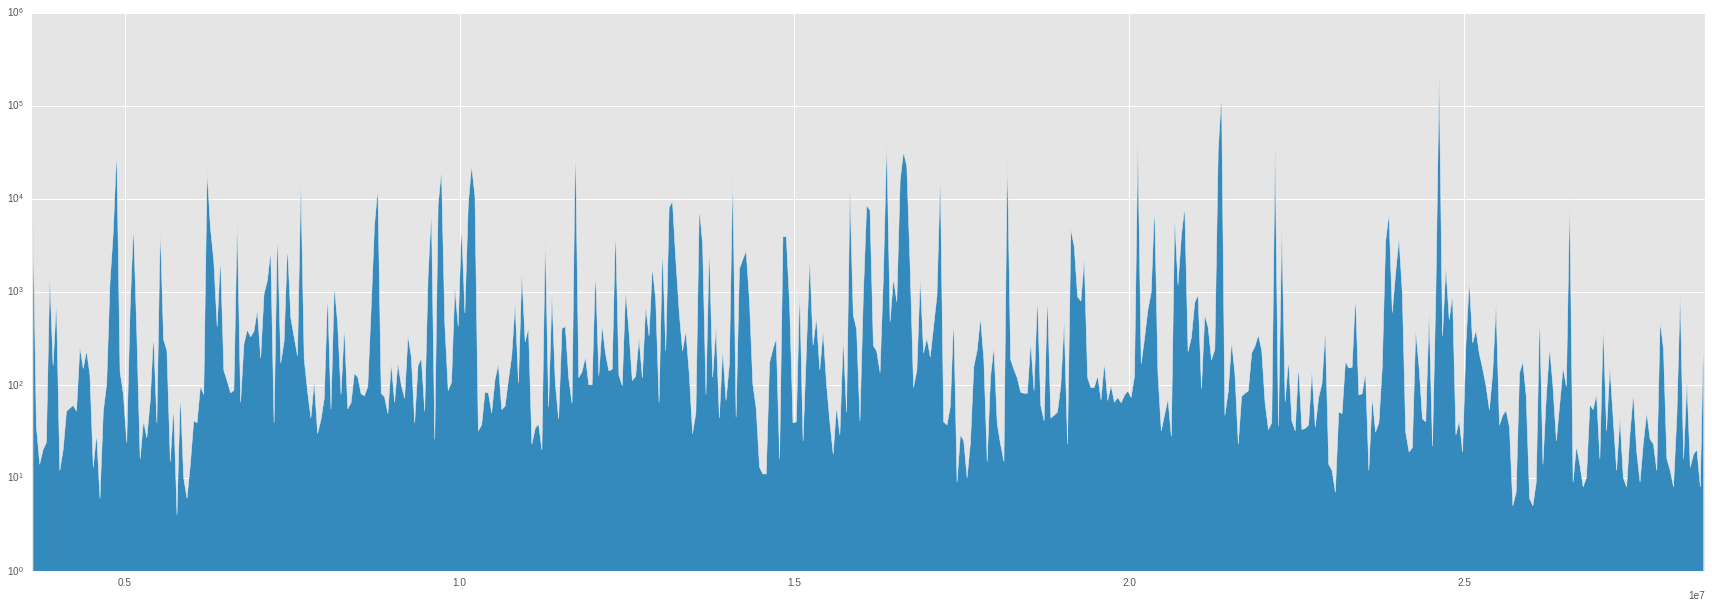

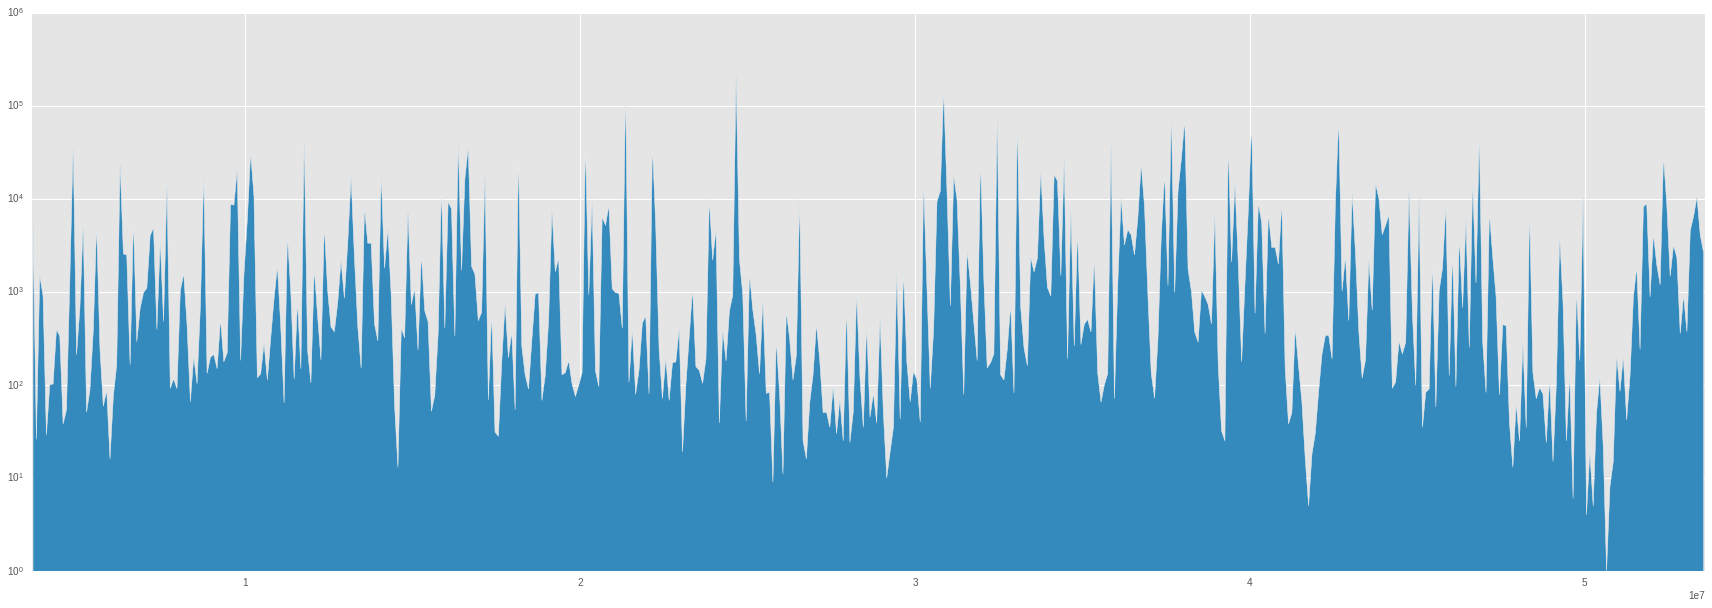

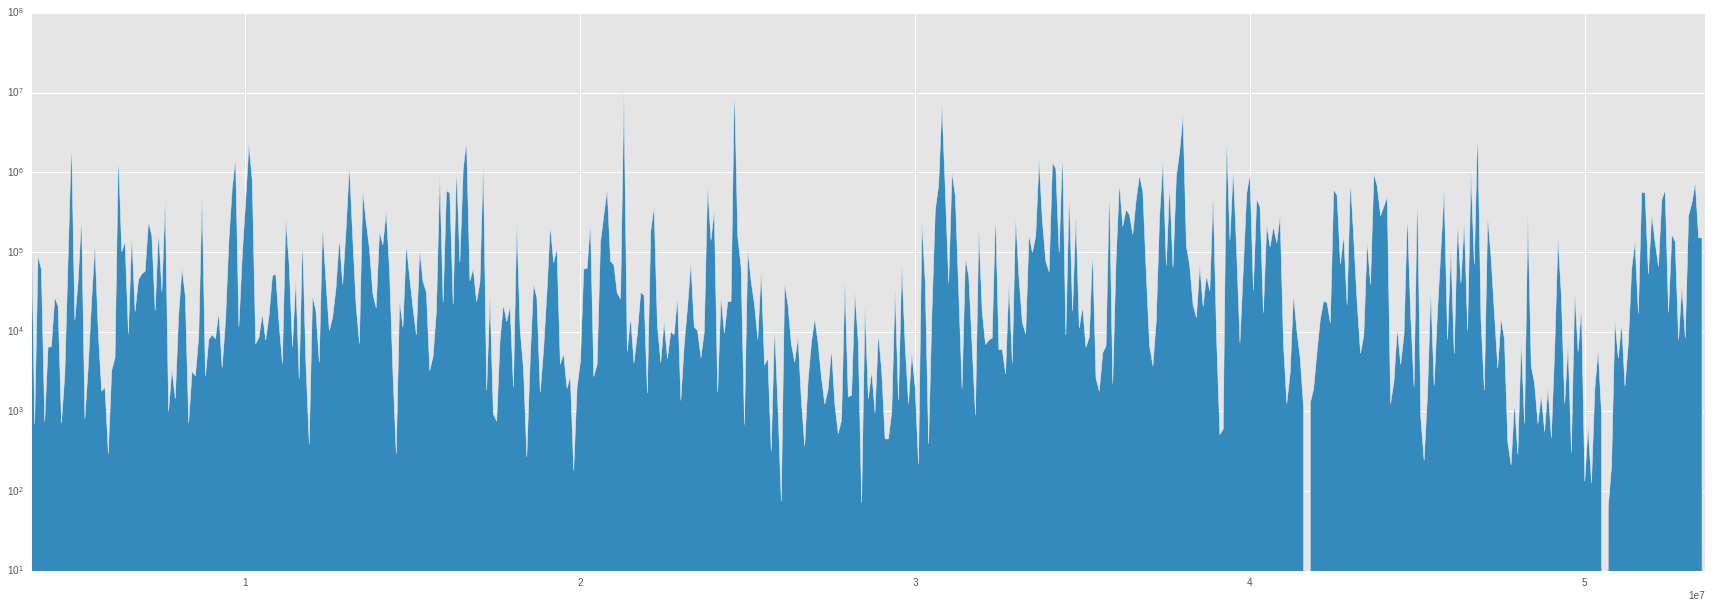

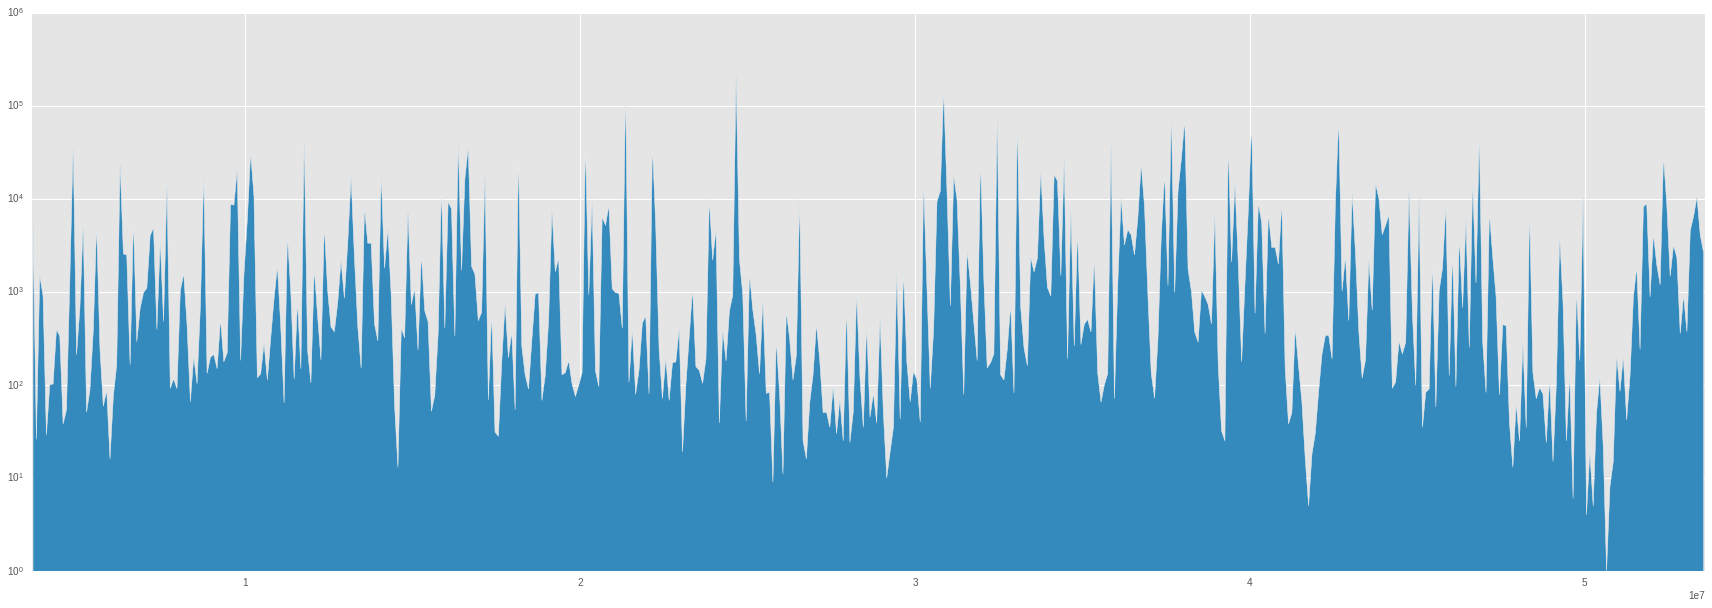

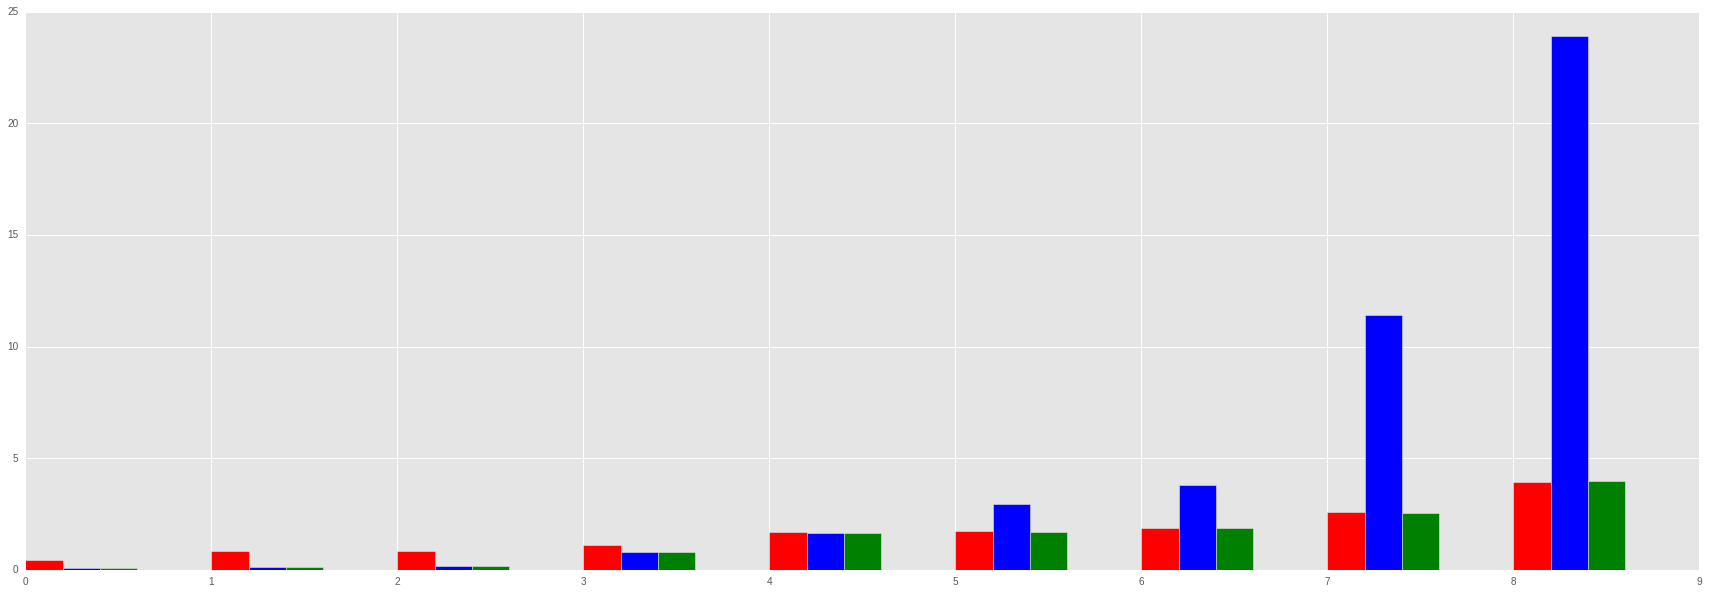

In [216]:
b = "./test_data/out.bam"

t1 = []
t2 = []
t3 = []
start = 3604000
end_list = [10000, 100000, 1000000, 2000000, 5000000, 7500000, 10000000, 25000000, 50000000]
width = 0.2

for end in end_list:
    t=time()
    plot_alignments(fp=b, seqid="chr1", start=start, end=start+end, n_step=500, yscale="log", plot_style="ggplot")
    t1.append(time()-t)
    t=time()
    plot_alignments2(fp=b, seqid="chr1", start=start, end=start+end, n_step=500, yscale="log", plot_style="ggplot")
    t2.append(time()-t)
    t=time()
    plot_alignment_hybrid(fp=b, seqid="chr1", start=start, end=start+end, n_step=500, yscale="log", plot_style="ggplot")
    t3.append(time()-t)

figure, subplot = pl.subplots(figsize=(30, 10), frameon=False)
subplot.bar(np.arange(len(end_list)), t1, width, color="r")
subplot.bar(np.arange(len(end_list))+width, t2, width, color="b")
subplot.bar(np.arange(len(end_list))+2*width, t3, width, color="g")

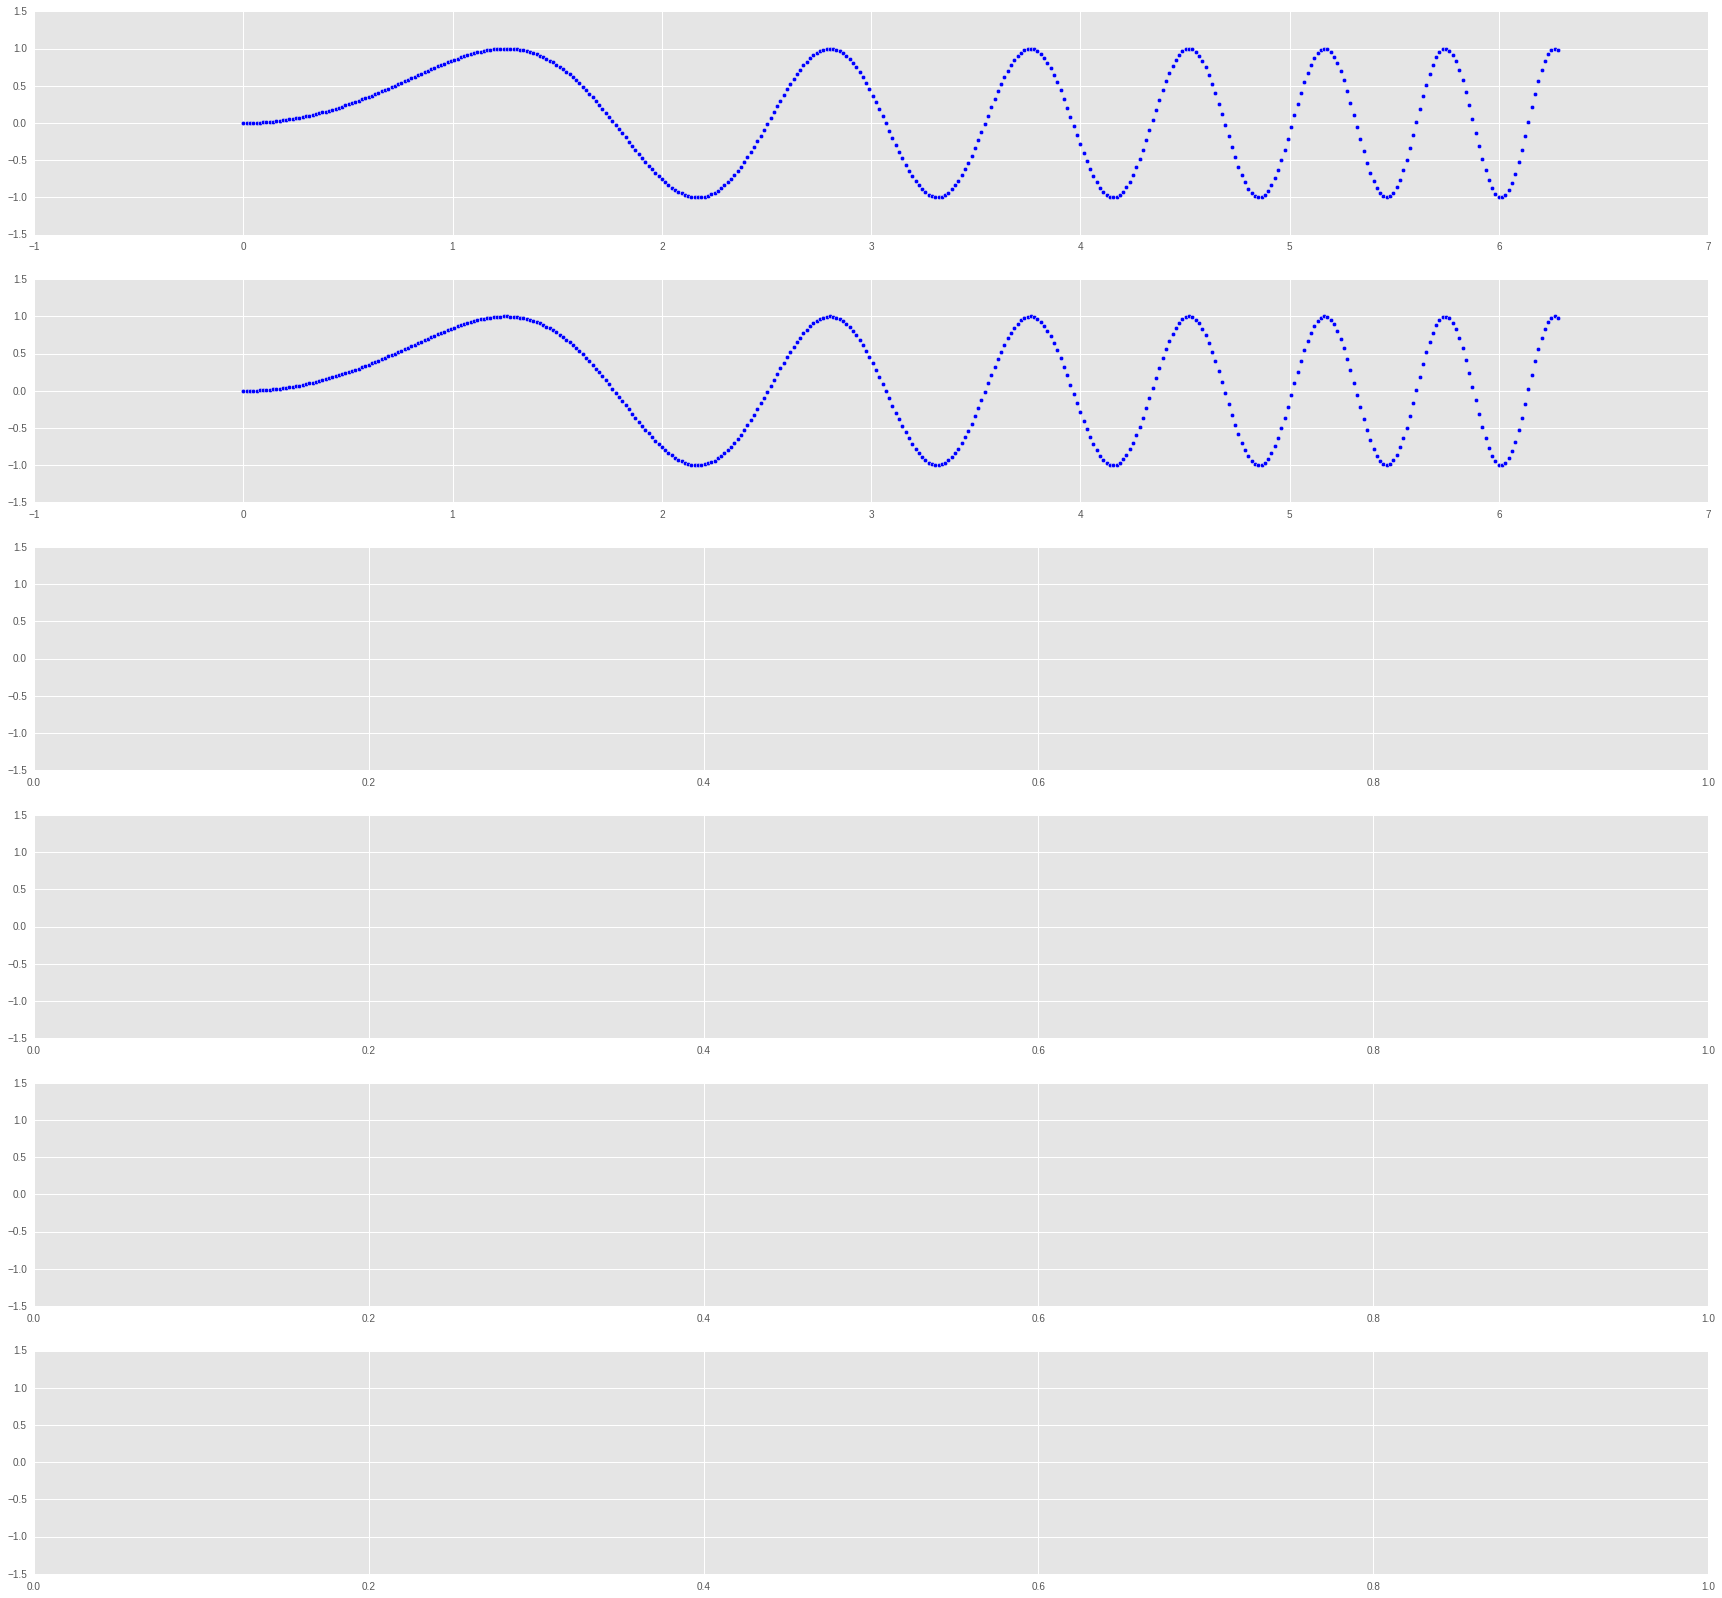

In [85]:
# make figure with subplots

b = 2
b_height = 10
g = 4
g_height = 2

h = b*b_height + g*g_height

gs = GridSpec(3, 3)

f, ax = pl.subplots(b+g, 1, sharey=True, figsize=(30,h))
create_subplot(ax[0:2])

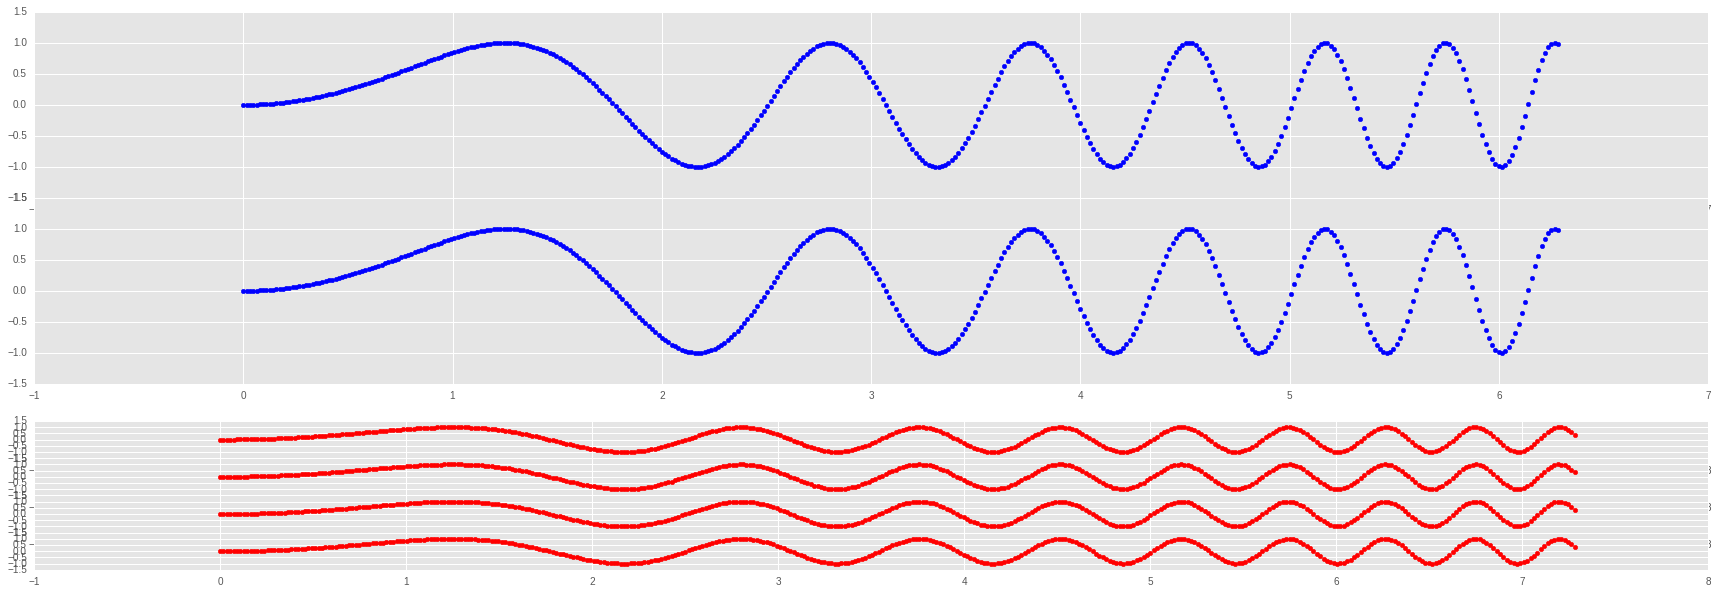

In [101]:
def create_subplot(ax, offset, color):
    for a in ax:
        x = np.linspace(0, 2*np.pi+offset, 400)
        y = np.sin(x ** 2)
        a.scatter(x,y, color=color)

b = 2
b_height = 10
g = 4
g_height = 2

h = b*b_height + g*g_height +2

pl.style.use("ggplot")
fig = pl.figure(figsize=(30,10), frameon=False)
gs = GridSpec(h, 1, hspace=0)
i=0

b_ax = [] 
for n in range(b):
    b_ax.append(pl.subplot(gs[i:i+b_height]))
    i+=b_height

sp = pl.subplot(gs[i:i+2])
sp.axis("off")
i+=2
    
g_ax = []
for n in range(g):
    g_ax.append(pl.subplot(gs[i:i+g_height]))
    i+=g_height

create_subplot(b_ax, 0, "b")
create_subplot(g_ax, 1, "r")

In [9]:
a=False

print("TRUE") if a else print("FALSE")

FALSE


In [21]:
import pysam
fp = "./test_data/gencode_v25_long_noncoding_RNAs_sorted.gff3.gz"
gff = pysam.TabixFile(fp, parser=pysam.asGTF())
gff_iter = gff.fetch()
a = next(gff_iter)
print(a)

chr1	HAVANA	exon	29554	30039	.	+	.	ID=exon:ENST00000473358.1:1;Parent=ENST00000473358.1;gene_id=ENSG00000243485.4;transcript_id=ENST00000473358.1;gene_type=lincRNA;gene_status=KNOWN;gene_name=MIR1302-2;transcript_type=lincRNA;transcript_status=KNOWN;transcript_name=MIR1302-2-001;exon_number=1;exon_id=ENSE00001947070.1;level=2;transcript_support_level=5;tag=not_best_in_genome_evidence,dotter_confirmed,basic;havana_gene=OTTHUMG00000000959.2;havana_transcript=OTTHUMT00000002840.1


---

## Refactoring the external helper functions

In [2]:
def extensions (fp):
    """ 
    Return the extension of a file in lower-case. If archived file "gz" the method will output the base extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return []
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return [split_name[-2].lower(), split_name[-1].lower()]
    # Normal situation = return the last element of the list
    else:
        return [split_name[-1].lower()]
    
def file_basename (fp):
    """ 
    Return the base name of a file without extension nor If archived file "gz" the method will output the name without extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return split_name[0]
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return ".".join(split_name[0:-2])
    # Normal situation = return the last element of the list
    else:
        return ".".join(split_name[0:-1])
    
def dir_path (fp):
    """ 
    Return the directory path of a file
    """
    return fp.rpartition("/")[0]

In [7]:
for fp in glob ("./test_data/*"):
    print (fp)
    print (extensions(fp))
    print (file_basename(fp))
    print (dir_path(fp))
    print()

./test_data/1M_sample.bam
['bam']
1M_sample
./test_data

./test_data/GRCh38_primary_index.tsv
['tsv']
GRCh38_primary_index
./test_data

./test_data/GRCh38_primary.fa.gz
['fa', 'gz']
GRCh38_primary
./test_data

./test_data/gencode_v25_primary.gff3.gz
['gff3', 'gz']
gencode_v25_primary
./test_data



---

## Refactoring the Annotation methods in a separate class

In [68]:
# Strandard library imports
from collections import OrderedDict, namedtuple, Counter
from os import access, R_OK
import csv

# Third party import
import pysam
import pandas as pd

# Local lib import
from JGV_helper_fun import *


class Annotation(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name, verbose=False):
        """
         * fp
            A standard gff3 file (http://www.ensembl.org/info/website/upload/gff3.html) or gtf
            (http://www.ensembl.org/info/website/upload/gff.html)containing features annotations. Could be uncompressed or archived in gz
            format. Ideally the  file would be already indexed with tabix bgzip. If not the program will sort the features and index the 
            file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting. If not given, will be inferred from the file name
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name=name
        self.verbose=verbose
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))
        
        # Define file format and attributes field parser 
        if extensions(fp)[0] == "gtf":
            self.format = "gtf"
            self.get_ID = self._get_gtf_ID
        elif extensions(fp)[0] == "gff3":
            self.format = "gff3"
            self.get_ID = self._get_gff3_ID
        else:
            raise ValueError ("The file is not in gtf or gff3 format (.gff3.gz, .gff3, .gtf.gz, .gtf). Please provide a correctly formated file")
        
        # Save the file path list
        self.fp = fp
        
        # If not indexed, sort and compress and index the original file with tabix 
        if not access(fp+".tbi", R_OK):
           
            # Import in a panda dataframe, remove empty rows, and convert coordinates in integer
            if self.verbose: print("Indexing file with tabix\n\tImport annotation file and clean data")
            df = pd.read_csv(fp, names=["seqname","source","feature","start","stop","score","strand","frame","attribute"], sep="\t")
            df.dropna(inplace=True)
            df[['start', 'stop']] = df[['start', 'stop']].astype(int)
            
            # Sort the dataframe
            if self.verbose: print("\tSort lines by coordinates")
            df.sort_values(by=["seqname","start","stop"], inplace=True)
            
            # Remove the extension, name the output file and write in file
            if self.verbose: print("\tWrite a new sorted annotation file")
            temp_file = "{}/{}_sorted.{}".format(dir_path(fp), file_basename(fp),extensions(fp)[0])
            df.to_csv(temp_file, sep="\t", header=False, index=False, quoting=csv.QUOTE_NONE)
            
            # Compress and index the sorted file with tabix
            if self.verbose: print("\tCompress and index with tabix")
            self.fp = pysam.tabix_index(temp_file, preset="gff", force=True)
            
    def __str__(self):
        """readeable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
        
    #~~~~~~~PROPERTY METHODS~~~~~~~#
        
    @property
    def seqid_count(self):
        """List of all the sequence ids found in the annotation file"""
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as tbf:
            c = Counter()
            for line in tbf.fetch():
                c[line.contig]+=1
        df = pd.DataFrame.from_dict(c, orient='index', dtype=int)
        df.columns = ['count']
        df.sort_values(by="count", inplace=True, ascending=False)
        return df

    @property
    def feature_type_count(self):
        """List of all the feature types found in the annotation file"""
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as tbf:
            c = Counter()
            for line in tbf.fetch():
                c[line.feature]+=1
        df = pd.DataFrame.from_dict(c, orient='index', dtype=int)
        df.columns = ['count']
        df.sort_values(by="count", inplace=True, ascending=False)
        return df
    
    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _get_gtf_ID (self, line):
        """
        Parse a gtf line and extract the feature ID corresponding to the feature type of the line, if possible.
        If not found, then an empty string will be returned.
        """
        if line.feature == "exon":
            id_field = "exon_id"
        elif line.feature == "CDS":
            id_field = "cdsid"
        elif line.feature == "transcript":
            id_field = "transcript_id"
        elif line.feature == "gene":
            id_field = "gene_id"
        else:
            return ""
        
        for a in line.attributes.strip().split(";"):           
            if a:
                l = a.strip().split(" ")
                if len(l) == 2:
                    if l[0] ==  id_field:
                        return l[1][1:-1]
        return ""

    def _get_gff3_ID (self, line):
        """
        Parse a gff3 line and extract the feature ID.
        If not found, then an empty string will be returned.
        """
        for a in line.attributes.strip().split(";"):
            if a:
                l = a.strip().split("=")
                if len(l) == 2:
                    if l[0] == "ID":
                        return l[1]
        return ""

    #~~~~~~~PUBLIC METHODS~~~~~~~#

    def get_interval (self, seqid, start=None, end=None, feature_types=[]):
        """
        Parse the annotation file for the given seqid and interval and return a feature level dictionary containing a list of NamedTuples
        for each original line in the gff or gtf file. Each features are identified by their ID for gff3 file. For gtf file the ID is given
        only for exon, cds, transcript or genes if found.
        * seqid
            Name of the sequence from the initial fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
        * feature_types
            List of features types for which a track will be displayed if at least 1 feature of this type was found in the requested
            interval ( "exon"|"transcript"|"gene"|"CDS"...). If not given, all features type found in the interval will be displayed
            [ DEFAULT: [] ]
        """
        # Init dataframe to collect data
        
        feature_dict = OrderedDict()
        feature = namedtuple('feature', ["ID","start","end","strand"])
 
        # Iterate over the indexed file containing the features
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as f:
            
            for line in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                if not feature_types or line.feature in feature_types:
                    
                    if not line.feature in feature_dict:
                        feature_dict[line.feature] = []
                    
                    feature_dict[line.feature].append(feature(
                            self.get_ID (line),
                            line.start,
                            line.end,
                            line.strand))
                    
            if self.verbose:
                for k,v in feature_dict.items():
                    print ("{}: {}".format(k, len(v)))
            
            return feature_dict
        
        
    def get_interval2 (self, seqid, start=None, end=None, feature_types=[]):
        """
        Parse the annotation file for the given seqid and interval and return a dataframe containing all the feature found 
        for each original line in the gff or gtf file. Each features are identified by their ID for gff3 file. For gtf file the ID is given
        only for exon, cds, transcript or genes, if found.
        * seqid
            Name of the sequence from the initial fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
        * feature_types
            List of features types for which a track will be displayed if at least 1 feature of this type was found in the requested
            interval ( "exon"|"transcript"|"gene"|"CDS"...). If not given, all features type found in the interval will be displayed
            [ DEFAULT: [] ]
        """
        # Init list to collect data and a custume named tuple to store the info
        feature = namedtuple('feature', ["ID","start","end","strand","type"])
        feature_list = []
        
        # Iterate over the indexed file containing the features
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as f:
            
            for l in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                if not feature_types or l.feature in feature_types:
                    feature_list.append(feature( self.get_ID (l), l.start, l.end, l.strand, l.feature))
            
            df= pd.DataFrame(feature_list)
            
            if self.verbose:
                for k,v in df.groupby("type"):
                    print ("{}: {}".format(k, len(v)))
                
            return df

In [173]:
a = Annotation("./test_data/gencode_v25_primary.gff3", "gencode_v25_gff3", verbose=True)
print(a)
display(a.seqid_count.head())
display(a.feature_type_count.head())

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
Annotation instance
	Parameters list
	format	gff3
	fp	./test_data/gencode_v25_primary_sorted.gff3.gz
	get_ID	<bound method Annotation._get_gff3_ID of <__main__.Annotation object at 0x7fcd89ab5ac8>>
	name	gencode_v25_gff3
	verbose	True



count
chr1   231881
chr2   192231
chr17  164876
chr19  163209
chr3   159916

count
exon             1183020
CDS               705063
transcript        198160
five_prime_UTR    142512
three_prime_UTR   134018

In [54]:
a = Annotation("./test_data/gencode_v25_primary.gtf.gz", "gencode_v25_gtf", verbose=True)
print(a)
display(a.seqid_count.head())
display(a.feature_type_count.head())

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
Annotation instance
	Parameters list
	format	gtf
	fp	./test_data/gencode_v25_primary_sorted.gtf.gz
	get_ID	<bound method Annotation._get_gtf_ID of <__main__.Annotation object at 0x7f7f50261438>>
	name	gencode_v25_gtf
	verbose	True



count
chr1   232138
chr2   192370
chr17  165020
chr19  163413
chr3   160060

count
exon         1183020
CDS           704391
UTR           279786
transcript    198160
start_codon    82679

In [53]:
a = Annotation("./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz", "noncode_2016", verbose=True)
print(a)
display(a.seqid_count.head())
display(a.feature_type_count.head())

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
Annotation instance
	Parameters list
	format	gtf
	fp	./test_data/NONCODE2016_human_hg38_lncRNA_sorted.gtf.gz
	get_ID	<bound method Annotation._get_gtf_ID of <__main__.Annotation object at 0x7f7f560320b8>>
	name	noncode_2016
	verbose	True



count
chr2  71850
chr1  71180
chr6  48917
chr3  48041
chr5  45530

count
exon        605359
transcript  233696

In [55]:
a = Annotation("./test_data/gencode_v25_primary_sorted.gff3.gz", "gencode_v25_gtf", verbose=True)
print(a)

Annotation instance
	Parameters list
	format	gff3
	fp	./test_data/gencode_v25_primary_sorted.gff3.gz
	get_ID	<bound method Annotation._get_gff3_ID of <__main__.Annotation object at 0x7f7f56032b38>>
	name	gencode_v25_gtf
	verbose	True



In [58]:
a.get_interval("chr1", 120000, 150000)

transcript: 12
gene: 6
exon: 21


OrderedDict([('transcript',
              [feature(ID='ENST00000466430.5', start=89294, end=120932, strand='-', frame='.'),
               feature(ID='ENST00000477740.5', start=92229, end=129217, strand='-', frame='.'),
               feature(ID='ENST00000471248.1', start=110952, end=129173, strand='-', frame='.'),
               feature(ID='ENST00000610542.1', start=120724, end=133723, strand='-', frame='.'),
               feature(ID='ENST00000453576.2', start=129080, end=133566, strand='-', frame='.'),
               feature(ID='ENST00000442987.3', start=131024, end=134836, strand='+', frame='.'),
               feature(ID='ENST00000494149.2', start=135140, end=135895, strand='-', frame='.'),
               feature(ID='ENST00000595919.1', start=137681, end=137965, strand='-', frame='.'),
               feature(ID='ENST00000493797.1', start=139789, end=140339, strand='-', frame='.'),
               feature(ID='ENST00000484859.1', start=141473, end=149707, strand='-', frame='.'),
    

In [59]:
a.get_interval2("chr1", 120000, 150000)

exon: 21
gene: 6
transcript: 12


ID   start     end strand frame        type
0          ENST00000466430.5   89294  120932      -     .  transcript
1          ENSG00000238009.6   89294  133723      -     .        gene
2          ENST00000477740.5   92229  129217      -     .  transcript
3          ENST00000471248.1  110952  129173      -     .  transcript
4   exon:ENST00000477740.5:2  120720  120932      -     .        exon
5   exon:ENST00000610542.1:4  120724  120869      -     .        exon
6          ENST00000610542.1  120724  133723      -     .  transcript
7   exon:ENST00000466430.5:1  120774  120932      -     .        exon
8   exon:ENST00000610542.1:3  120873  120932      -     .        exon
9   exon:ENST00000471248.1:1  129054  129173      -     .        exon
10  exon:ENST00000477740.5:1  129054  129217      -     .        exon
11  exon:ENST00000610542.1:2  129054  129223      -     .        exon
12  exon:ENST00000453576.2:2  129080  129223      -     .        exon
13         ENST00000453576.2  129080  133566      -     .  transcript
14         ENSG00000233750.3  131024  134836      +     .        gene
15         ENST00000442987.3  131024  134836      +     .  transcript
16  exon:ENST00000442987.3:1  131024  134836      +     .        exon
17  exon:ENST00000453576.2:1  133373  133566      -     .        exon
18  exon:ENST00000610542.1:1  133373  133723      -     .        exon
19         ENSG00000268903.1  135140  135895      -     .        gene
20         ENST00000494149.2  135140  135895      -     .  transcript
21  exon:ENST00000494149.2:1  135140  135895      -     .        exon
22         ENSG00000269981.1  137681  137965      -     .        gene
23         ENST00000595919.1  137681  137965      -     .  transcript
24  exon:ENST00000595919.1:1  137681  137965      -     .        exon
25  exon:ENST00000493797.1:2  139789  139847      -     .        exon
26         ENSG00000239906.1  139789  140339      -     .        gene
27         ENST00000493797.1  139789  140339      -     .  transcript
28  exon:ENST00000493797.1:1  140074  140339      -     .        exon
29  exon:ENST00000484859.1:2  141473  143011      -     .        exon
30         ENST00000484859.1  141473  149707      -     .  transcript
31         ENSG00000241860.6  141473  173862      -     .        gene
32  exon:ENST00000490997.5:3  142807  143011      -     .        exon
33         ENST00000490997.5  142807  146831      -     .  transcript
34  exon:ENST00000490997.5:2  146385  146509      -     .        exon
35  exon:ENST00000466557.6:8  146385  146509      -     .        exon
36  exon:ENST00000484859.1:1  146385  149707      -     .        exon
37         ENST00000466557.6  146385  173862      -     .  transcript
38  exon:ENST00000490997.5:1  146641  146831      -     .        exon

In [60]:
l = a.get_interval("chrX", feature_types=["exon"])

exon: 35309


In [67]:
a.get_interval2("chrX", feature_types=["exon"])

exon: 35309


ID      start        end strand frame  type
0       exon:ENST00000431238.7:1     253742     253846      +     .  exon
1       exon:ENST00000431238.7:2     254936     255091      +     .  exon
2       exon:ENST00000399012.6:1     276321     276394      +     .  exon
3       exon:ENST00000484611.7:1     276323     276394      +     .  exon
4       exon:ENST00000430923.7:1     276352     276394      +     .  exon
5       exon:ENST00000445062.6:1     281054     281121      +     .  exon
6       exon:ENST00000381657.7:1     281191     281684      +     .  exon
7       exon:ENST00000429181.6:1     281193     281256      +     .  exon
8       exon:ENST00000381663.8:1     281461     281684      +     .  exon
9       exon:ENST00000399012.6:2     281481     281684      +     .  exon
10      exon:ENST00000445062.6:2     281481     281684      +     .  exon
11      exon:ENST00000429181.6:2     281481     281684      +     .  exon
12      exon:ENST00000443019.6:1     283162     283201      +     .  exon
13      exon:ENST00000415337.6:1     283464     283488      +     .  exon
14      exon:ENST00000447472.6:1     283478     283520      +     .  exon
15      exon:ENST00000448477.6:1     283733     284314      +     .  exon
16      exon:ENST00000399012.6:3     284166     284314      +     .  exon
17      exon:ENST00000484611.7:2     284166     284314      +     .  exon
18      exon:ENST00000430923.7:2     284166     284314      +     .  exon
19      exon:ENST00000445062.6:3     284166     284314      +     .  exon
20      exon:ENST00000381657.7:2     284166     284314      +     .  exon
21      exon:ENST00000429181.6:3     284166     284314      +     .  exon
22      exon:ENST00000381663.8:2     284166     284314      +     .  exon
23      exon:ENST00000443019.6:2     284166     284314      +     .  exon
24      exon:ENST00000415337.6:2     284166     284314      +     .  exon
25      exon:ENST00000447472.6:2     284166     284314      +     .  exon
26      exon:ENST00000429181.6:4     288732     288787      +     .  exon
27      exon:ENST00000443019.6:3     288732     288829      +     .  exon
28      exon:ENST00000399012.6:4     288732     288869      +     .  exon
29      exon:ENST00000484611.7:3     288732     288869      +     .  exon
...                          ...        ...        ...    ...   ...   ...
35279   exon:ENST00000359512.8:7  156023301  156023460      +     .  exon
35280  exon:ENST00000340131.12:5  156023301  156023460      +     .  exon
35281   exon:ENST00000460206.6:5  156023301  156023460      +     .  exon
35282   exon:ENST00000483079.6:2  156023301  156023531      +     .  exon
35283   exon:ENST00000492963.6:5  156023301  156025100      +     .  exon
35284   exon:ENST00000461007.6:2  156023301  156025663      +     .  exon
35285   exon:ENST00000484415.6:5  156023301  156025663      +     .  exon
35286   exon:ENST00000496301.6:1  156023366  156023460      +     .  exon
35287   exon:ENST00000483286.6:1  156023823  156024272      +     .  exon
35288   exon:ENST00000464205.6:1  156024070  156024272      +     .  exon
35289   exon:ENST00000359512.8:8  156024119  156024272      +     .  exon
35290  exon:ENST00000340131.12:6  156024119  156024272      +     .  exon
35291   exon:ENST00000460206.6:6  156024119  156024272      +     .  exon
35292   exon:ENST00000496301.6:2  156024119  156025666      +     .  exon
35293   exon:ENST00000464205.6:2  156025031  156025049      +     .  exon
35294   exon:ENST00000359512.8:9  156025031  156025100      +     .  exon
35295  exon:ENST00000340131.12:7  156025031  156025100      +     .  exon
35296   exon:ENST00000460206.6:7  156025031  156025100      +     .  exon
35297   exon:ENST00000483286.6:2  156025031  156025100      +     .  exon
35298  exon:ENST00000359512.8:10  156025240  156025374      +     .  exon
35299   exon:ENST00000483286.6:3  156025240  156025554      +     .  exon
35300   exon:ENST00000464205.6:3  156025240  156025554      +     .  exon
35301  exon:ENST00000340131.12:8  

In [65]:
l = b.get_interval("chr1")

exon: 108417
gene: 5194
transcript: 17296
start_codon: 7004
CDS: 64975
stop_codon: 6626
UTR: 22617
Selenocysteine: 9


In [66]:
l = b.get_interval2("chr1")

CDS: 64975
Selenocysteine: 9
UTR: 22617
exon: 108417
gene: 5194
start_codon: 7004
stop_codon: 6626
transcript: 17296


#### Test all from the class file in which I pushed the code. I chosed the pandas implementation of the interval function

In [5]:
from Annotation import Annotation
from IPython.core.display import display, HTML, Markdown, Image
from pycl import head as h

In [5]:
a = Annotation("./test_data/gencode_v25_primary.gff3.gz", "gencode25", verbose=True)
a.interval_features("chr8", 1000000, 1200000)

ID    start      end strand        type
0          ENST00000637795.1   737595  1701406      +  transcript
1         ENSG00000198010.12   737595  1708474      +        gene
2          ENST00000522092.5   737650  1137777      +  transcript
3          ENST00000421627.7   822178  1701406      +  transcript
4          ENST00000524139.5   883197  1032931      +  transcript
5          ENST00000578889.1   883327  1105066      +  transcript
6   exon:ENST00000524139.5:3  1002112  1003304      +        exon
7          ENSG00000282692.1  1018756  1019704      +        gene
8          ENST00000634128.1  1018756  1019704      +  transcript
9   exon:ENST00000634128.1:1  1018756  1019704      +        exon
10  exon:ENST00000524139.5:4  1032585  1032931      +        exon
11  exon:ENST00000520524.5:1  1104881  1105066      +        exon
12         ENST00000520524.5  1104881  1262580      +  transcript
13  exon:ENST00000578889.1:3  1104882  1105066      +        exon
14  exon:ENST00000522092.5:4  1137298  1137777      +        exon

In [7]:
a = Annotation("./test_data/gencode_v25_primary_sorted.gtf.gz", "gencode25", verbose=True)
a.interval_features("chr8", 1000000, 1200000)

ID    start      end strand        type
0    ENST00000637795.1   737595  1701406      +  transcript
1   ENSG00000198010.12   737595  1708474      +        gene
2    ENST00000522092.5   737650  1137777      +  transcript
3    ENST00000421627.7   822178  1701406      +  transcript
4    ENST00000524139.5   883197  1032931      +  transcript
5    ENST00000578889.1   883327  1105066      +  transcript
6    ENSE00002122977.1  1002112  1003304      +        exon
7    ENSG00000282692.1  1018756  1019704      +        gene
8    ENST00000634128.1  1018756  1019704      +  transcript
9    ENSE00003776227.1  1018756  1019704      +        exon
10   ENSE00002095728.1  1032585  1032931      +        exon
11   ENSE00002098441.1  1104881  1105066      +        exon
12   ENST00000520524.5  1104881  1262580      +  transcript
13   ENSE00002695954.1  1104882  1105066      +        exon
14   ENSE00002139515.1  1137298  1137777      +        exon

In [9]:
a = Annotation("./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz", "noncode", verbose=True)
a.interval_features("chr8", 1000000, 1200000)

ID    start      end strand        type
0   NONHSAT124629.1   687586  1087777      +  transcript
1   NONHSAT124629.2   737586  1137777      +  transcript
2   NONHSAT124633.1   833327  1055066      +  transcript
3   NONHSAT124632.2   883197  1032931      +  transcript
4   NONHSAT124633.2   883327  1105066      +  transcript
5   NONHSAT124635.2   896658  1032871      +  transcript
6                    1002112  1003304      +        exon
7                    1032585  1032871      +        exon
8                    1032585  1032931      +        exon
9                    1054881  1055066      +        exon
10  NONHSAT124637.1  1054881  1212580      +  transcript
11                   1054882  1055066      +        exon
12                   1087298  1087777      +        exon
13  NONHSAT216697.1  1087898  1088629      -  transcript
14                   1087898  1088629      -        exon
15                   1104881  1105066      +        exon
16  NONHSAT124637.2  1104881  1262580      +  transcript
17                   1104882  1105066      +        exon
18                   1104882  1105067      +        exon
19  NONHSAT215311.1  1104882  1262581      +  transcript
20                   1137298  1137777      +        exon
21                   1196788  1196858      -        exon
22  NONHSAT124639.1  1196788  1198760      -  transcript
23                   1197005  1197103      -        exon
24                   1198482  1198760      -        exon

---

## Refactoring the Alignment methods in a separate class

In [23]:
# Strandard library imports
from time import time
from collections import OrderedDict, namedtuple, Counter
from os import access, R_OK
import csv
from statistics import median, mean

# Third party import
import pysam
import pandas as pd

# Local lib import
from JGV_helper_fun import *

class Alignment(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name, verbose=False):
        """
         * fp
             A standard bam file already SORTED BY COORDINATES (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             Ideally the file would also be already indexed with samtools index. If not the program will index the file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting.
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name=name
        self.verbose=verbose
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))

        # Verify that the file is in bam format
        if extensions(fp)[0] != "bam":
            raise ValueError ("The file is not in BAM format (.bam). Please provide a correctly formated file")
        
        with pysam.AlignmentFile(fp) as bam:
            # If not bam index available
            if not bam.has_index():
                # Verify if file is sorted
                if bam.header["HD"]['SO'] == "coordinate":
                    if self.verbose: print ("Indexing bam file with samtools index")
                    pysam.index(fp, catch_stdout=False)
                else:
                    raise UserWarning ("The bam file needs to be sorted by coordinates to be processed")
        
         # The index should be available at this stage
        with pysam.AlignmentFile(fp) as bam:
            assert bam.has_index(), "Bam file is not indexed ?"
            
            # save the list of the sequences found in the file
            self.seqid_list = bam.references
            self.n_seq = len(self.seqid_list)
        
        # Save the file path list
        self.fp = fp
            
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
        

    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _len_seqid (self, seqid):
        """ Calculate the length of a seqid reference from the index metadata """
        with pysam.AlignmentFile(self.fp, "rb") as bam:
            for reference, length in zip(bam.references, bam.lengths):
                if seqid == reference:
                    return length
        return 0
    
    #~~~~~~~PUBLIC METHODS~~~~~~~#
    
    def seqid_read_count (self):
        """
        Return a dataframe containing 3 colums ("length", "read_count", "read_density") for all seq_id reference sequence in the BAM file.
        The read count is computationally intensive and can take time for large BAM files
        """
        with pysam.AlignmentFile(self.fp, "rb") as bam:
            df = pd.DataFrame(columns=["length", "read_count", "rpkm"], index=bam.references)
            total_read = 0
            
            for seqid, length in zip(bam.references, bam.lengths):
                read_count = bam.count(seqid)
                df.loc[seqid]["length"] = length
                df.loc[seqid]["read_count"] = read_count
                total_read += read_count
            
        for seqid, val in df.iterrows():
            df.loc[seqid]["rpkm"] = val.read_count / (val.length/1000) / (total_read/1000000)
            
    def seqid_read_density (self):
        """
        Return a dataframe containing 4 colums ("seqid", length", "read_count", "read_density") for all seq_id reference sequence in the BAM file.
        The read count is computationally intensive and can takes time for large BAM files
        """
        seq_info = namedtuple('seq_info', ["seqid", "length", "read_count", "read_density"])
        seq_info_list = []

        with pysam.AlignmentFile(self.fp, "rb") as bam:
            for seqid, length in zip(bam.references, bam.lengths):
                read_count = bam.count(seqid)
                seq_info_list.append(seq_info(seqid, length, read_count, read_count/length))
        
        return pd.DataFrame(seq_info_list)
    
    def interval_coverage (self, seqid, start=None, end=None, n_step=500, mode="auto"):
        """
        Parse the alignment file for a given seqid and interval. Compute the coverage at read level in mode "read_count" or at base level
        in mode "base_coverage". In both case the interval is splited in a number of windows equal to n_step, for which the coverage in computed.
        The method return a tuple of 2 synchronised lists containing the starting positions of the windows and the coverage.
        * seqid
            Name of the sequence from the initial fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
       * n_step
            Number of alignment count bins to divide the displayed window. Low number will result in low resolution but will be faster. The
            default value is a decent compromise between speed and precision [ DEFAULT: 500 ]
        * mode
            Mode to parse and represent the alignment track ("auto"|"read_count"|"base_coverage"). The "read_count" is fast for large
            regions, but do not account for spliced reads. In "auto" mode it is automatically selected for intervals larger than 5000000.
            The "base_coverage" mode compute the median base coverage per step. It is faster for low coverage and small intervals.
            In "auto" mode it is automatically selected for intervals larger smaller than 5000000 [ DEFAULT: "auto" ]
        """
        
        # Init lists to collect data
        covpoint = namedtuple('covpoint', ['Position', 'Coverage'])
        covpoint_list = []
        
        # Verify that the sequence is in the seqid list
        if seqid not in self.seqid_list:
            raise ValueError ("The requested seqid ({}) was not found in the list of reference for this alignment {}".format(seqid, self.name))
       
         # Auto define start and stop if not given
        if not start:
            start = 0
            if self.verbose: print ("Autodefine start position: {}".format(start))
        if not end:
            end = self._len_seqid(seqid)
            if self.verbose: print ("Autodefine end position: {}".format(end))
        if start >= end:
            raise ValueError ("Invalid coordinates (start: {}, end :{}) start has to be greater than end")
        
        # Autocorect the number of steps if needed to be always superior or equal to the requested interval
        len_range = end-start
        if n_step > len_range:
            n_step = len_range
            if self.verbose: warnings.warn("Short interval = autocorect n_step to {}".format(n_step))
        step_size = (end-start) / float(n_step)

        # Read_count method, quicker for long intervals
        if mode == "read_count" or (mode == "auto" and len_range > 5000000):
            if self.verbose: print("Select read_count mode") 
            
            start_pos = start
            with pysam.AlignmentFile(self.fp) as bam:
                for i in range(n_step):
                    
                    pos = round(start_pos)
                    cov = bam.count(seqid, start_pos, start_pos+step_size)
                    covpoint_list.append(covpoint(pos, cov))
                    
                    start_pos+=step_size

        # Coverage method, quicker for short intervals
        elif mode == "base_coverage" or (mode == "auto" and len_range <= 5000000):
            if self.verbose: print("Select base_coverage mode")
            with pysam.AlignmentFile(self.fp) as bam:
                mat = bam.count_coverage(seqid, start, end)
                
                start_pos = 0
                while start_pos <= len_range-step_size:
                    
                    s = round(start_pos)
                    e = round(start_pos+step_size)

                    pos = round(start+start_pos)
                    cov = (sum(mat[0][s:e])+sum(mat[1][s:e])+sum(mat[2][s:e])+sum(mat[3][s:e]))/step_size
                    covpoint_list.append(covpoint(pos, cov))

                    start_pos+=step_size
        
        # Fuse the list in a dataframe 
        return pd.DataFrame(covpoint_list)
        

In [20]:
f= "./test_data/10M_sample.bam"
a = Alignment(f, "10M", verbose=True)
print(a)

In [11]:
from ipywidgets import widgets

seqid = widgets.Text(description="Sequence id", width=200)
display(seqid)

def handle_submit()

text.on_submit(handle_submit)




In [21]:
seqid_widget = widgets.Text(value=None, description='Sequence id: ')
start_widget = widgets.IntText(value=None, description='Start coordinate: ')
end_widget = widgets.IntText(value=None, description='Start coordinate: ')
render_widget = widgets.ToggleButton(value=False, description='Update plot', icon='check')

display(seqid_widget,start_widget, end_widget, render_widget)

def f(sender):
    print (seqid_widget.value, start_widget.value, end_widget.value)

render_widget(f)

chr1 0 0
chr1 0 0
chr1 0 0


In [ ]:
a.seqid_read_density().head()

In [ ]:
a.seqid_read_density2().head()

In [ ]:
a.interval_coverage("chrM").head()

In [ ]:
a.interval_coverage("chr1", 1000000, 1000100, mode="base_coverage")

#### Test all from the class file in which I pushed the code

In [2]:
from JGV_Alignment import Alignment
from IPython.core.display import display, HTML, Markdown, Image
from pycl import head as h

In [4]:
f= "./test_data/10M_sample.bam"
a = Alignment(f, "10M", verbose=True)
print(a)

display(a.seqid_read_count().head())

display(a.interval_coverage("chrM", 0, 10000).head())

length read_count      rpkm
chr1  248956422    1679660  0.303341
chr2  242193529    1672466  0.310476
chr3  198295559    1260202  0.285733
chr4  190214555     528980  0.125034
chr5  181538259     575470  0.142524

Position  Coverage
0         0     33.10
1        20     50.75
2        40     63.70
3        60     77.75
4        80     82.35

---

## Refactoring the Reference methods in a separate class

In [13]:
# Strandard library imports
from collections import OrderedDict, Counter
from os import access, R_OK
import gzip
import sys
import csv

# Third party import
import pandas as pd

# Local lib import
from JGV_helper_fun import *

#~~~~~~~CLASS~~~~~~~#

class Reference(object):
    
    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name=None, verbose=False):
        """
         * fp
             A standard bam file already SORTED BY COORDINATES (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             Ideally the file would also be already indexed with samtools index. If not the program will index the file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting.
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name= name if name else file_basename(fp)
        self.verbose=verbose
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))
        
        # If the file is in fasta format
        if extensions(fp)[0] in ["fa", "fasta"]:
            if self.verbose: print ("Parsing fasta file")
            
            # File handling for both uncompressed or compressed fasta file
            if fp.endswith(".gz"):
                open_fun, open_mode = gzip.open, "rt"
            else:
                open_fun, open_mode = open, "r"
            
            # Parse fasta file seqid and count the length of each sequence 
            with open_fun(fp, open_mode) as f:
                c = Counter()
                for l in f:
                    if l.startswith(">"):
                        seqid = l[1:].split()[0].strip()
                    else:
                        c[seqid]+=len(l.strip())
            
            # Transform the counter in a Dataframe and sort by length 
            self.seq_list =  pd.DataFrame.from_dict(c, orient='index', dtype=int)
            self.seq_list.columns = ['length']
            self.seq_list.index.name = 'seqid'
            self.seq_list.sort_values(by="length", inplace=True, ascending=False)
            
            # Write the index in a file for quicker loading next time
            index_file = "{}/{}.tsv".format(dir_path(fp), file_basename(fp))
            if self.verbose: print ("Write a fasta index file: {}".format(index_file))
            self.seq_list.to_csv(index_file, sep="\t", header=False, index=True, quoting=csv.QUOTE_NONE)
            
        # In the case the file is not in fasta format, try to parse it as a 2 columns tabulated file with seqid and length for each sequence
        else:
            if self.verbose: print ("Assume the file is a fasta index")
            self.seq_list = pd.read_csv (fp, usecols=[0,1], sep ="\t", names=["seqid", "length"], index_col=0)
            self.seq_list.sort_values(by="length", inplace=True, ascending=False)
        
        if self.verbose: print("Total number of sequences found: {}".format(len(self.seq_list)))
            
            
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
    
    def get_seqid_len (self, seqid):
        """ Return the length of a given seqid"""
        return self.seq_list.loc[seqid]["length"]

In [18]:
a = Reference("./test_data/GRCh38_primary.fa.gz", verbose =True)
a.seq_list.head()

Parsing fasta file
Write a fasta index file: ./test_data/GRCh38_primary.tsv
Total number of sequences found: 194


length
seqid           
chr1   248956422
chr2   242193529
chr3   198295559
chr4   190214555
chr5   181538259

In [11]:
h ("./test_data/GRCh38_primary.tsv")

chr1	248956422
chr2	242193529
chr3	198295559
chr4	190214555
chr5	181538259
chr6	170805979
chr7	159345973
chrX	156040895
chr8	145138636
chr9	138394717


In [15]:
a = Reference("./test_data/GRCh38_primary.tsv", verbose =True)
a.get_seqid_len("chr1")

Assume the file is a fasta index
Total number of sequences found: 194


248956422

In [17]:
print("Extract fasta and create fai index to test index mode")
!gunzip -c ./test_data/GRCh38_primary.fa.gz > ./test_data/GRCh38_primary.fa
!samtools faidx ./test_data/GRCh38_primary.fa
!ls -la ./test_data/

Extract fasta and create fai index to test index mode
total 5315260
drwxrwxr-x 2 aleg aleg       4096 Oct 22 15:12 .
drwxrwxr-x 6 aleg aleg       4096 Oct 22 15:12 ..
-rw-rw-r-- 1 aleg aleg 1094706685 Oct 18 15:25 10M_sample.bam
-rw-rw-r-- 1 aleg aleg    2245584 Oct 19 21:56 10M_sample.bam.bai
-rw-rw-r-- 1 aleg aleg  134778245 Oct 18 15:26 1M_sample.bam
-rw-rw-r-- 1 aleg aleg    1805648 Oct 19 21:50 1M_sample.bam.bai
-rw-rw-r-- 1 aleg aleg   46752876 Oct 19 17:51 gencode_v25_primary.gff3.gz
-rw-rw-r-- 1 aleg aleg   38827267 Oct 19 17:51 gencode_v25_primary.gtf.gz
-rw-rw-r-- 1 aleg aleg   60136333 Oct 19 18:06 gencode_v25_primary_sorted.gff3.gz
-rw-rw-r-- 1 aleg aleg     339199 Oct 19 18:06 gencode_v25_primary_sorted.gff3.gz.tbi
-rw-rw-r-- 1 aleg aleg   49743035 Oct 19 18:07 gencode_v25_primary_sorted.gtf.gz
-rw-rw-r-- 1 aleg aleg     338077 Oct 19 18:07 gencode_v25_primary_sorted.gtf.gz.tbi
-rw-rw-r-- 1 aleg aleg 3151417447 Oct 22 15:13 GRCh38_primary.fa
-rw-rw-r-- 1 aleg aleg       64

In [17]:
a = Reference("./test_data/GRCh38_primary.fa.fai", verbose =True)
a.seq_list.head()

Assume the file is a fasta index
Total number of sequences found: 194


length
seqid           
chr1   248956422
chr2   242193529
chr3   198295559
chr4   190214555
chr5   181538259

#### Test all from the class file in which I pushed the code

In [26]:
from JGV_Reference import Reference as R
from IPython.core.display import display, HTML, Markdown, Image
from pycl import head as h

In [7]:
a = R("./test_data/GRCh38_primary.fa.gz", verbose =True)
a.seq_list.head()

Parsing fasta file
Write a fasta index file: ./test_data/GRCh38_primary.tsv
Total number of sequences found: 194


length
seqid           
chr1   248956422
chr2   242193529
chr3   198295559
chr4   190214555
chr5   181538259

In [45]:
a = R("./test_data/GRCh38_primary.fa.fai", verbose =True)
a.seq_list.head()

NameError: name 'R' is not defined

In [3]:
##### Strandard library imports
from time import time
from collections import OrderedDict, namedtuple, Counter
from os import access, R_OK
import csv
from statistics import median, mean

# ipython notebook imports
from IPython.core.display import display
%matplotlib inline

# Third party import
import pysam
import pandas as pd
import pylab as pl
from matplotlib.patches import FancyArrowPatch as Arrow

# Local lib import
from JGV_helper_fun import *
from JGV_helper_fun import jprint as print
from JGV_Reference import Reference
from JGV_Annotation import Annotation
from JGV_Alignment import Alignment

ImportError: No module named 'JGV_Reference'

In [117]:
class JGV(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name=None, verbose=False):
        """
        """
        #Save self variable
        self.verbose=verbose
        self.reference = Reference(fp=fp, name=name, verbose=self.verbose)
        self.annotations = []
        self.alignments = []
            
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
                   
    #~~~~~~~PUBLIC SET METHODS~~~~~~~#
    
    def add_annotation(self, fp, name=None):
        """
        Add an annotation file to the JGV instance annotation list
         * fp
            A standard gff3 file (http://www.ensembl.org/info/website/upload/gff3.html) or gtf
            (http://www.ensembl.org/info/website/upload/gff.html)containing features annotations. Could be uncompressed or archived in gz
            format. Ideally the  file would be already indexed with tabix bgzip. If not the program will sort the features and index the 
            file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting. If not given, will be deduced from fp file name
        """
        annotation = Annotation(fp=fp, name=name, verbose=self.verbose)
        warn_list = [seqid for seqid in annotation.seqid_list if seqid not in self.reference.seqid_list]
        if self.verbose and warn_list:
            warnings.warn ("In annotation file {}, the following sequence ids were not found in the reference genome file\n{}".format(
                    annotation.name, "\n".join(warn_list)))
        self.annotations.append(annotation)
    
    def add_alignement(self, fp, name=None, verbose=False):
        """
        Add an alignment file to the JGV instance annotation list
        * fp
             A standard bam file already SORTED BY COORDINATES (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             Ideally the file would also be already indexed with samtools index. If not the program will index the file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting. If not given, will be deduced from fp file name
        """
        alignment = Alignment(fp=fp, name=name, verbose=self.verbose)
        warn_list = [seqid for seqid in alignment.seqid_list if seqid not in self.reference.seqid_list]
        if warn_list:
            warnings.warn ("In alignment file {}, the following sequence ids were not found in the reference genome file\n{}".format(
                    alignment.name, "\n".join(warn_list[:10])))
        self.alignments.append(alignment)
        
    #~~~~~~~PUBLIC GENERAL METHODS~~~~~~~#
    
    def annotation_details (self, n_max=10):
        """
        """
        for i in self.annotations:
            print ("Name\t{}".format(i.name), bold=True, size=120)
            print ("File\t{}".format(i.fp))
            print("Total feature count\t{}".format(i.all_feature_count))
            
            print("\nCount per seqid", bold=True)
            display(i.seqid_count.head(n_max).transpose())
            if len(i.seqid_count)>n_max:
                print("... Out of {} sequences".format(len(i.seqid_count)))
                
            print("\nCount per feature type", bold=True)
            display(i.feature_type_count.head(n_max).transpose())
            if len(i.feature_type_count)>n_max:
                print("... Out of {} feature types".format(len(i.feature_type_count)))
    
    def alignment_distribution (self,
        criteria=["length", "read_count", "rpkm"],
        seqid_list=[],
        plot_style ="ggplot",
        figwidth=10,
        figheight=15,
        yscale="log",
        **kwargs):
        """
        *  criteria
            a sigle element or a list combining several of the following elements of "length", "read_count", "rpkm"
        *  seqid_list
            Sequence
        *  plot_style
            Default plot style for pyplot ('grayscale'|'bmh'|'ggplot'|'dark_background'|'classic'|'fivethirtyeight'...)[ DEFAULT: "ggplot" ]
        *  figwidth
            Width of the ploting area
        *  figheight
            Heigth of the ploting area
        *  yscale
            Scale of the Y axis ('linear'|'log'|'logit'|'symlog') [ DEFAULT: "log" ]
        *  kwargs
            Additional parameters for plot appearance derived from pylab basic plot arguments such as: color, alpha, fontsize...
        """       
        # Dictionnary 
        col_to_name = {"length": "Sequence length", "read_count": "Number of reads mapped", "rpkm":"Reads per kilobase per million"}
        
        # Generalize if only one str element given 
        if type(criteria) == str:
            criteria = [criteria]
        
        for i in self.alignments:                 
            print ("Name\t{}".format(i.name), bold=True, size=120)
            
            # Extract data from the alignment file
            df = i.seqid_read_count()
            
            # Filter sequence id based on the sequence id list
            if seqid_list:
                df = df[df.index.isin(seqid_list)]
            
            # Display the dataframe for information
            display(df.sort_index().transpose())
                
            # Define common plotting parameters
            fontsize = kwargs["fontsize"] if "fontsize" in kwargs else 10
            color =  kwargs["color"] if "color" in kwargs else None
            alpha = kwargs["alpha"] if "alpha" in kwargs else 1
            pl.style.use(plot_style)

            # Plot the file 
            fig, axes = pl.subplots(nrows= len(criteria), ncols=1, sharex=True, figsize=(width, height))
            fig.suptitle(i.name, fontsize=fontsize+2, y=1.01)
            
            for c, ax in zip(criteria, axes):
                
                # Plot
                a= ax.bar(range(len(df)), df[c], align='center', color=color, alpha=alpha)
                
                # Tweak the figure
                a = ax.set_title("Distribution of {} per reference sequence.".format(col_to_name[c]), fontsize=fontsize)
                a = ax.set_xlim((-1,len(df)))
                a = ax.set_xticks(range(len(df)))
                a = ax.set_xticklabels(df.index, rotation="vertical")
                a = ax.set_ylabel(col_to_name[c], fontsize=fontsize)
                a = ax.set_yscale(yscale)
                a = ax.tick_params(axis='both', which='major', labelsize=fontsize)
            
            # apply tight layout
            fig.tight_layout()
    
    def interval (self, 
        seqid,
        start=None, 
        end=None, 
        plot_style="ggplot",
        figwidth=30,
        figheight=50,
        alignment_n_step=500,
        alignment_mode="auto",
        alignment_track_height=5,
        alignment_yscale="linear",
        alignment_color="cadetblue",
        annotation_feature_types=[],
        annotation_mode="auto",
        annotation_track_height=2,
        annotation_offset=None,
        annotation_max_depth= 10,
        annotation_label=False,
        annotation_color="cadetblue",
        **kwargs):
        """
        """
        
        if self.verbose: print ("Fecthing data for the Sequence {} from the reference: {}".format(seqid, self.reference.name), bold=True, size=100)
        
        # Verify that the sequence is in the seqid list
        if seqid not in self.reference.seqid_list:
            raise ValueError ("Requested Seqid ({}) not found in the list of reference for the reference sequence {}".format(seqid, self.reference.name))
        
        # Auto define start and stop if not given
        if not start:
            start = 0
            if self.verbose: print ("Autodefine start position: {}".format(start))
        if not end:
            end = self.reference.get_seqid_len(seqid)-1
            if self.verbose: print ("Autodefine end position: {}".format(end))
        if start >= end:
            raise ValueError ("Invalid coordinates (start: {}, end :{}) start has to be greater than end")
        
        # Prepare the multipanel figure for plotting
        fig = pl.figure (figsize= (figwidth, figheight))
        grid = GridSpec (nrows=figheight, ncols=1, hspace=0.1)
        pl.style.use (plot_style)
        
        # Curent height marker
        h = 0
        
        # Plot the coverage graph
        if self.verbose: print ("Plot alignment tracks", bold=True, size=100)           
        for alignment in self.alignments:
            if self.verbose: print ("\tTrack name: {}".format(alignment.name))
            
            # Extract data from the alignment file
            df = alignment.interval_coverage (seqid, start=start, end=end, n_step=alignment_n_step, mode=alignment_mode)
            ax = pl.subplot(grid[h:h+alignment_track_height])
            h+=alignment_track_height
                    
            # Tweak the subplot
            ax.set_xlim((start, end))
            ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
            ax.xaxis.set_tick_params(bottom=False, top=False, labelbottom=False, labeltop=False)
            ax.ticklabel_format(useOffset=False, style='plain')
            ax.set_ylabel(alignment.name)
            ax.set_yscale(alignment_yscale)
            
            # Plot the area if coverage found in the region
            if df.Coverage.any() > 0:
                ax.fill_between(df.Position, 0, df.Coverage, color=alignment_color)
            else:
                ax.text(0.5, 0.5,'No coverage for this region', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        # Add x labels if last element
        ax.xaxis.set_tick_params(bottom=True, labelbottom=True)
        
        # Plot the feature graph
        if self.verbose: print ("Plot annotation tracks", bold=True, size=100)           
        
        # Calculate overlap_offset if not given
        if not annotation_offset:
            annotation_offset = int((end-start)/400)
            if self.verbose:print ("Estimated overlap offset: {}".format(annotation_offset))
    
        for annotation in self.annotations:
            if self.verbose: print ("\tTrack name: {}".format(annotation.name))
            
            # Extract data from the annotation file
            df = annotation.interval_features (seqid, start=start, end=end, feature_types=annotation_feature_types)
            if df.empty:
                continue
            
            # Add space and plot title on the top
            h+=1    
            first =True
            for feature_type, feature_df in df.groupby("type"):
                    
                # Define the plot area
                ax = pl.subplot(grid[h:h+annotation_track_height])
                h+=annotation_track_height
                ax.set_xlim((start, end))
                ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
                ax.xaxis.set_tick_params(bottom=False, top=False, labelbottom=False, labeltop=False)
                ax.ticklabel_format(useOffset=False, style='plain')
                ax.grid(axis="y", b=False)
                ax.set_ylabel(feature_type)
                if first:
                    ax.set_title (annotation.name)
                    first = False
                
                # Compute the level where to plot the patch, no 
                level = Level(
                    max_depth=annotation_max_depth,
                      offset=annotation_offset,
                      color=annotation_color,
                      filter_pos=False,
                      filter_neg=False,
                      filter_unstrand=True)
                
                for n, feature in feature_df.iterrows():
                    fl = level(feature.ID, feature.start, feature.end, feature.strand)
                    if fl:
                        ax.add_patch( Arrow( posA=[fl.start, fl.level], posB=[fl.end, fl.level], linewidth=3, color=fl.color, arrowstyle=fl.arrowstyle))
                        if annotation_label:
                            text_end = fl.end if fl.end < end-annotation_offset*20 else end-annotation_offset*20
                            text_start = fl.start if fl.start > start+annotation_offset*20 else start+annotation_offset*20
                            ax.text (x=text_start+ (text_end-text_start)/2, y=fl.level, s=fl.ID, horizontalalignment="center")
                        
                ax.set_ylim(level.min_level-0.5, level.max_level+0.5)
                
            # Add x labels if last element of each annotation file
            ax.xaxis.set_tick_params(bottom=True, labelbottom=True)

class Level (object):
    def __init__ (self,
                  max_depth=10,
                  offset=10,
                  color="cadetblue",
                  filter_pos=False,
                  filter_neg=False,
                  filter_unstrand=True):
        
        # Save general parameter
        self.max_depth = max_depth
        self.offset = offset
        self.color = color
        self.pos_arrowstyle = "-|>,head_width=1,head_length=2"
        self.neg_arrowstyle = "<|-,head_width=1,head_length=2"
        self.unstrand_arrowstyle = "-"
        self.filter_pos = filter_pos
        self.filter_neg = filter_neg
        self.filter_unstrand = filter_unstrand
        
        # Create self containers
        self.level_dict={}
        self.count = Counter()         
        self.enhanced_feature = namedtuple('enhanced_feature', ['ID','start', 'end', "color", "arrowstyle", "level"])
        
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__)
        
        # list all values in object dict in alphabetical order
        for k,v in OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0])).items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
        
    def __repr__ (self):
        return ("{}".format(self.__class__.__name__))

    @property
    def min_level(self):
        return min(self.level_dict.keys())
    
    @property
    def max_level(self):
        return max(self.level_dict.keys())

    @property
    def n_level(self):
        return len(self.level_dict)

    def __call__ (self, ID, start, end, strand):
        
        self.count["all_features"] +=1
        level = 0
        
        # For features on the positive strand
        if strand == "+" and not self.filter_pos:
            self.count["positive_features"] +=1
            
            while level <= self.max_depth:
                level+=1
                
                # If level is empty or if the level is free at this position
                if level not in self.level_dict or (self.level_dict[level]+self.offset) < start:
                    self.level_dict[level] = end
                    return self.enhanced_feature (ID, start, end, self.color, self.pos_arrowstyle, level)

        # For features on the negative strand
        elif strand == "-" and not self.filter_neg:
            self.count["negative_features"] +=1
            
            while level >= -self.max_depth:
                level-=1
                
                # If level is empty or if the level is free at this position
                if level not in self.level_dict or (self.level_dict[level]+self.offset) < start:
                    self.level_dict[level] = end
                    return self.enhanced_feature (ID, start, end, self.color, self.neg_arrowstyle, level)
        
        elif strand == "." and not self.filter_unstrand:
            self.count["unstranded_features"]
            self.level_dict[0] = end
            return self.enhanced_feature (ID, start, end, self.color, self.unstrand_arrowstyle, 0)
        
        return None

In [119]:
j= JGV("./test_data/GRCh38_primary.fa.fai", verbose=False)
j.add_annotation("./test_data/NONCODE2016_human_hg38_lncRNA_sorted.gtf.gz")
j.add_annotation("./test_data/gencode_v25_primary_sorted.gff3.gz")
#j.add_alignement("./test_data/10M_sample.bam", name='10M sample')
j.add_alignement("./test_data/1M_sample.bam", name='1M sample')
print (j)

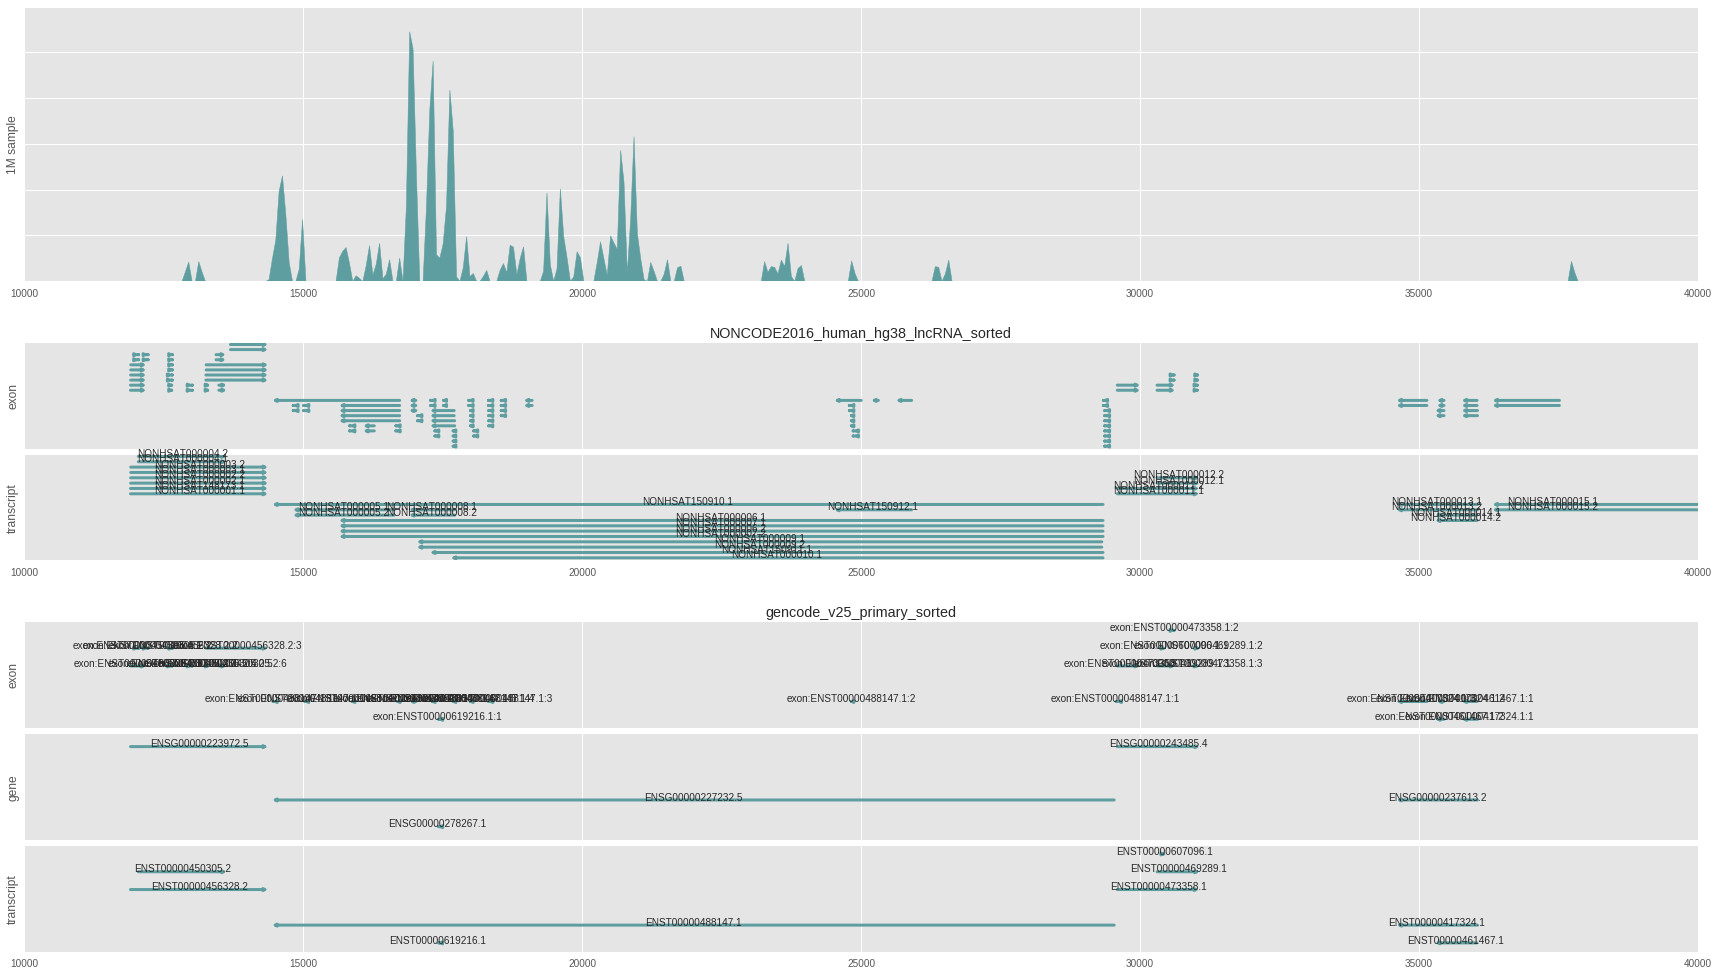

In [130]:
j.interval("chr1", 10000, 40000,
           alignment_yscale="linear",
           annotation_max_depth=10,
           annotation_label=True)

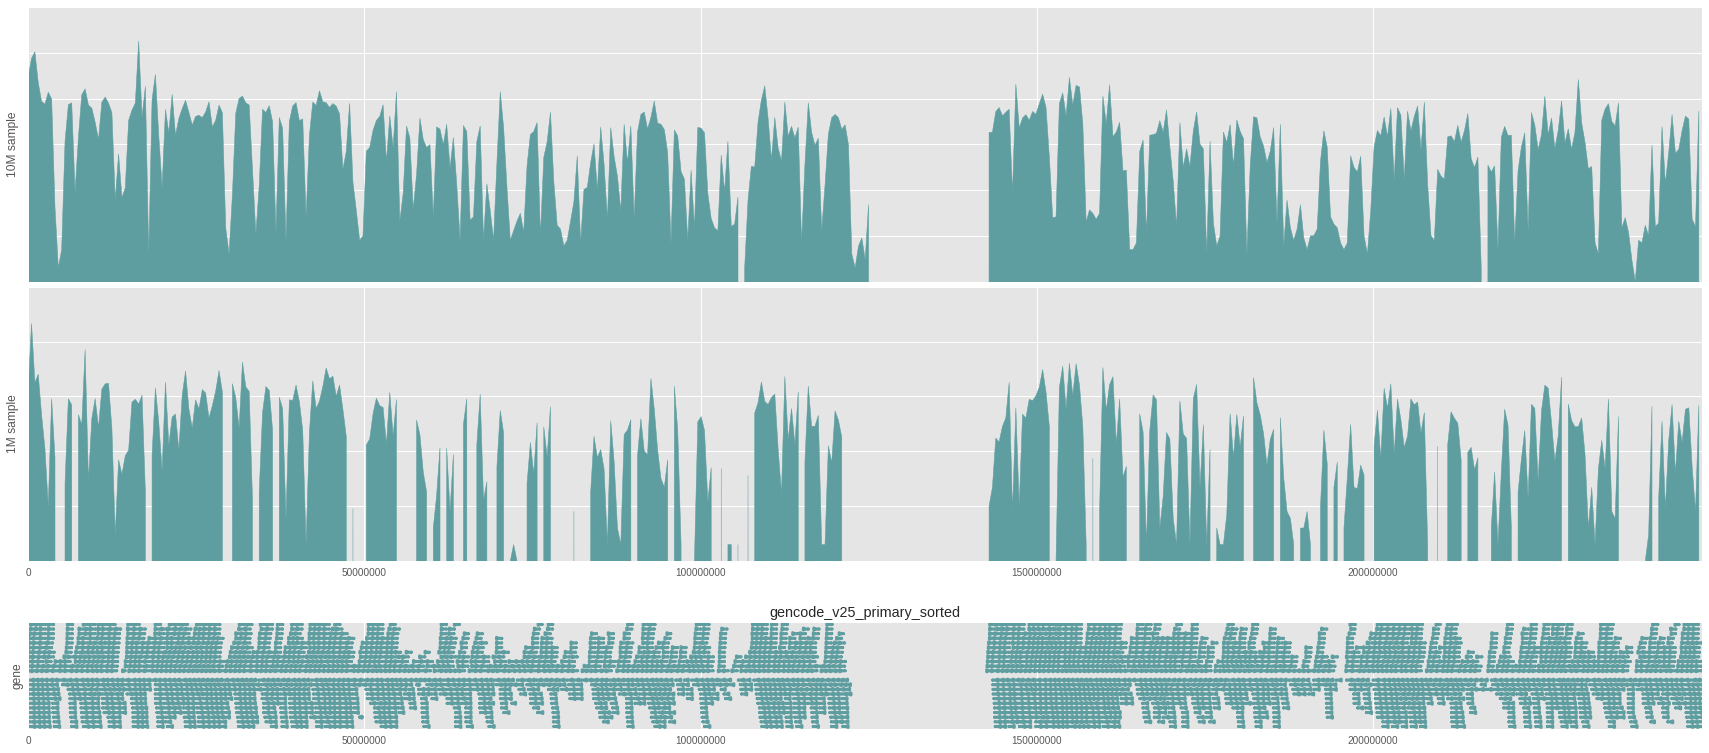

In [38]:
j.interval("chr1", alignment_yscale="log", annotation_feature_types=["gene"], annotation_max_depth=10)

In [39]:
j.annotation_details(n_max=20)

chr2   chr1   chr6   chr3   chr5   chr7  chr12   chr4  chr11   chr8  \
count  71850  71180  48917  48041  45530  41403  40679  39832  37296  37279   

       chr10  chr17   chr9  chr15  chr16  chr19  chr14  chr13  chr20   chrX  
count  35674  35292  32573  31295  29261  28910  28470  25091  20648  19896

exon  transcript
count  605359      233696

chr1    chr2   chr17   chr19    chr3   chr11   chr12   chr16    chr7  \
count  231881  192231  164876  163209  159916  155736  153087  124841  122040   

         chr6    chr5   chr4  chr15   chr8  chr14   chr9  chr10   chrX  chr22  \
count  115882  114550  99668  97163  94109  93023  90798  90525  80432  56209   

       chr20  
count  55746

exon     CDS  transcript  five_prime_UTR  three_prime_UTR  \
count  1183020  705063      198160          142512           134018   

       start_codon  stop_codon   gene  stop_codon_redefined_as_selenocysteine  
count        82679       74285  58096                                     117

chr1      chr10      chr11      chr12      chr13      chr15  \
length      248956422  133797422  135086622  133275309  114364328  101991189   
read_count     219652      55000     141050     163306      14496      51300   
rpkm         0.391567   0.182435   0.463398   0.543809  0.0562537   0.223228   

               chr16     chr17     chr18     chr19    ...           chr3  \
length      90338345  83257441  80373285  58617616    ...      198295559   
read_count     87608     89308     23180    118996    ...          81502   
rpkm        0.430393  0.476059  0.127996  0.900944    ...        0.18241   

                 chr4       chr5       chr6       chr7       chr8       chr9  \
length      190214555  181538259  170805979  159345973  145138636  138394717   
read_count      41884      74066     155928      86270      48224      64840   
rpkm        0.0977233   0.181069   0.405149   0.240277    0.14746    0.20793   

               chrM       chrX       chrY  
length        16569  156040895   57227415  
read_count   203976      65226       2248  
rpkm        5463.57   0.185514  0.0174336  

[3 rows x 23 columns]

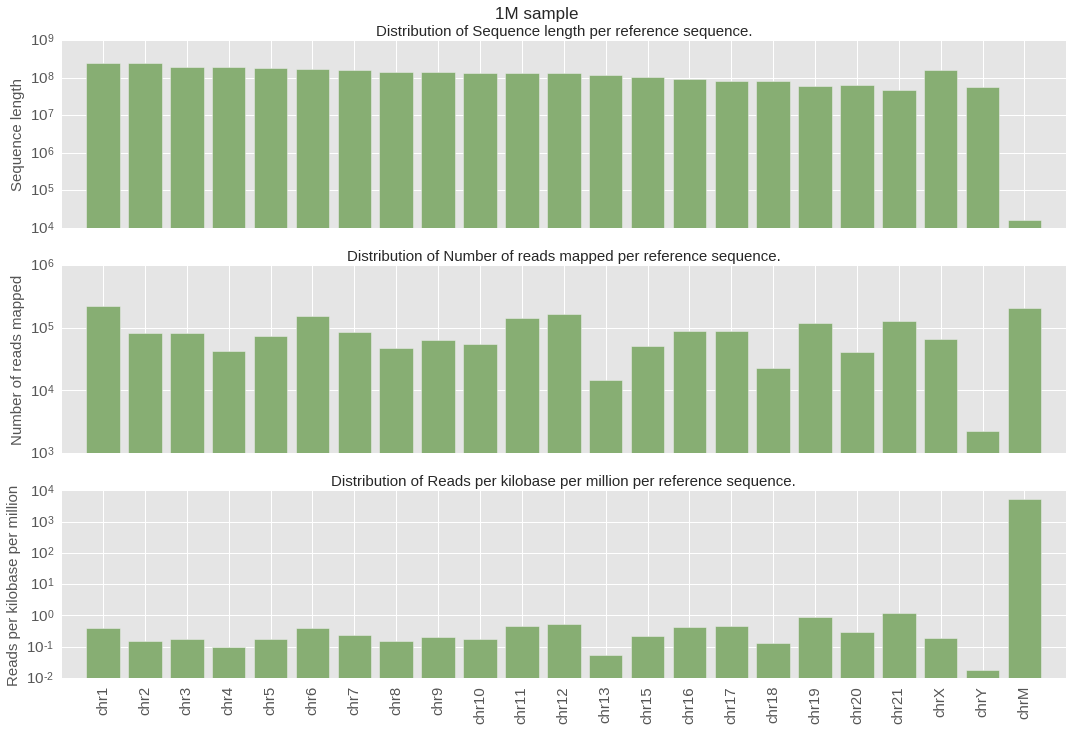

In [127]:
seqid_list=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chrX","chrY","chrM"]
j.alignment_distribution(criteria=["length", "read_count", "rpkm"], seqid_list=seqid_list , yscale="log", plot_style ="ggplot", color="sage", height=10, width=15, fontsize=15)

# Further dev of Annotation using Pandas instead of pysam

In [60]:
# -*- coding: utf-8 -*-

"""
  JGV is a Python3 package for an embed genomic viewer in Jupyter notebook. Do not import the package in a
  non-interactive environment

  Copyright 2016 Adrien Leger <aleg@ebi.ac.ul>
  [Github](https://github.com/a-slide)

  This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public
  License as published by the Free Software Foundation; either version 3 of the License, or(at your option) any later
  version

  This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied
  warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
  (http://www.gnu.org/licenses/gpl-3.0.html).

  You should have received a copy of the GNU General Public License along with this program; if not, write to the Free
  Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.
"""

# Strandard library imports
from collections import OrderedDict
from os import access, R_OK

# Third party import
import pandas as pd

# Local lib import
from JGV_helper_fun import *
from JGV_helper_fun import jprint as print

#~~~~~~~CLASS~~~~~~~#

class Annotation(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#

    def __init__ (self, fp, name=None, verbose=False):
        """
         * fp
            An URL to a standard genomic file containing features annotations among the following format:
            gff3 file (http://www.ensembl.org/info/website/upload/gff3.html)
            gtf file  (http://www.ensembl.org/info/website/upload/gff.html)
            bed http://www.ensembl.org/info/website/upload/bed.html
            Valid URL schemes include http, ftp, s3, and file.
            The file can eventually be compressed in ‘gzip’, ‘bz2’, ‘zip’ or ‘xz’
        *  name
            Name of the data file that will be used as track name for plotting. If not given, will be deduced from fp
            file name
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))

        #Save self variable
        self.fp = fp
        self.name = name if name else file_basename(fp)
        self.verbose = verbose
        self.ext = extensions(fp)[0]
        
        if self.ext not in ["gff3", "gtf", "bed"]:
            msg = "The file is not in gtf/gff3/bed format (.gff3/.gtg/.bed +-.gz). Please provide a correctly formated file"
            raise ValueError(msg)
                        
        if self.ext == "gtf":
            if self.verbose: print("Use GTF parser to parse annotations in file {}".format(pycl.file_name(self.fp)))
            self.df = self._gtf_parser(fp)
        elif self.ext == "gff3":
            if self.verbose: print("Use GFF3 parser to parse annotations in file {}".format(pycl.file_name(self.fp)))
            self.df = self._gff3_parser(fp)
        elif self.ext == "bed":
            if self.verbose: print("Use BED parser to parse annotations in file {}".format(pycl.file_name(self.fp)))
            self.df = self._bed_parser(fp)
        
        # Sort the dataframe
        if self.verbose: print("Sort annotation features by coordinates".format(self.ext))
        self.df.sort_values(by=["seqid","start","end"], inplace=True)
        
        # Verbose informations
        if self.verbose:
            print("Annotation features count:{}".format(self.feature_count))
            print("Seqid count:{}".format(self.seqid_count))
            print("Feature type count:{}".format(self.type_count))

    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__)
        # list all values in object dict in alphabetical order
        for k,v in OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0])).items():
            if k != "df":
                msg+="\t{}\t{}\n".format(k, v)
        return (msg)
    

    def __repr__ (self):
        return ("{} {} {} features".format(self.__class__.__name__, self.name, self.feature_count))

    #~~~~~~~PROPERTY METHODS~~~~~~~#
    
    @property
    def feature_count(self):
        """List of all the sequence ids found in the annotation file"""
        return len(self.df)
    
    @property
    def seqid_count(self):
        """Number of unique seqid found"""
        return self.df["seqid"].nunique()
    
    @property
    def seqid_list(self):
        """List of unique seqid found"""
        return self.df["seqid"].unique()

    @property
    def seqid_count_uniq(self):
        """List of all the sequence ids found in the annotation file"""
        return pd.DataFrame(self.df.groupby("seqid").size().sort_values(ascending=False), columns=["count"])

    @property
    def type_count(self):
        """Number of unique seqid found"""
        return self.df["type"].nunique()
    
    @property
    def type_list(self):
        """List of unique seqid found"""
        return self.df["type"].unique()
    
    @property
    def type_count_uniq(self):
        """List of all the sequence ids found in the annotation file"""
        return pd.DataFrame(self.df.groupby("type").size().sort_values(ascending=False), columns=["count"])

    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _bed_parser(self, fp):
        # Import the file in a dataframe
        col_names = ["seqid","start","end","ID","score","strand","thickStart","thickEnd","itemRgb","blockCount","blockSizes","blockStarts"]
        df = pd.read_csv(fp, sep="\t", names=col_names, index_col=False, comment="#")
        # Cast the start and end field in integer
        df[['start', 'end']] = df[['start', 'end']].astype(int)
        # Extract the ID field = first field of attribute
        df['type'] = "unknown"
        # Drop unecessary fields and reorganise order
        df = df[["seqid","start","end","strand","ID", "type"]]
        return df

    def _gff3_parser(self, fp):
        # Import the file in a dataframe
        col_names = ["seqid","source","type","start","end","score","strand","frame","attribute"]
        df = pd.read_csv(fp, sep="\t", names=col_names, index_col=False, comment="#")
        # Cast the start and end field in integer
        df[['start', 'end']] = df[['start', 'end']].astype(int)
        # Extract the ID field = first field of attribute
        df['ID'] = df["attribute"].str.split(';').str[0].str[3:]
        # Drop unecessary fields and reorganise order
        df = df[["seqid","start","end","strand","ID","type"]]
        return df

    def _gtf_parser(self, fp):
        # Import the file in a dataframe
        col_names = ["seqid","source","type","start","end","score","strand","frame","attribute"]
        df = pd.read_csv(fp, sep="\t", names=col_names, index_col=False, comment="#")
        # Cast the start and end field in integer
        df[['start', 'end']] = df[['start', 'end']].astype(int)
        # Extract the ID field = first field of attribute=
        df['ID'] = df["attribute"].str.split('\"').str[1]
        # Drop unecessary fields and reorganise order
        df = df[["seqid","start","end","strand","ID","type"]]
        return df
    
    #~~~~~~~PUBLIC METHODS~~~~~~~#

    def interval_features (self, seqid, start=None, end=None, feature_type=None):
        """
        Parse the annotation file for the given seqid and interval and return a dataframe containing all the features
        found for each original line in the gff or gtf file. Features are identified by their ID for gff3 file. For gtf
        file the ID is parsed only for exon, cds, transcript or genes, if found.
        * seqid
            Name of the sequence from the initial fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
        * feature_types
            Name of a valid feature type ( "exon"|"transcript"|"gene"|"CDS"...) or list of names of feature type for
            which a row will be returned. The option is not available for bed files. If not given, all features type
            found in the interval will be returned [ DEFAULT: None ]
        """
        # Verify that the sequence is in the seqid list
        if seqid not in self.seqid_list:
            if self.verbose: print("Seqid ({}) not found in the list for the annotation {}".format(seqid, self.name))
            return pd.DataFrame()
        ####################################################################################################################################
        
        # Select the seqid 
        df = self.df[(self.df["seqid"] == seqid)]
        
        # Select start, end and feature types if required
        if feature_type and self.ext != "bed":
            if type(feature_type) == list:
                df = df[(df["type"].isin(feature_type))]
            elif type(feature_type) == str:
                df = df[(df["type"] == feature_type)]
        if start:
            df = df[(df["end"] > start)]
        if end:
            df = df[(df["start"] < end)]
        
        return df.copy().reset_index(drop=True)


In [53]:
fp= "../dl_test_data/NONCODE2016_hg38.lncAndGene.bed.gz"
a = Annotation (fp, verbose=True)
print(a)
display(a.seqid_count_uniq.head())
display(a.type_count_uniq.head())
display(a.df.head())

count
seqid       
chr2   19662
chr1   19407
chr6   14176
chr5   13241
chr3   13209

count
type           
unknown  231415

seqid  start    end strand               ID     type
155058  chr1  11868  14409      +  NONHSAT148173.1  unknown
26935   chr1  11868  14412      +  NONHSAG000001.2  unknown
90062   chr1  11871  14412      +  NONHSAT000002.2  unknown
90063   chr1  11873  14409      +  NONHSAT000003.2  unknown
90064   chr1  12009  13670      +  NONHSAT000004.2  unknown

In [54]:
fp= "../dl_test_data/gencode_v25_primary.gtf.gz"
a = Annotation (fp, verbose=True)
print(a)
display(a.seqid_count_uniq.head())
display(a.type_count_uniq.head())
display(a.df.head())

count
seqid        
chr1   232138
chr2   192370
chr17  165020
chr19  163413
chr3   160060

count
type                
exon         1183020
CDS           704391
UTR           279786
transcript    198160
start_codon    82679

seqid  start    end strand                 ID        type
2579823  GL000009.2  56140  58083      -  ENSG00000278704.1         UTR
2579817  GL000009.2  56140  58376      -  ENSG00000278704.1        gene
2579818  GL000009.2  56140  58376      -  ENSG00000278704.1  transcript
2579819  GL000009.2  56140  58376      -  ENSG00000278704.1        exon
2579822  GL000009.2  58081  58083      -  ENSG00000278704.1  stop_codon

In [61]:
fp= "../dl_test_data/gencode_v25_primary.gff3.gz"
a = Annotation (fp, verbose=True)
print(a)
display(a.seqid_count_uniq.head())
display(a.type_count_uniq.head())
display(a.df.head())

count
seqid        
chr1   231881
chr2   192231
chr17  164876
chr19  163209
chr3   159916

count
type                    
exon             1183020
CDS               705063
transcript        198160
five_prime_UTR    142512
three_prime_UTR   134018

seqid  start    end strand                            ID  \
2577242  GL000009.2  56140  58080      -        UTR3:ENST00000618686.1   
2577236  GL000009.2  56140  58376      -             ENSG00000278704.1   
2577237  GL000009.2  56140  58376      -             ENST00000618686.1   
2577238  GL000009.2  56140  58376      -      exon:ENST00000618686.1:1   
2577241  GL000009.2  58081  58083      -  stop_codon:ENST00000618686.1   

                    type  
2577242  three_prime_UTR  
2577236             gene  
2577237       transcript  
2577238             exon  
2577241       stop_codon

In [62]:
display(a.interval_features("chr1").head())

seqid  start    end strand                        ID        type
0  chr1  11869  12227      +  exon:ENST00000456328.2:1        exon
1  chr1  11869  14409      +         ENSG00000223972.5        gene
2  chr1  11869  14409      +         ENST00000456328.2  transcript
3  chr1  12010  12057      +  exon:ENST00000450305.2:1        exon
4  chr1  12010  13670      +         ENST00000450305.2  transcript

In [63]:
display(a.interval_features("chr1", 159000, 169000, "exon").head())

seqid   start     end strand                        ID  type
0  chr1  160446  160690      +  exon:ENST00000496488.1:1  exon
1  chr1  161314  161525      +  exon:ENST00000496488.1:2  exon
2  chr1  164263  164791      -  exon:ENST00000466557.6:6  exon
3  chr1  165884  165942      -  exon:ENST00000466557.6:5  exon
4  chr1  165889  165942      -  exon:ENST00000491962.1:3  exon

In [66]:
display(a.interval_features("chr1", end=169000, feature_type= ["exon", "genes"]).head())

seqid  start    end strand                        ID  type
0  chr1  11869  12227      +  exon:ENST00000456328.2:1  exon
1  chr1  12010  12057      +  exon:ENST00000450305.2:1  exon
2  chr1  12179  12227      +  exon:ENST00000450305.2:2  exon
3  chr1  12613  12697      +  exon:ENST00000450305.2:3  exon
4  chr1  12613  12721      +  exon:ENST00000456328.2:2  exon

### Comparison of the 2 version of annotation

In [4]:
from Annotation import Annotation as A1
from Annotation2 import Annotation as A2

In [5]:
fp= "../dl_test_data/gencode_v25_primary.gff3.gz"
a = A1(fp, verbose=True)
print(a)

In [6]:
fp= "../dl_test_data/gencode_v25_primary.gff3.gz"
a = A2(fp, verbose=True)
print(a)

**The new version is nearly twice quicker...**

### Proto based on Counter and parsing of all bam lines

Reference method with samtools and bedtools to produce a coverage graph => takes around 1 min 40 s 

In [8]:
! samtools sort "../dl_test_data/1M.bam" | bedtools genomecov -d -ibam - > "../dl_test_data/1M_sorted.bed"

^C


**It might be a good idea to do the same for bam/sam file. The only problem is that computing the coverage for each base is going to be longer and more memory hungry as it need to read the cigar of each read**

In [12]:
! samtools view -h "../dl_test_data/1M.bam" > "../dl_test_data/1M.sam"
h("../dl_test_data/1M.sam")

@HD	VN:1.4	SO:coordinate
@SQ	SN:chr1	LN:248956422
@SQ	SN:chr2	LN:242193529
@SQ	SN:chr3	LN:198295559
@SQ	SN:chr4	LN:190214555
@SQ	SN:chr5	LN:181538259
@SQ	SN:chr6	LN:170805979
@SQ	SN:chr7	LN:159345973
@SQ	SN:chr8	LN:145138636
@SQ	SN:chr9	LN:138394717


In [8]:
fp = "../dl_test_data/1M.bam"
min_coverage = 2

d = OrderedDict()

print ("Compute coverage from the bam lines")
with pysam.AlignmentFile(fp) as bam:   
   
    for ref in bam.references:
        d[ref] = {"+":Counter(), "-":Counter()}
    
    for line in bam:
        ref = line.reference_name
        strand = "-" if line.is_reverse else "+"
        
        for position in line.get_reference_positions(): 
            d[ref][strand][position]+=1

print ("Filtering coordinates")
for ref in d.keys():
    d[ref]["+"] = {i:j for i, j in d[ref]["+"].items() if j >= min_coverage}
    d[ref]["-"] = {i:j for i, j in d[ref]["-"].items() if j >= min_coverage}

In [5]:
fp = "../dl_test_data/1M.sam"
min_coverage = 5

d = OrderedDict()

print ("Compute coverage from the bam lines")
with pysam.AlignmentFile(fp) as bam:   
   
    for ref in bam.references:
        d[ref] = {"+":Counter(), "-":Counter()}
    
    for line in bam:
        ref = line.reference_name
        strand = "-" if line.is_reverse else "+"
        
        for position in line.get_reference_positions(): 
            d[ref][strand][position]+=1

print ("Filtering coordinates")
for ref in d.keys():
    d[ref]["+"] = {i:int(j) for i, j in d[ref]["+"].items() if j >= min_coverage}
    d[ref]["-"] = {i:j for i, j in d[ref]["-"].items() if j >= min_coverage}

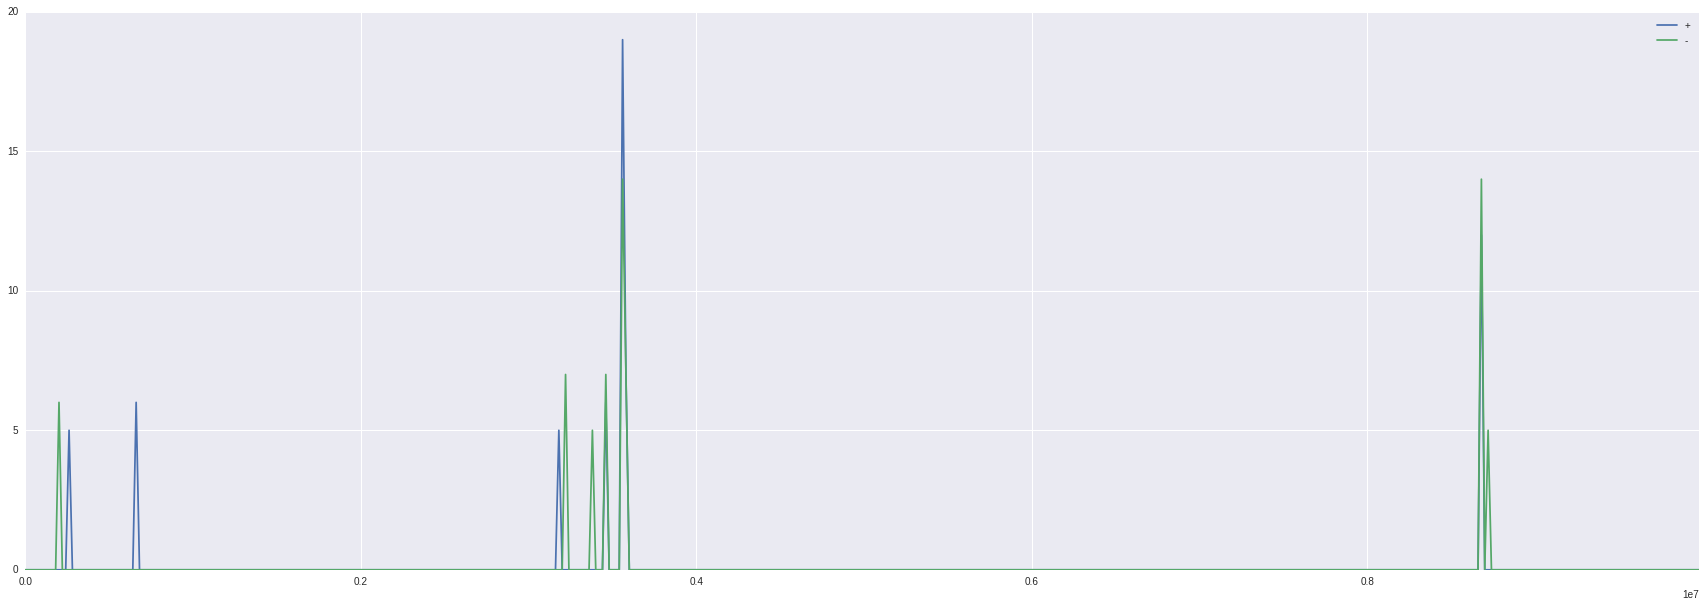

In [9]:
start = 0
end = 10000000
bins = 500
step = (end-start)/bins
s = d["chr2"]

df=pd.DataFrame(columns=["+", "-"], dtype=int)

for i in np.arange (start, end, step):  
    lpos = []
    lneg = []
    for position in arange(i, i+step, 1):
        position = int(position)
        lpos.append(s["+"].get(position, 0))
        lneg.append(s["-"].get(position, 0))
            
    df.loc[int(i)]= [max(lpos), max(lneg)]

df.plot(figsize=(30,10))

### With Numpy

In [4]:
fp = "../dl_test_data/1M.bam"
min_coverage = 5

d = OrderedDict()

print ("Compute coverage from the bam lines")
with pysam.AlignmentFile(fp) as bam:
    for refname, reflen in zip (bam.references, bam.lengths):
        d[refname] = np.zeros(shape=(reflen, 2), dtype=int)
    
    for line in bam:
        refname = line.reference_name
        strand = int(line.is_reverse)
        
        for position in line.get_reference_positions():
            d[refname][position, strand] +=1

In [ ]:
pd.DataFrame(d["chrY"][10000:20000], columns=["Negative Strand", "Positive Strand"]).plot(figsize=(30, 10))

In [ ]:
fp = "../dl_test_data/1M_sorted.bam"
min_coverage = 5

d = OrderedDict()

print ("Compute coverage from the bam lines")
with pysam.AlignmentFile(fp) as bam:
    for refname, reflen in zip (bam.references, bam.lengths):
        d[refname] = np.zeros(shape=(reflen, 2), dtype=int)
    
    for line in bam:
        refname = line.reference_name
        strand = int(line.is_reverse)
        
        for position in line.get_reference_positions():
            d[refname][position, strand] +=1

In [14]:
with pysam.AlignmentFile("../dl_test_data/1M_sorted.bam", "rb") as bam:
    df = pd.Series(index=bam.references, data=bam.lengths)

248956422

### Rewriting of the class with the native data structure parsing

In [237]:
# -*- coding: utf-8 -*-

"""
  Alignment.py
  JGV is a Python3 package for an embed genomic viewer in Jupyter notebook. Do not import the package in a
  non-interactive environment

  Copyright 2016 Adrien Leger <aleg@ebi.ac.ul>
  [Github](https://github.com/a-slide)

  This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public
  License as published by the Free Software Foundation; either version 3 of the License, or(at your option) any later
  version

  This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied
  warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
  (http://www.gnu.org/licenses/gpl-3.0.html).

  You should have received a copy of the GNU General Public License along with this program; if not, write to the Free
  Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.
"""

# Strandard library imports
from collections import OrderedDict, Counter
from os import access, R_OK, W_OK
from sys import stdout
from gzip import open as gopen

# Third party import
import pysam

# Local lib import
from JGV_helper_fun import *
from JGV_helper_fun import jprint as print

#~~~~~~~CLASS~~~~~~~#

class Alignment(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#

    def __init__ (self, fp, name=None, verbose=False, min_coverage=5, ref_list=[], output_bed=False):
        """
         * fp
             A standard BAM or SAM (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             The files do not need to be sorted or indexed
        *  name
            Name of the data file that will be used as track name for plotting. If not given, will be deduced from fp file name
        * verbose 
            If True, will print more information during initialisation and calls of all the object methods.
        * min_coverage
            [ DEFAULT: 5 ]
        * ref_list
            [ DEFAULT: [] ]
        * output_coverage_file
            [ DEFAULT: None ]
        """
        # Verify that the file is readable
        assert access(fp, R_OK), "{} is not readable".format(fp)

        #Save self variable
        self.fp = fp
        self.name = name if name else file_basename(fp)
        self.verbose = verbose
        self.ext = extensions(fp)[0]
        self.nbases = 0
        
        if self.ext in ["bam","sam"]:
            if self.verbose: print("Compute coverage from bam/sam file ", self.fp)
            self.d = self._bam_parser(fp, min_coverage, ref_list)
        elif self.ext == "bed":
            if self.verbose: print("Extract coverage from bed file", self.fp)
            self.d = self._bed_parser(fp, min_coverage, ref_list)
        else:
            msg = "The file is not in SAM/BAM/BED format. Please provide a correctly formated file"
            raise ValueError(msg)
        
        if output_bed:
            #assert access(output_file, W_OK), "{} is not writable".format(fp)
            outfp = "{}/{}.bed.gz".format(dir_path(fp), file_basename(fp))
            if self.verbose: print("Write coverage data in file ", outfp)
            self._write_coverage_file (outfp)
            self.outfp=outfp

    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__)
        # list all values in object dict in alphabetical order
        for k,v in OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0])).items():
            if k == "d":
                for refid, refval in v.items():
                    msg+="\t{}\tlength:{}\tnbases:{}\n".format(refid, refval["length"], refval["nbases"])
            else:    
                msg+="\t{}\t{}\n".format(k, v)
        return (msg)

    def __repr__ (self):
        return ("{}-{}".format(self.__class__.__name__, self.name))
        
    #~~~~~~~PRIVATE METHODS~~~~~~~#   
    
    def _bam_parser(self, fp, min_coverage=5, ref_list= []):
        
        d = OrderedDict()
        
        # Parse Bam/Sam file
        with pysam.AlignmentFile(fp) as bam:   
            
            # Save information for References based on the bam header
            for refid, length in zip(bam.references, bam.lengths):
                if not ref_list or refid in ref_list:
                    d[refid] = {"length":length, "nbases":0, "+":Counter(), "-":Counter()}         
            
            # Tally the coverage for each base 
            for line in bam:
                refid = line.reference_name  
                if refid in d:
                    strand = "-" if line.is_reverse else "+"
                    for position in line.get_reference_positions(): 
                        d[refid][strand][position] += 1

        # Remove base with coverage below threshold and transform in Pandas Series
        for refid in d.keys():
            for strand in ["+","-"]:
                s = OrderedDict()
                for position, coverage in d[refid][strand].items():
                    if coverage >= min_coverage:
                        s[position] = coverage
                        self.nbases += coverage
                        d[refid]["nbases"] += coverage
                d[refid][strand] = pd.Series(s, dtype="int64")
                d[refid][strand].sort_index(inplace=True)
            
        return d
    
    def _bed_parser (self, fp, min_coverage=5, ref_list = []):
        
        d = OrderedDict()

        try:
            fin = gopen(fp, "rt") if fp[-2:].lower() == "gz" else open (file, "r")
            
            for line in fin:
                if line.startswith("#"):
                    sl = line[1:-1].split("\t")
                    refid = sl[0]
                    if not ref_list or refid in ref_list:
                        length = int(sl[1])
                        d[refid] = {"length":length, "nbases":0, "+":OrderedDict(), "-":OrderedDict()}
                else:
                    sl = line[0:-1].split("\t")
                    refid = sl[0]
                    if refid in d:
                        position = int(sl[1])
                        coverage = int(sl[4])
                        strand = sl[5]              
                        d[refid][strand][position] = coverage
                        d[refid]["nbases"] += coverage
                        self.nbases += coverage
            
            for refid in d.keys():
                for strand in ["+","-"]:
                    d[refid][strand] = pd.Series(d[refid][strand], dtype="int64")
                        
        # close the file properly
        finally:
            return d
            try:
                f.close()
            except:
                pass

    def _write_coverage_file (self, outfp, buf_size=8192 ):
        with gopen (outfp, "wt") as out:
            
            # Write header containing chromosome information
            for refid, refval in self.d.items():
                out.write("#{}\t{}\n".format(refid, refval["length"]))
                
            # Bufferized writing of lines
            i = 0
            str_buf = ""
            for refid, refval in self.d.items():
                for strand in ["+","-"]: 
                    for position, coverage in refval[strand].items():
                        i+=1
                        str_buf += "{0}\t{1}\t{1}\tpos{2}\t{3}\t{4}\n".format(refid, position, i, coverage, strand)
                        if i%buf_size == 0:
                            out.write(str_buf)
                            str_buf = ""
                            
                    out.write(str_buf)
                    str_buf = ""
    
    #~~~~~~~PROPERTY METHODS~~~~~~~#
    
    @property
    def refid_len(self):
        """List of all the sequence ids found in the annotation file"""
        s = pd.Series(name="length")
        for refid, refval in self.d.items():
            s.loc[refid] = refval["length"]
        return s.sort_values(ascending=False)

    @property
    def refid_nbases(self):
        """List of all the sequence ids found in the annotation file"""
        s = pd.Series(name="nbases")
        for refid, refval in self.d.items():
            s.loc[refid] = refval["nbases"]
        return s.sort_values(ascending=False)
    
    #~~~~~~~PUBLIC METHODS~~~~~~~#

    def refid_count (self):
        """
        Return a dataframe containing 3 colums ("reads", "rpkm") for all seq_id reference
        sequence in the BAM file. The read count is computationally intensive and can take time for large BAM files
        """

        df = pd.DataFrame(columns=["nbases", "bpkm"])
        
        for refid, refval in self.d.items():
            df.loc[refid] = [
                refval["nbases"],
                refval["nbases"]/(refval["length"]/1000)/(self.nbases/1000000)]

        return df

    def interval_coverage (self, refid, start=None, end=None, bins=500, bin_repr_fun = "max"): 
        """
        Parse the alignment file for a given seqid and interval. Compute the coverage at read level in mode "read_count"
        or at base level in mode "base_coverage". In both case the interval is splited in a number of windows equal to
        n_step, for which the coverage in computed. The method return a dataframe containing the starting positions of
        the windows and the coverage.
        * seqid
            Name of the sequence from the original fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
       * n_step
            Number of alignment count bins to divide the displayed window. Low number will result in low resolution but
        """
        # Verifications and auto adjustment of coordinates
        assert refid in self.d, "The reference {} is not in the list of references with alignment".format(refid)
        if not start or start < 0:
            start = 0
            if self.verbose: print ("Auto adjust start position: {}".format(start))
        if not end or end > self.d[refid]["length"]:
            end = self.d[refid]["length"]
            if self.verbose: print ("Auto adjust end position: {}".format(end))
        assert start < end, "Start coordinate must be smaller than end"
        if bins > end-start:
            bins = end-start
            if self.verbose: print ("Auto adjust the number of bins to match the interval: {}".format(bins))
        step = (end-start)/bins
        if self.verbose: print ("Define size of each bin: {}".format(step))
        
        # Select positions windows and get maximun
        df = pd.DataFrame(columns=["+", "-"], dtype=int)            
            
        for i in np.arange (start, end, step):
            winstart = int(i)
            winend = int(i+step)
            
            for strand in ["+","-"]:
                l = self.d[refid][strand][(self.d[refid][strand].index >= winstart)&(self.d[refid][strand].index < winend)]
                if l.empty:
                    df.loc[int(i), strand] =  0
                elif bin_repr_fun == "max":
                    df.loc[int(i), strand] = l.max()
                elif bin_repr_fun == "sum":
                    df.loc[int(i), strand] = l.sum()
                elif bin_repr_fun == "mean":
                    df.loc[int(i), strand] = l.sum()/step
        
        return df

In [238]:
ref_list=["chrY", "chrM"]
fp="../dl_test_data/1M.bam"

a = Alignment(fp, verbose=True, ref_list=ref_list, min_coverage=5, output_bed=True)
print(a)
print(pycl.fastcount(a.outfp))
pycl.linerange(a.outfp)

0	#chrY	57227415
1	#chrM	16569
2	chrY	281577	281577	pos1	5	+
...
30178	chrM	16566	16566	pos30177	8	-
30179	chrM	16567	16567	pos30178	8	-
30180	chrM	16568	16568	pos30179	8	-


In [239]:
ref_list = ["chrM"]
fp = "../dl_test_data/1M.bed.gz"

a = Alignment(fp, verbose=True, ref_list=ref_list, min_coverage=5)
print(a)

In [235]:
ref_list = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chrX", "chrY", "chrM"]
fp = "../dl_test_data/1M.bam"

a = Alignment(fp, verbose=True, ref_list=ref_list, min_coverage=5, output_bed=True)
print(a)
print(pycl.fastcount(a.outfp))
pycl.linerange(a.outfp)

0	#chr1	248956422
1	#chr2	242193529
2	#chr3	198295559
...
1661339	chrM	16566	16566	pos1661316	8	-
1661340	chrM	16567	16567	pos1661317	8	-
1661341	chrM	16568	16568	pos1661318	8	-


chr1    248956422
chr2    242193529
chr3    198295559
chr4    190214555
chr5    181538259
Name: length, dtype: int64

chr21    4551459
chr16    1905311
chrM     1849737
chr2     1684153
chr1     1672759
Name: nbases, dtype: int64

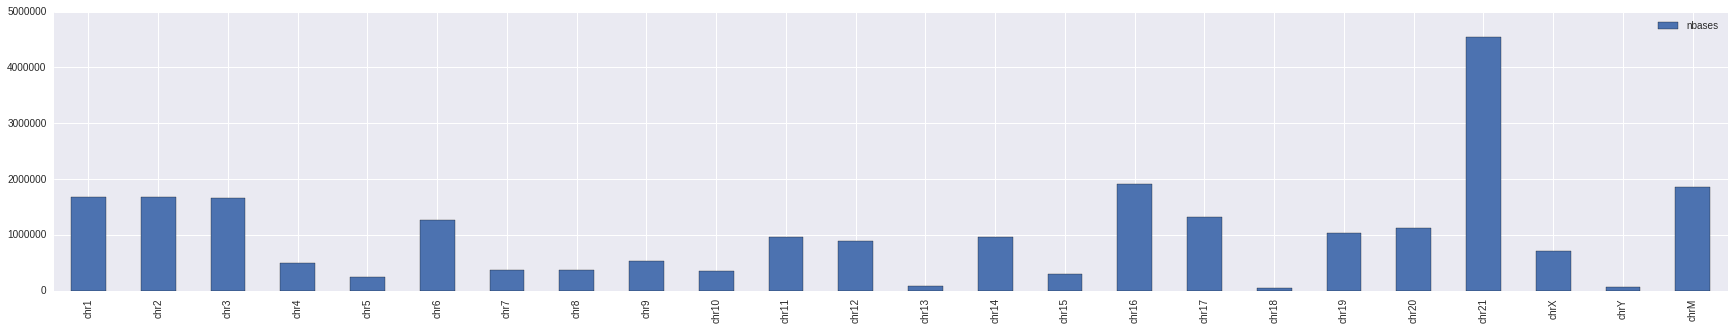

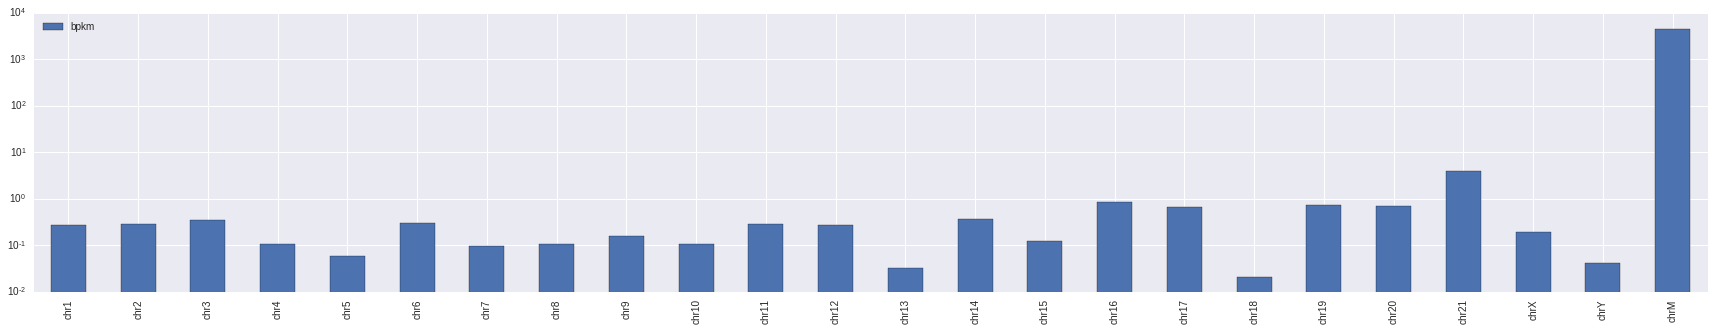

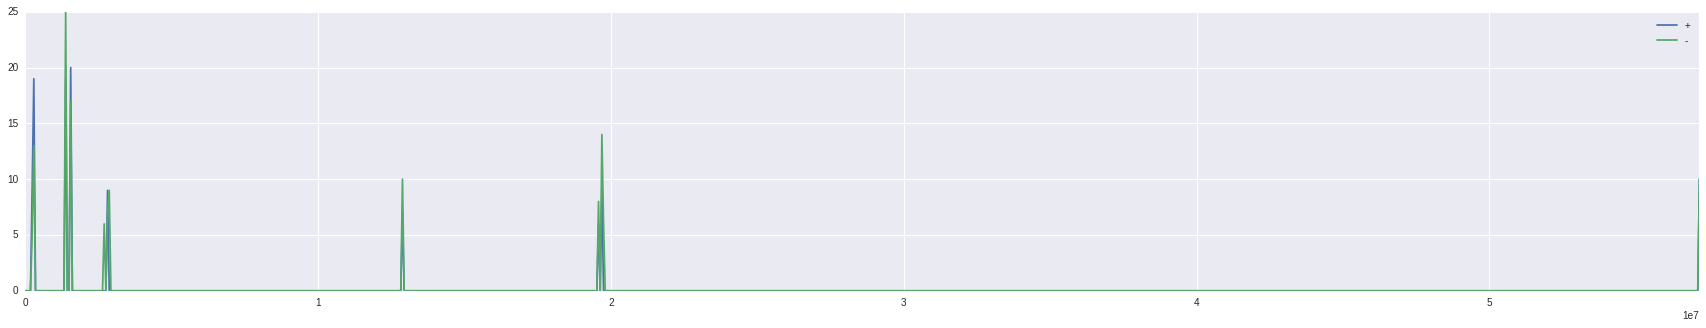

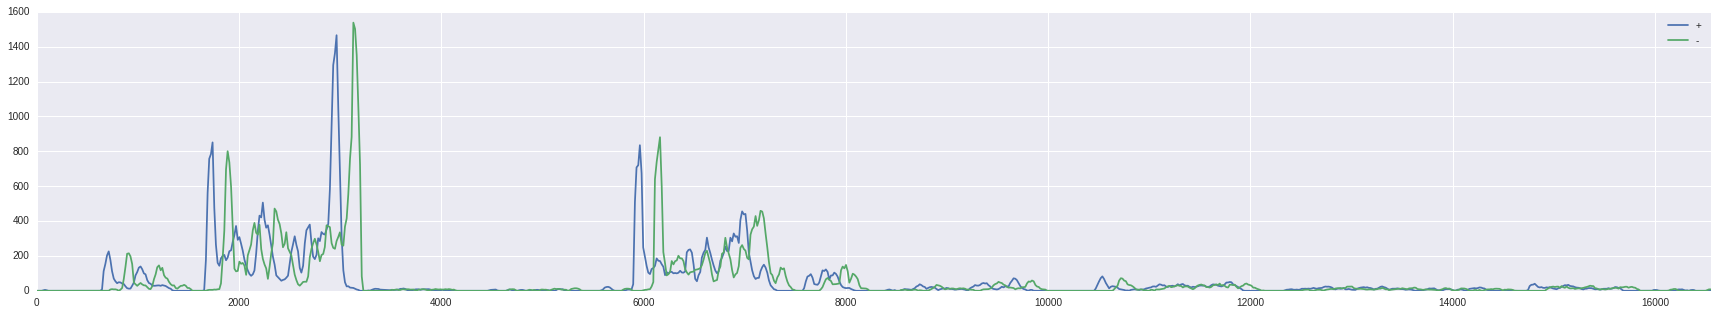

In [236]:
display(a.refid_len.head())
display(a.refid_nbases.head())
a.refid_count()[["nbases"]].plot.bar(figsize = (30,5))
a.refid_count()[["bpkm"]].plot.bar(log=True, figsize = (30,5))
a.interval_coverage("chrY", bins=1000, bin_repr_fun = "max").plot(figsize=(30,5))
a.interval_coverage("chrM", bins=1000, bin_repr_fun = "mean").plot(figsize=(30,5))

In [230]:
ref_list = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chrX", "chrY", "chrM"]
fp = "../dl_test_data/1M.bed.gz"

a = Alignment(fp, verbose=True, ref_list=ref_list, min_coverage=5)
print(a)

chr1    248956422
chr2    242193529
chr3    198295559
chr4    190214555
chr5    181538259
Name: length, dtype: int64

chr21    4551459
chr16    1905311
chrM     1849737
chr2     1684153
chr1     1672759
Name: nbases, dtype: int64

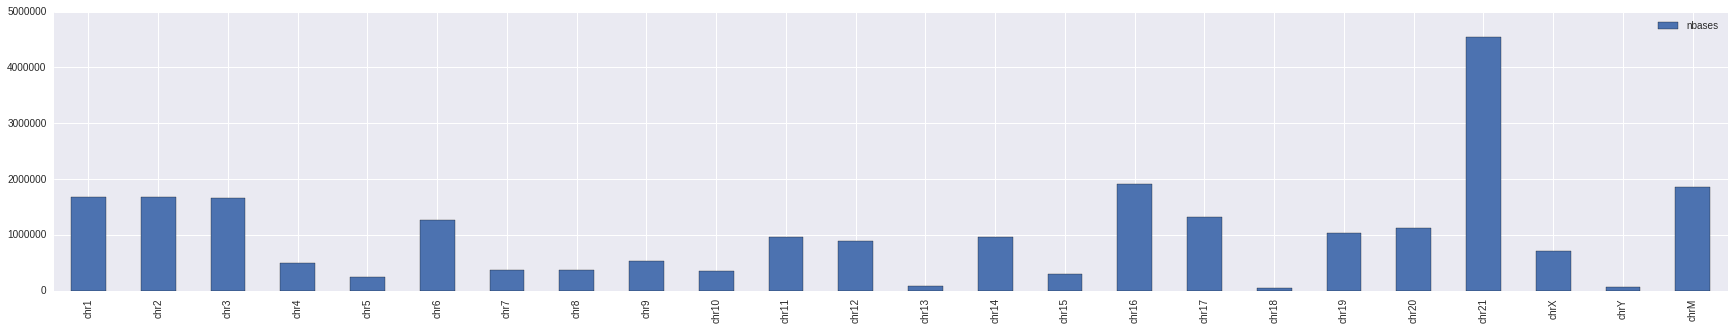

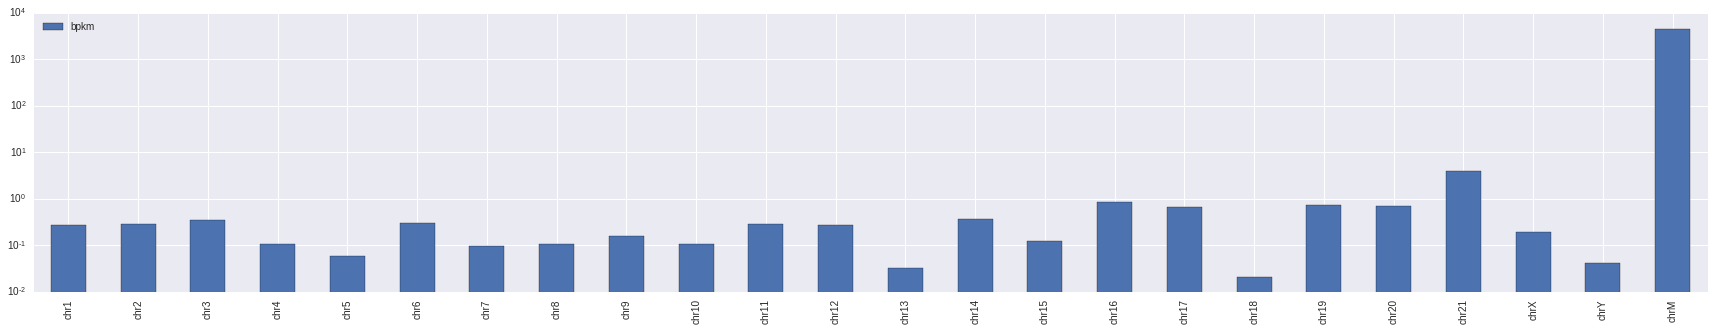

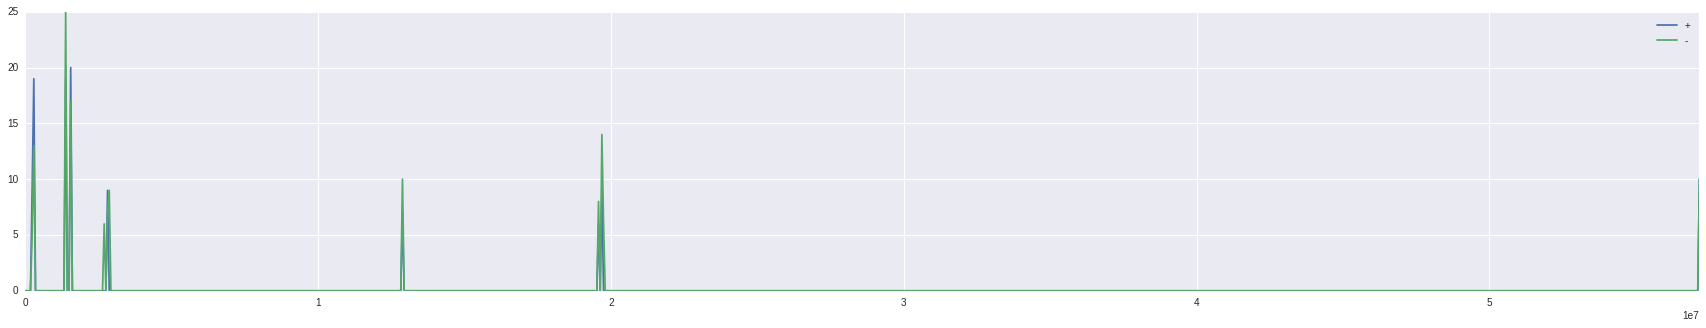

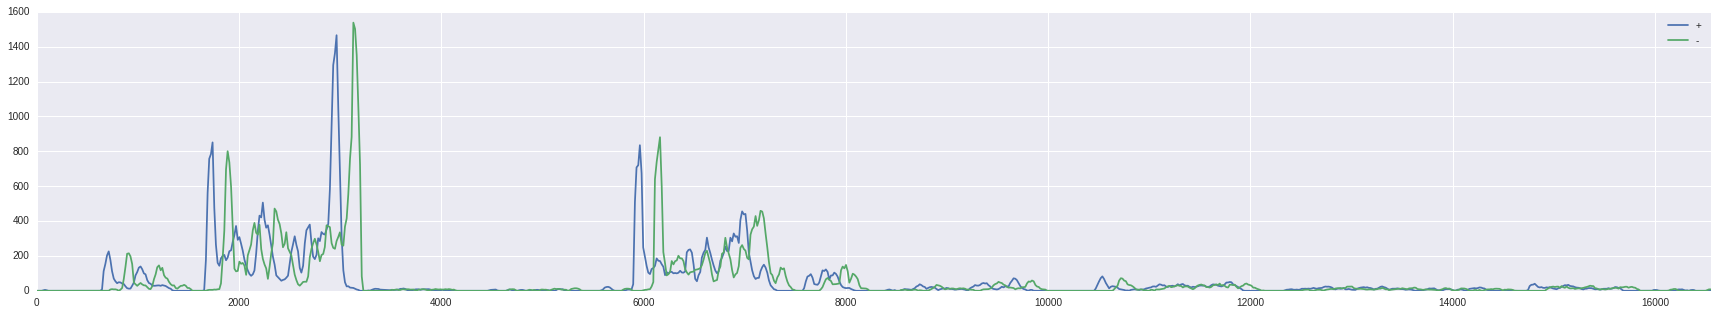

In [234]:
display(a.refid_len.head())
display(a.refid_nbases.head())
a.refid_count()[["nbases"]].plot.bar(figsize = (30,5))
a.refid_count()[["bpkm"]].plot.bar(log=True, figsize = (30,5))
a.interval_coverage("chrY", bins=1000, bin_repr_fun = "max").plot(figsize=(30,5))
a.interval_coverage("chrM", bins=1000, bin_repr_fun = "mean").plot(figsize=(30,5))

**Test from imported class**

In [4]:
from Alignment2 import Alignment

In [6]:
ref_list = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chrX", "chrY", "chrM"]
fp = "../dl_test_data/1M.bam"

a = Alignment(fp, verbose=True, ref_list=ref_list, min_coverage=5, output_bed=True)
print(a)
print(pycl.fastcount(a.outfp))
pycl.linerange(a.outfp)

0	#chr1	248956422
1	#chr2	242193529
2	#chr3	198295559
...
1661339	chrM	16566	16566	pos1661316	8	-
1661340	chrM	16567	16567	pos1661317	8	-
1661341	chrM	16568	16568	pos1661318	8	-


In [5]:
ref_list = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chrX", "chrY", "chrM"]
fp = "../dl_test_data/1M.bed.gz"

a = Alignment(fp, verbose=True, ref_list=ref_list, min_coverage=5)
print(a)

chr1    248956422
chr2    242193529
chr3    198295559
chr4    190214555
chr5    181538259
Name: length, dtype: int64

chr21    4551459
chr16    1905311
chrM     1849737
chr2     1684153
chr1     1672759
Name: nbases, dtype: int64

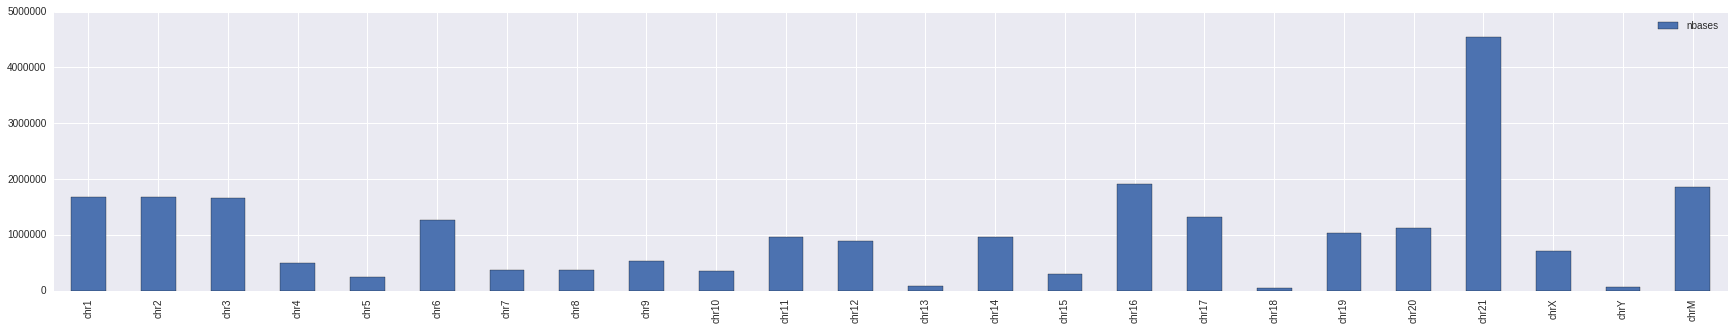

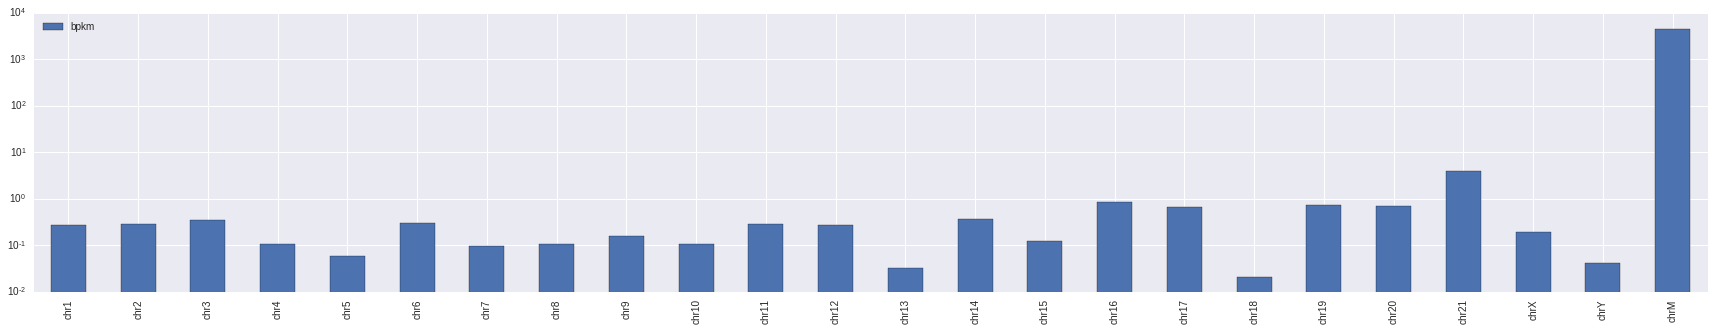

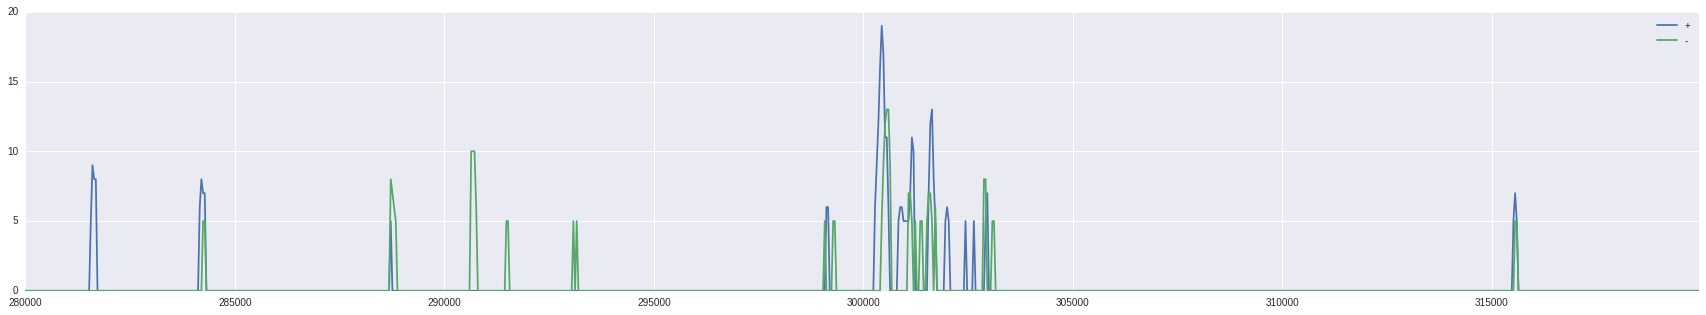

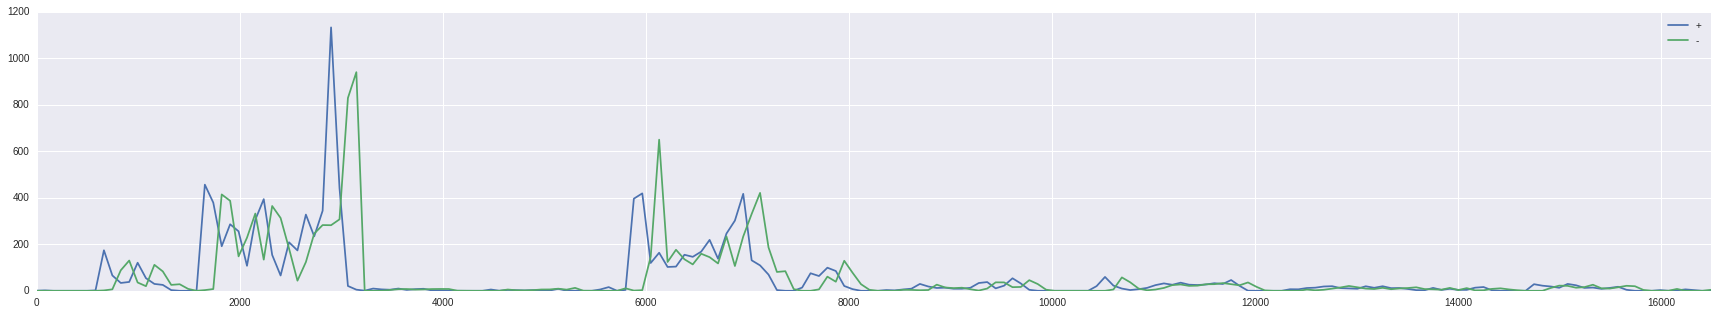

In [10]:
display(a.refid_len.head())
display(a.refid_nbases.head())
a.refid_count()[["nbases"]].plot.bar(figsize = (30,5))
a.refid_count()[["bpkm"]].plot.bar(log=True, figsize = (30,5))
a.interval_coverage("chrY", start=280000, end = 320000, bins=1000, bin_repr_fun = "max").plot(figsize=(30,5))
a.interval_coverage("chrM", bins=200, bin_repr_fun = "mean").plot(figsize=(30,5))